
# RNA-seq VAE Feature Analysis with SHAP and Sparse Autoencoder

This notebook implements 2 approaches approaches to explain features from a VAE trained on RNA-seq data:
1. SHAP (SHapley Additive exPlanations)
2. Sparse Autoencoder
oencoder features)






## 1. Setup and Data Preparation


In [211]:


# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import umap
import shap
import os
import time


In [212]:

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Helper function to get appropriate device
def get_device():
    """Get the appropriate device for M1 Mac"""
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using MPS (Metal Performance Shaders) device")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using CUDA device")
    else:
        device = torch.device("cpu")
        print("Using CPU device")
    return device

# Use GPU if available
device = get_device()


Using MPS (Metal Performance Shaders) device




## 2. Data Loading and Preprocessing


In [213]:


# Load the FPKM RNA-seq data
fpkm = pd.read_csv('data/tcga.brca.rnaseq.unstranded.fpkm.counts.matrix.txt', sep='\t', index_col=0)
rnaseq_df = fpkm

# Load the HRD score data
hrd_df = pd.read_excel('data/tcga.hrdscore.xlsx')

# Load the BRCA status data
brca_df = pd.read_csv('data/toga.breast.brca.status.txt', sep='\t', index_col=0)
brca_df.index = brca_df.index.str.replace('.', '-')

print(f"Initial samples in RNA-seq data (n = {len(rnaseq_df.index)})")
print(f"Initial samples in TCGA BRCA (n = {len(brca_df.index)})")
print(f"Initial samples in TCGA HRD (n = {len(hrd_df.index)})")



Initial samples in RNA-seq data (n = 1231)
Initial samples in TCGA BRCA (n = 992)
Initial samples in TCGA HRD (n = 9604)


In [214]:

# Filter BRCA data
brca_filt = brca_df[(brca_df['event.BRCA1'] != '1') & 
                    (brca_df['event.BRCA2'] != 'Bi-allelic-undetermined') & 
                    (brca_df['event.PALB2'] != '2')]

# Merge metadata
metadata = pd.merge(hrd_df, brca_filt, left_on='sample', right_index=True)
metadata.set_index('sample', inplace=True)
print(f"Metadata shape after merging: {metadata.shape}")



Metadata shape after merging: (859, 37)


In [215]:

# Process RNA-seq data
# Keep only protein coding genes
columns_to_keep = ['Case ID', 'Sample ID', 'Sample Type']
gene_columns = [col for col in rnaseq_df.columns if col not in columns_to_keep]
protein_coding_cols = [col for col in gene_columns if 'protein_coding' in col]
final_columns = columns_to_keep + protein_coding_cols

# Filter and keep only primary tumor samples
pcg_rnaseq_df_filtered = rnaseq_df[final_columns]
pcg_rnaseq_df_filtered = pcg_rnaseq_df_filtered[pcg_rnaseq_df_filtered['Sample Type'] == 'Primary Tumor']

# Extract gene symbols from column names
sliced_cols = [col.split('|')[1] for col in pcg_rnaseq_df_filtered.columns[3:]]
pcg_rnaseq_df_filtered.columns = columns_to_keep + sliced_cols
pcg_rnaseq_df_filtered.set_index('Case ID', inplace=True)
print(f"RNA-seq data shape after filtering: {pcg_rnaseq_df_filtered.shape}")



RNA-seq data shape after filtering: (1111, 19964)


In [216]:

# Find common samples between RNA-seq and metadata
rnaseq_samples = set(pcg_rnaseq_df_filtered.index)
metadata_samples = set(metadata.index)
common_samples = rnaseq_samples.intersection(metadata_samples)
print(f"Number of common samples: {len(common_samples)}")

# Filter data to include only common samples
gene_expression = pcg_rnaseq_df_filtered[pcg_rnaseq_df_filtered.index.isin(common_samples)]
labels = metadata[metadata.index.isin(common_samples)]

# Drop non-gene columns from gene expression data
gene_expression = gene_expression.drop(columns=['Sample ID', 'Sample Type'])

# Verify alignment of samples
print(f"Gene expression shape: {gene_expression.shape}")
print(f"Labels shape: {labels.shape}")


Number of common samples: 857
Gene expression shape: (857, 19962)
Labels shape: (857, 37)




## 3. Feature Selection: Keep Top 2% Expressed Genes


In [217]:


# Calculate log2 fold change to capture up and down regulated genes
# First, let's get the mean expression per gene
mean_expression = gene_expression.mean(axis=0)

# Get top 2% expressed genes
top_genes_count = int(0.02 * len(mean_expression))
top_genes_idx = mean_expression.sort_values(ascending=False).index[:top_genes_count]

# Filter to top genes
gene_expression_filtered = gene_expression[top_genes_idx]
print(f"Filtered to top 2% expressed genes: {gene_expression_filtered.shape}")


Filtered to top 2% expressed genes: (857, 400)


In [218]:

# Normalize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(gene_expression_filtered)
gene_names = gene_expression_filtered.columns.tolist()

# Split data into train and validation sets
X_train, X_val = train_test_split(scaled_data, test_size=0.2, random_state=42)

# Create PyTorch datasets and dataloaders
train_tensor = torch.FloatTensor(X_train).to(device)
val_tensor = torch.FloatTensor(X_val).to(device)

train_dataset = TensorDataset(train_tensor)
val_dataset = TensorDataset(val_tensor)

batch_size = 32
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    pin_memory=(device.type == "mps" or device.type == "cuda")
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size,
    pin_memory=(device.type == "mps" or device.type == "cuda")
)

print(f"Training set size: {len(train_tensor)}")
print(f"Validation set size: {len(val_tensor)}")


Training set size: 685
Validation set size: 172




## 4. VAE


In [219]:

class EnhancedGeneVAE(nn.Module):
    def __init__(self, input_dim, hidden_dims=[1024, 512, 256], latent_dim=50, dropout_rate=0.2):
        super(EnhancedGeneVAE, self).__init__()
        
        # Encoder layers
        self.encoder_layers = nn.ModuleList()
        self.encoder_layers.append(nn.Linear(input_dim, hidden_dims[0]))
        for i in range(len(hidden_dims)-1):
            self.encoder_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            
        # Batch norm layers
        self.encoder_bn_layers = nn.ModuleList([
            nn.BatchNorm1d(dim) for dim in hidden_dims
        ])
        
        # Latent space projections
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1], latent_dim)
        
        # Decoder layers
        self.decoder_layers = nn.ModuleList()
        self.decoder_layers.append(nn.Linear(latent_dim, hidden_dims[-1]))
        for i in range(len(hidden_dims)-1, 0, -1):
            self.decoder_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i-1]))
        self.decoder_layers.append(nn.Linear(hidden_dims[0], input_dim))
        
        # Batch norm layers for decoder
        self.decoder_bn_layers = nn.ModuleList([
            nn.BatchNorm1d(dim) for dim in reversed(hidden_dims)
        ])
        
        self.dropout = nn.Dropout(dropout_rate)
        self.input_layer_norm = nn.LayerNorm(input_dim)
        self.use_residual = input_dim == hidden_dims[0]
        
    def encode(self, x):
        x = self.input_layer_norm(x)
        h = x
        
        for i, (layer, bn) in enumerate(zip(self.encoder_layers, self.encoder_bn_layers)):
            h_new = F.leaky_relu(bn(layer(h)))
            h_new = self.dropout(h_new)
            if self.use_residual and i == 0:
                h_new = h_new + h
            h = h_new
            
        return self.fc_mu(h), self.fc_var(h)
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu
        
    def decode(self, z):
        h = z
        for i, (layer, bn) in enumerate(zip(self.decoder_layers[:-1], self.decoder_bn_layers)):
            h = F.leaky_relu(bn(layer(h)))
            h = self.dropout(h)
        return self.decoder_layers[-1](h)
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def enhanced_loss_function(recon_x, x, mu, logvar, beta=1.0, alpha=0.1):
    # MSE loss
    MSE = F.mse_loss(recon_x, x, reduction='mean')
    
    # KL divergence normalized by latent dimension
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    
    # L1 regularization for sparsity
    L1_latent = alpha * torch.mean(torch.abs(mu))
    
    return MSE + beta * KLD + L1_latent

# Add noise to input data (regularization)
def add_noise(data, noise_factor=0.05):
    noise = torch.randn_like(data) * noise_factor * data.std()
    return data + noise




## 5. VAE Training


Starting training on mps with 400 input features
Epoch 1: Train Loss: 1.3042, Val Loss: 1.1726
Epoch 10: Train Loss: 1.0790, Val Loss: 1.0133
Epoch 20: Train Loss: 0.9935, Val Loss: 0.9348
Epoch 30: Train Loss: 0.9444, Val Loss: 0.8919
Epoch 40: Train Loss: 0.9286, Val Loss: 0.8820
Epoch 50: Train Loss: 0.9044, Val Loss: 0.8726
Epoch 60: Train Loss: 0.8907, Val Loss: 0.8604
Early stopping at epoch 62
Training completed in 27.48 seconds


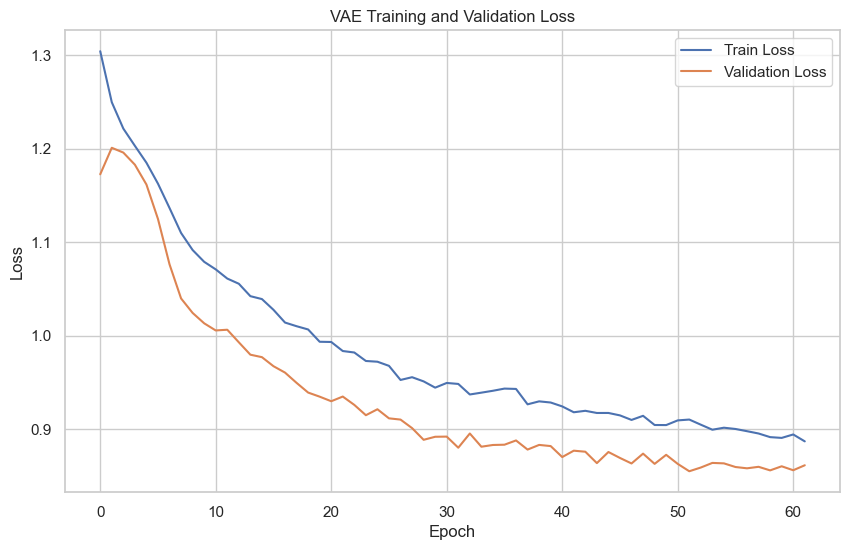

In [220]:

# Initialize VAE model
input_dim = X_train.shape[1]
hidden_dims = [1024, 512, 256]
latent_dim = 50
vae_model = EnhancedGeneVAE(
    input_dim=input_dim, 
    hidden_dims=hidden_dims, 
    latent_dim=latent_dim
).to(device)

# Initialize optimizer
optimizer = optim.AdamW(vae_model.parameters(), lr=1e-4, weight_decay=1e-4)

# Training parameters
epochs = 100
noise_factor = 0.05
beta = 1.0  # Weight of KL divergence term
alpha = 0.1  # Weight of L1 regularization
early_stopping_patience = 10

# Training loop
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0

print(f"Starting training on {device} with {input_dim} input features")
start_time = time.time()

for epoch in range(1, epochs + 1):
    # Training
    vae_model.train()
    train_loss = 0
    
    for batch_idx, data in enumerate(train_loader):
        data = data[0]  # Data is already on device from dataloader
        noisy_data = add_noise(data, noise_factor)
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae_model(noisy_data)
        loss = enhanced_loss_function(recon_batch, data, mu, logvar, beta, alpha)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(vae_model.parameters(), 1.0)  # Gradient clipping
        train_loss += loss.item() * data.size(0)  # Accumulate batch loss
        optimizer.step()
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation
    vae_model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for data in val_loader:
            data = data[0]  # Data is already on device
            recon_batch, mu, logvar = vae_model(data)
            val_loss += enhanced_loss_function(recon_batch, data, mu, logvar, beta, alpha).item() * data.size(0)
    
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    
    # Print progress
    if epoch % 10 == 0 or epoch == 1:
        print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        torch.save(vae_model.state_dict(), 'best_vae_model.pt')
    else:
        patience_counter += 1
        
    if patience_counter >= early_stopping_patience:
        print(f'Early stopping at epoch {epoch}')
        break

# Load the best model
vae_model.load_state_dict(torch.load('best_vae_model.pt'))

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Plot training curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('VAE Training and Validation Loss')
plt.grid(True)
plt.show()


## 6. Generate Latent Representations


In [221]:

def get_latent_representation(model, data):
    model.eval()
    
    # Convert data to tensor and move to device
    if isinstance(data, np.ndarray):
        data_tensor = torch.FloatTensor(data).to(device)
    else:
        data_tensor = data.to(device)
    
    dataset = TensorDataset(data_tensor)
    batch_size = 64
    loader = DataLoader(dataset, batch_size=batch_size)
    
    latent_vectors = []
    with torch.no_grad():
        for batch in loader:
            batch_data = batch[0] 
            mu, _ = model.encode(batch_data)
            latent_vectors.append(mu.cpu().numpy())
    
    return np.vstack(latent_vectors)

# Get latent representations for all data
print("Generating latent representations...")
all_data_scaled = scaler.transform(gene_expression_filtered)
all_data_tensor = torch.FloatTensor(all_data_scaled).to(device)
latent_vectors = get_latent_representation(vae_model, all_data_tensor)
print(f"Latent vectors shape: {latent_vectors.shape}")


Generating latent representations...
Latent vectors shape: (857, 50)



## 7. Visualize Latent Space with HRD Categories


Running UMAP dimensionality reduction...


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Running t-SNE dimensionality reduction...
Samples per HRD category:
HRD_Category
Low          816
Medium        25
High           1
Very High      0
Name: count, dtype: int64


<Figure size 1800x800 with 0 Axes>

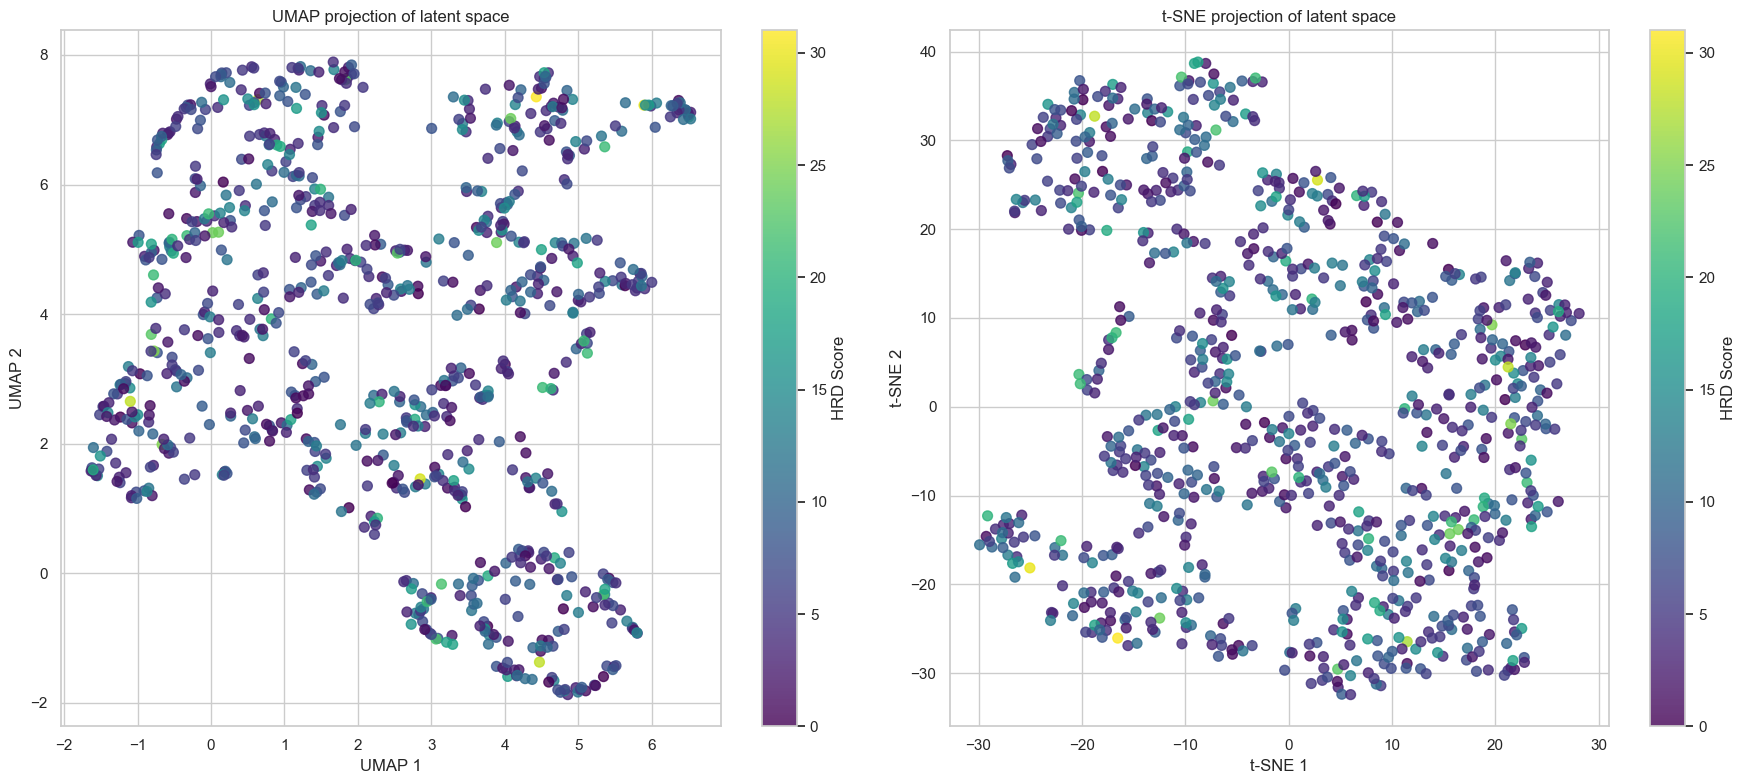

<Figure size 1800x800 with 0 Axes>

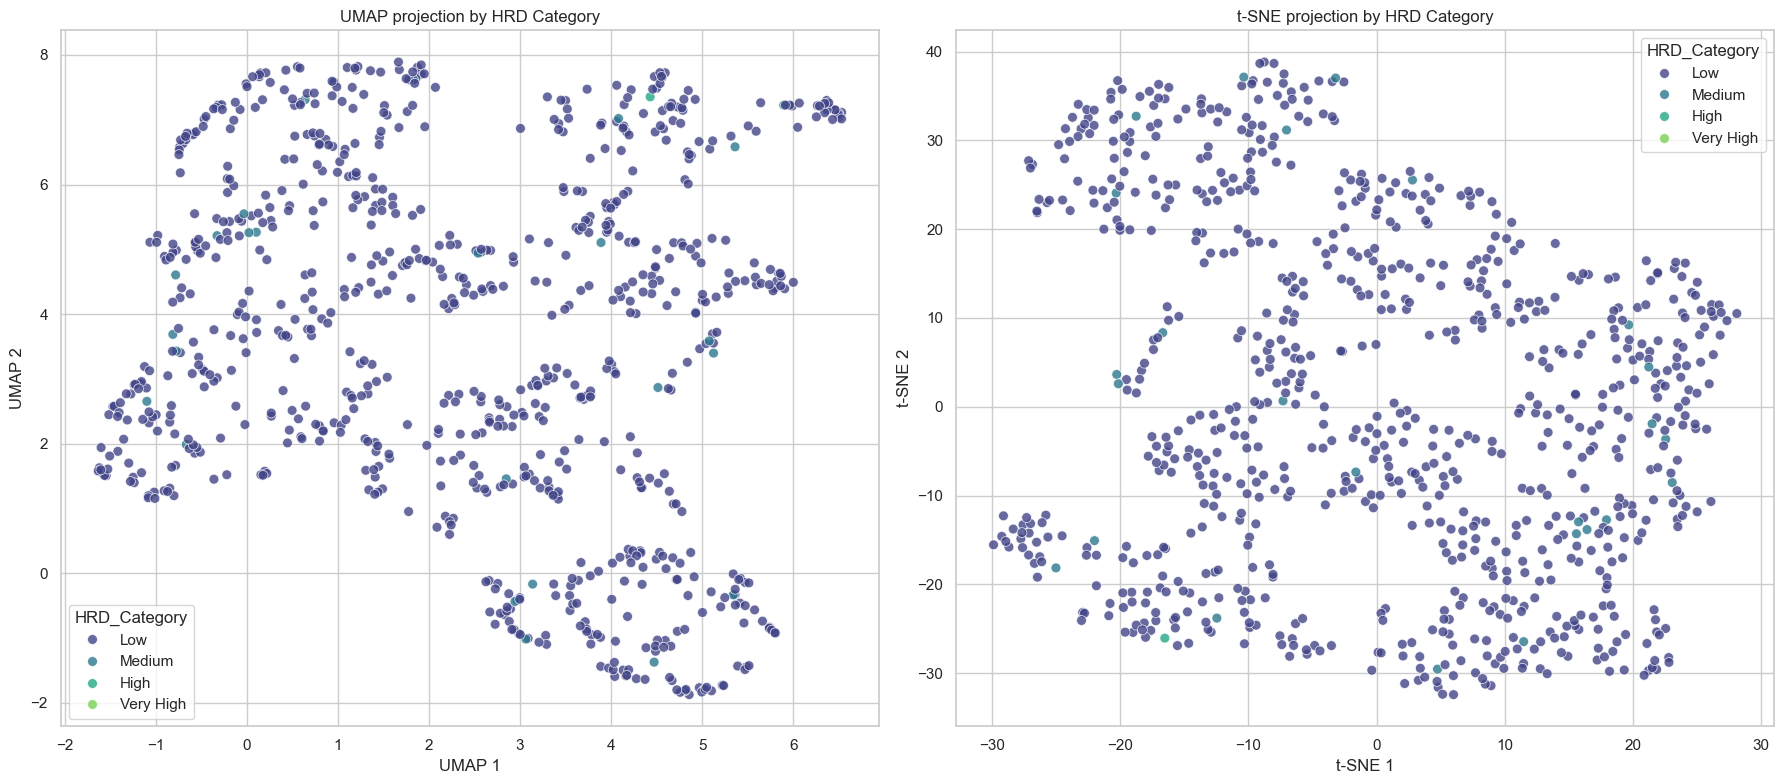

In [222]:

# UMAP reduction
print("Running UMAP dimensionality reduction...")
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_embedding = umap_reducer.fit_transform(latent_vectors)

# t-SNE reduction
print("Running t-SNE dimensionality reduction...")
tsne_reducer = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_embedding = tsne_reducer.fit_transform(latent_vectors)

# Create HRD bins
hrd_bins = [0, 20, 30, 42, 100]
hrd_labels = ['Low', 'Medium', 'High', 'Very High']


vis_df = pd.DataFrame({
    'UMAP_1': umap_embedding[:, 0],
    'UMAP_2': umap_embedding[:, 1],
    'tSNE_1': tsne_embedding[:, 0],
    'tSNE_2': tsne_embedding[:, 1],
    'HRD_Score': labels['HRD'].values
})
vis_df['HRD_Category'] = pd.cut(vis_df['HRD_Score'], bins=hrd_bins, labels=hrd_labels)

# Count samples in each category
category_counts = vis_df['HRD_Category'].value_counts().sort_index()
print("Samples per HRD category:")
print(category_counts)

# Plot with HRD scores (continuous coloring)
plt.figure(figsize=(18, 8))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Custom colormap
cmap = sns.color_palette("viridis", as_cmap=True)

# UMAP plot
scatter1 = ax1.scatter(vis_df['UMAP_1'], vis_df['UMAP_2'], 
                     c=vis_df['HRD_Score'], cmap=cmap, alpha=0.8, s=50)
plt.colorbar(scatter1, ax=ax1, label='HRD Score')
ax1.set_title('UMAP projection of latent space')
ax1.set_xlabel('UMAP 1')
ax1.set_ylabel('UMAP 2')

# t-SNE plot
scatter2 = ax2.scatter(vis_df['tSNE_1'], vis_df['tSNE_2'], 
                      c=vis_df['HRD_Score'], cmap=cmap, alpha=0.8, s=50)
plt.colorbar(scatter2, ax=ax2, label='HRD Score')
ax2.set_title('t-SNE projection of latent space')
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')

plt.tight_layout()
plt.show()

# Plot with HRD categories (categorical coloring)
plt.figure(figsize=(18, 8))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# UMAP with categories
sns.scatterplot(x='UMAP_1', y='UMAP_2', hue='HRD_Category', 
               data=vis_df, palette='viridis', ax=ax1, alpha=0.8, s=50)
ax1.set_title('UMAP projection by HRD Category')
ax1.set_xlabel('UMAP 1')
ax1.set_ylabel('UMAP 2')

# t-SNE with categories
sns.scatterplot(x='tSNE_1', y='tSNE_2', hue='HRD_Category', 
               data=vis_df, palette='viridis', ax=ax2, alpha=0.8, s=50)
ax2.set_title('t-SNE projection by HRD Category')
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')

plt.tight_layout()
plt.show()




## 8. Approach 1: Feature Importance using SHAP


Creating SHAP explainer with 100 background samples...
Calculating SHAP values for 50 test samples...


100%|██████████| 50/50 [58:43<00:00, 70.46s/it]  


SHAP calculation completed in 3523.03 seconds
SHAP values shape: (50, 400, 50)
Test samples shape: (50, 400)
SHAP values returned as a single array
Generating mean SHAP values plot across latent dimensions


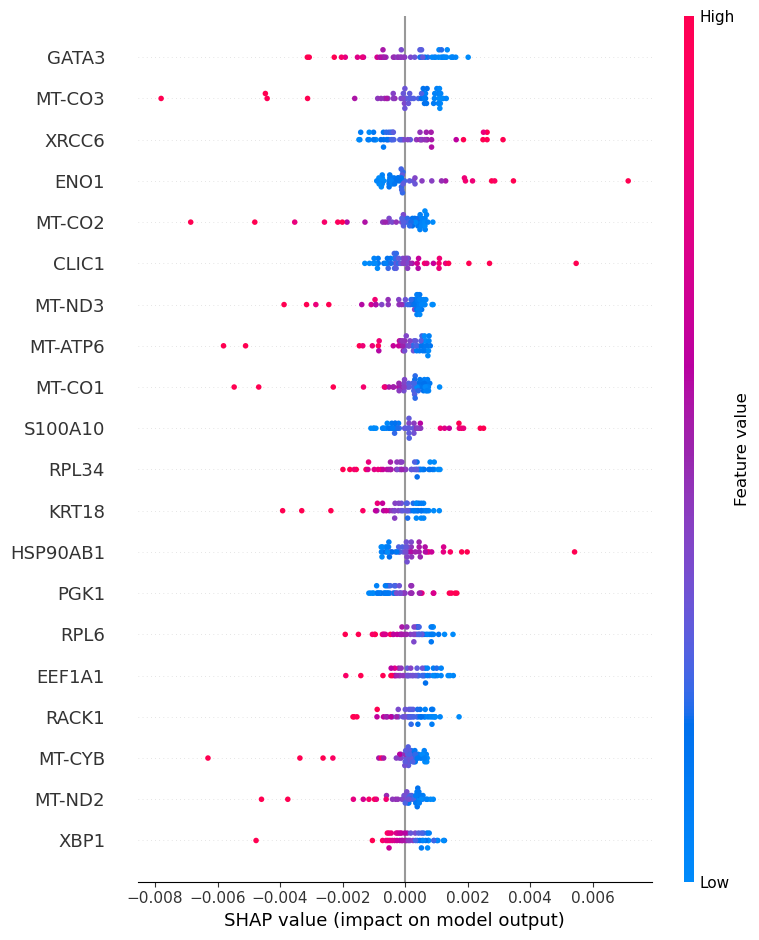

Generating SHAP plots for 5 individual latent dimensions


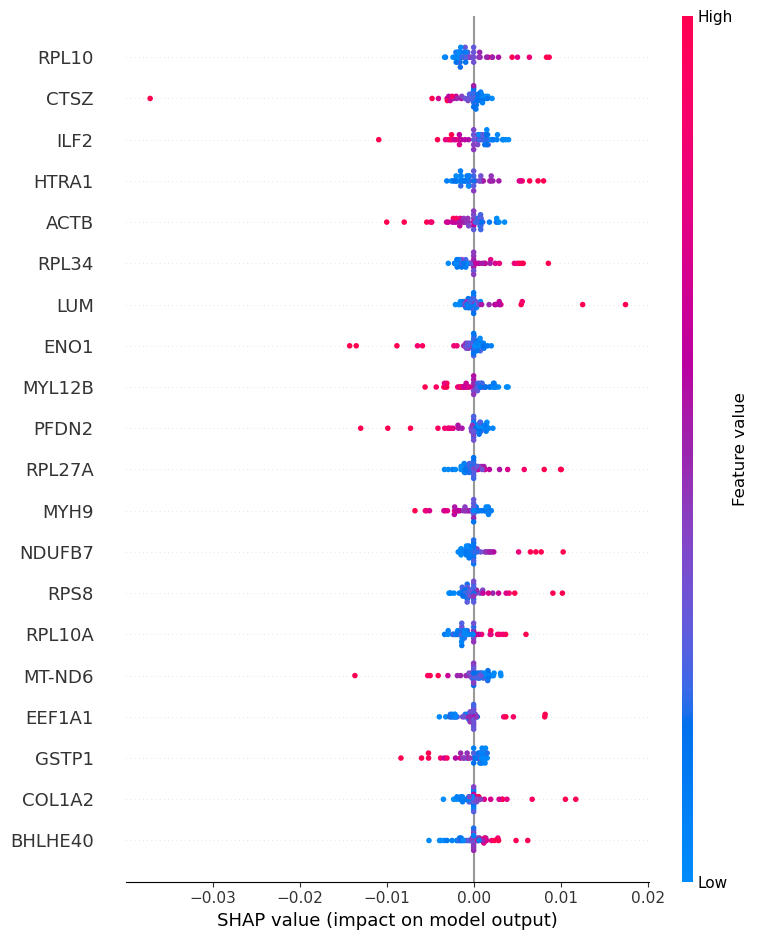

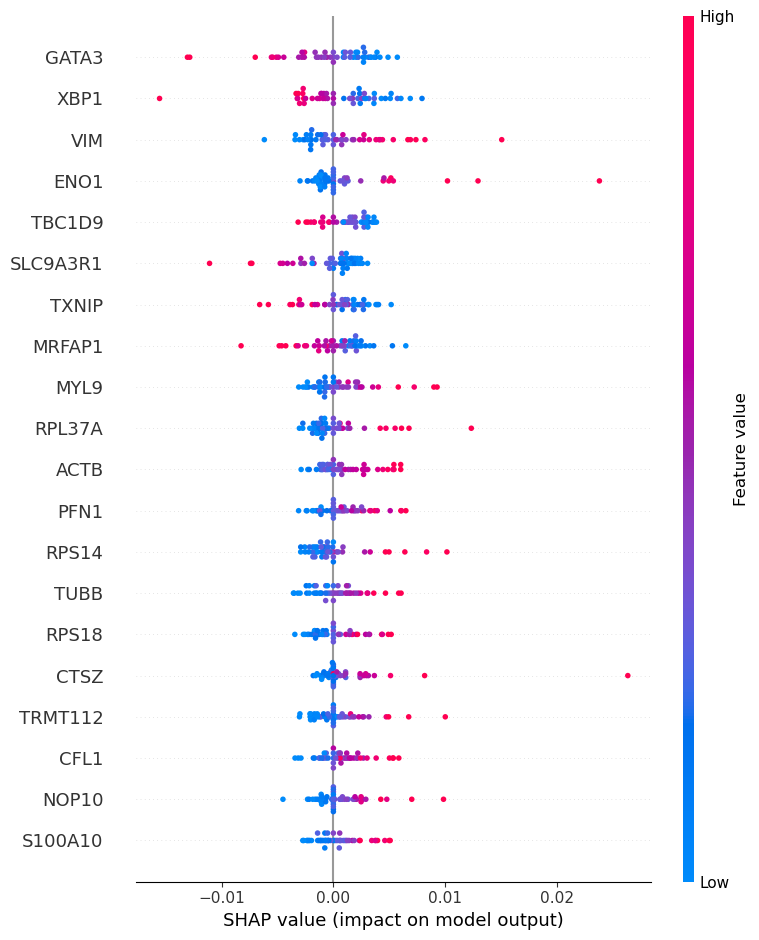

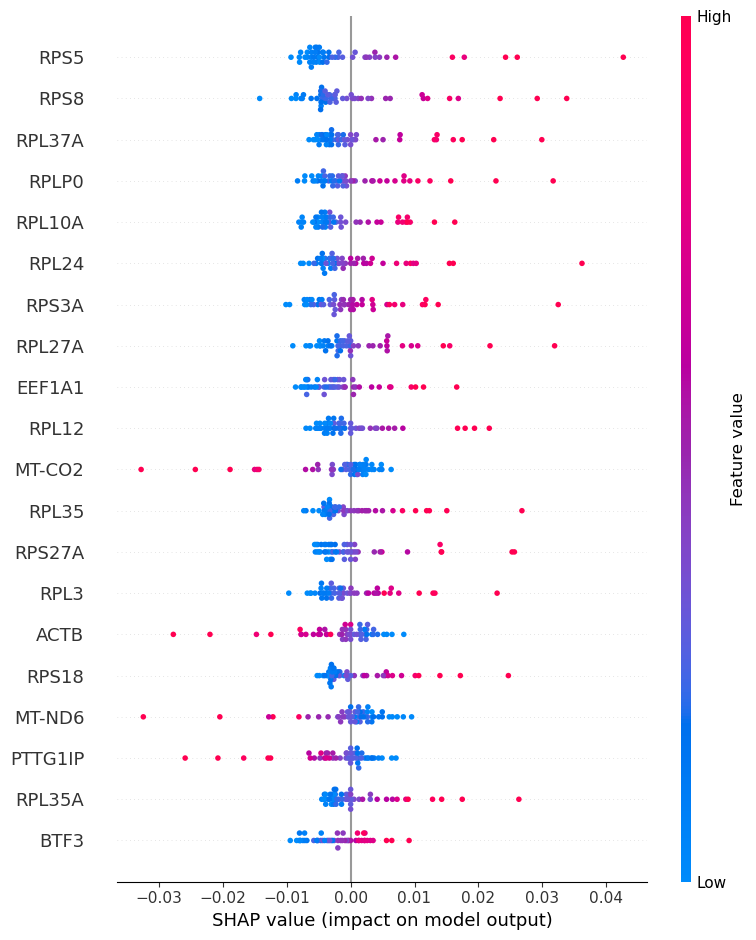

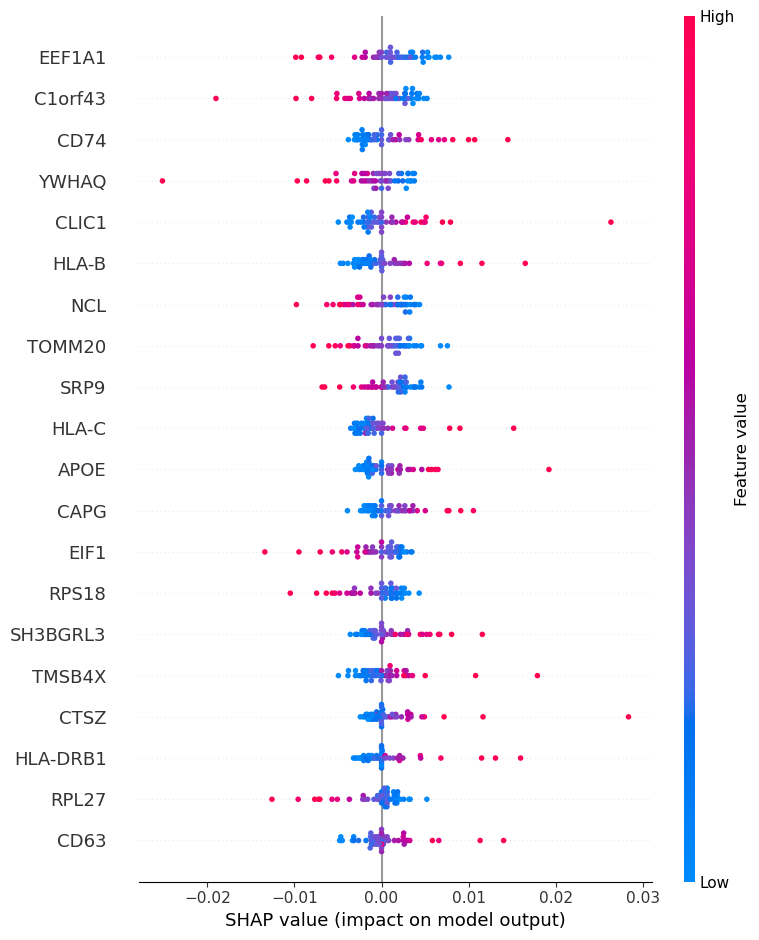

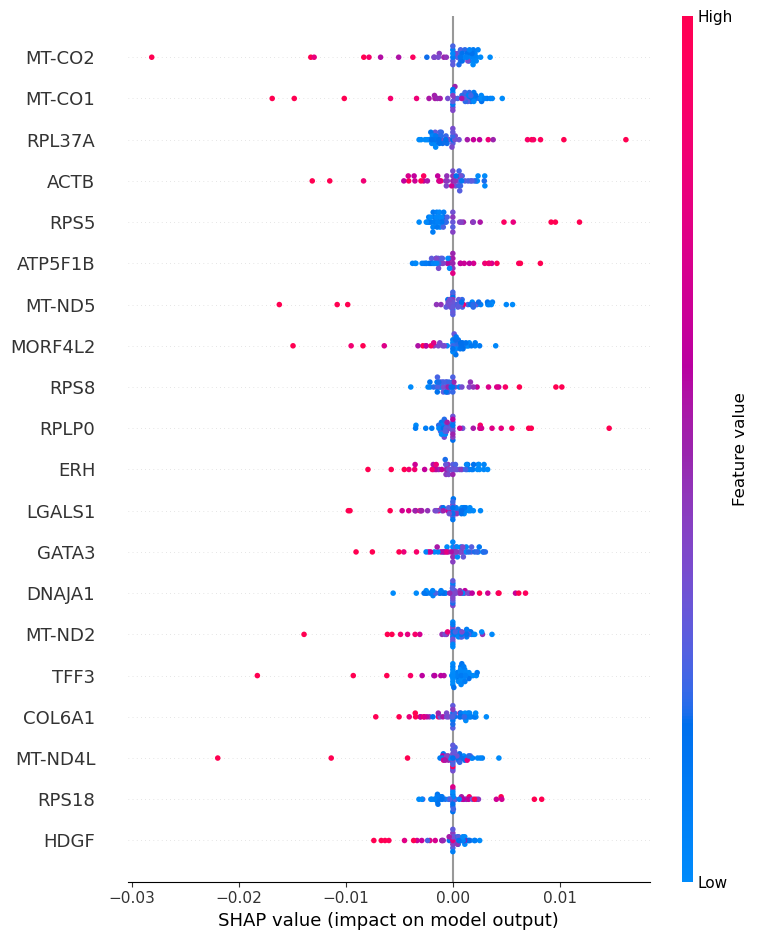

SHAP visualization completed. All plots saved as PNG files.


In [ ]:
class LatentEncoder:
    def __init__(self, model, device, input_dim):
        self.model = model
        self.device = device
        self.input_dim = input_dim
        
    def __call__(self, X):
        # Convert to tensor
        batch_size = X.shape[0]
        X_tensor = torch.FloatTensor(X.reshape(batch_size, self.input_dim)).to(self.device)
        # Get latent representation
        self.model.eval()
        with torch.no_grad():
            mu, _ = self.model.encode(X_tensor)
        # Return as numpy on CPU
        return mu.cpu().numpy()


latent_encoder = LatentEncoder(vae_model, device, input_dim)

shap_background_size = 100
background_data = X_train[:shap_background_size]
print(f"Creating SHAP explainer with {shap_background_size} background samples...")

explainer = shap.KernelExplainer(latent_encoder, background_data)

# Calculate SHAP values for a subset of samples
shap_test_size = 50
test_samples = X_val[:shap_test_size]
print(f"Calculating SHAP values for {shap_test_size} test samples...")
start_time = time.time()

shap_values = explainer.shap_values(test_samples)
shap_time = time.time() - start_time
print(f"SHAP calculation completed in {shap_time:.2f} seconds")

np.save('shap_values.npy', shap_values)
np.save('test_samples.npy', test_samples)

print(f"SHAP values shape: {np.array(shap_values).shape}")
print(f"Test samples shape: {test_samples.shape}")

if len(gene_names) != test_samples.shape[1]:
    print(f"Warning: Number of gene names ({len(gene_names)}) does not match feature count ({test_samples.shape[1]})")
    gene_names = [f"Gene_{i}" for i in range(test_samples.shape[1])]

if isinstance(shap_values, list):
    print("SHAP values returned as a list (one per latent dimension)")
    print("Generating mean absolute SHAP values plot across all latent dimensions")
    mean_shap_values = np.mean([np.abs(shap_val) for shap_val in shap_values], axis=0)
    plt.figure(figsize=(12, 10))
    shap.summary_plot(mean_shap_values, test_samples, feature_names=gene_names)
    plt.savefig('shap_summary_mean_across_latent_dims.png')
    plt.close()
    
    selected_dims = min(5, len(shap_values))
    print(f"Generating SHAP plots for {selected_dims} individual latent dimensions")
    for dim in range(selected_dims):
        plt.figure(figsize=(12, 8))
        shap.summary_plot(
            shap_values[dim],
            test_samples,
            feature_names=gene_names,
            title=f"SHAP values for latent dimension {dim}"
        )
        plt.savefig(f'shap_summary_latent_dim_{dim}.png')
        plt.close()
else:
    print("SHAP values returned as a single array")
    
    print("Generating mean SHAP values plot across latent dimensions")
    mean_shap_values = np.mean(shap_values, axis=2)
    plt.figure(figsize=(12, 10))
    shap.summary_plot(mean_shap_values, test_samples, feature_names=gene_names)
    plt.savefig('shap_summary_mean_across_latent_dims.png')
    plt.close()
    
    latent_dims = min(5, shap_values.shape[2])
    print(f"Generating SHAP plots for {latent_dims} individual latent dimensions")
    for dim in range(latent_dims):
        plt.figure(figsize=(12, 8))
        shap.summary_plot(
            shap_values[:, :, dim],
            test_samples,
            feature_names=gene_names,
            title=f"SHAP values for latent dimension {dim}"
        )
        plt.savefig(f'shap_summary_latent_dim_{dim}.png')
        plt.close()

print("SHAP visualization completed. All plots saved as PNG files.")



## 9. Approach 2: Feature Importance using Sparse Autoencoder


Training sparse autoencoder with 50 input and 150 sparse features
Sparse AE Epoch 1: Loss: 0.5362
Sparse AE Epoch 10: Loss: 0.0251
Sparse AE Epoch 20: Loss: 0.0173
Sparse AE Epoch 30: Loss: 0.0139
Sparse AE Epoch 40: Loss: 0.0120
Sparse AE Epoch 50: Loss: 0.0108
Sparse autoencoder training completed in 4.29 seconds


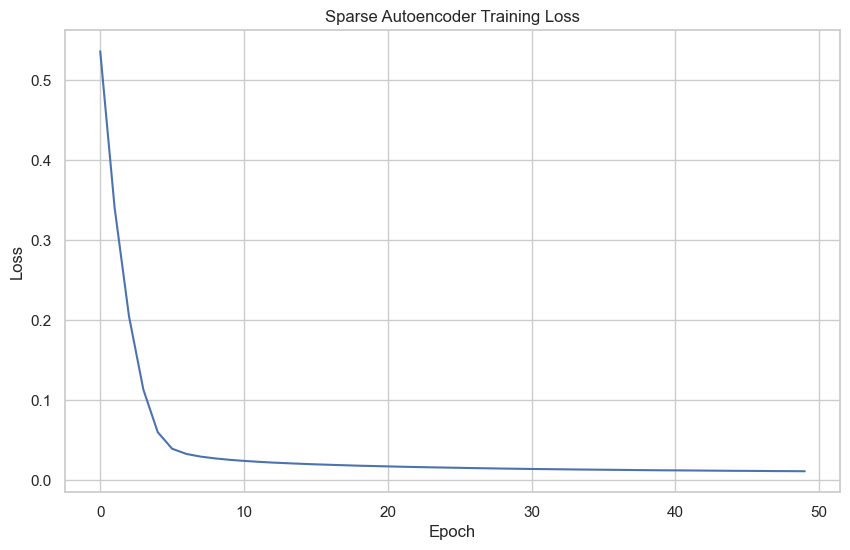

Sparse features shape: (857, 150)


In [223]:

class SparseAutoencoder(nn.Module):
    def __init__(self, latent_dim, sparse_dim, l1_reg=0.001):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Linear(latent_dim, sparse_dim)
        self.decoder = nn.Linear(sparse_dim, latent_dim)
        self.l1_reg = l1_reg
        
    def forward(self, x):
        encoded = F.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return decoded
    
    def get_sparse_features(self, x):
        return F.relu(self.encoder(x))

def sparse_loss(y_true, y_pred, model, l1_reg=0.001):
    mse_loss = F.mse_loss(y_pred, y_true)
    l1_loss = l1_reg * torch.sum(torch.abs(model.encoder.weight))
    return mse_loss + l1_loss

latent_dim = latent_vectors.shape[1]
sparse_dim = latent_dim * 3
l1_reg = 0.001

print(f"Training sparse autoencoder with {latent_dim} input and {sparse_dim} sparse features")
sparse_ae = SparseAutoencoder(latent_dim, sparse_dim, l1_reg).to(device)
sparse_optimizer = optim.Adam(sparse_ae.parameters(), lr=1e-3)

latent_tensor = torch.FloatTensor(latent_vectors).to(device)
latent_dataset = TensorDataset(latent_tensor)
latent_loader = DataLoader(latent_dataset, batch_size=32, shuffle=True)

sparse_epochs = 50
sparse_train_losses = []

start_time = time.time()
for epoch in range(1, sparse_epochs + 1):
    sparse_ae.train()
    train_loss = 0
    
    for batch_idx, data in enumerate(latent_loader):
        data = data[0]
        
        sparse_optimizer.zero_grad()
        reconstructed = sparse_ae(data)
        loss = sparse_loss(data, reconstructed, sparse_ae, l1_reg)
        
        loss.backward()
        train_loss += loss.item() * data.size(0)
        sparse_optimizer.step()
    
    train_loss /= len(latent_loader.dataset)
    sparse_train_losses.append(train_loss)
    
    if epoch % 10 == 0 or epoch == 1:
        print(f'Sparse AE Epoch {epoch}: Loss: {train_loss:.4f}')

sparse_time = time.time() - start_time
print(f"Sparse autoencoder training completed in {sparse_time:.2f} seconds")

# Plot training curve
plt.figure(figsize=(10, 6))
plt.plot(sparse_train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Sparse Autoencoder Training Loss')
plt.grid(True)
plt.show()

# Extract sparse features
sparse_ae.eval()
with torch.no_grad():
    sparse_features = sparse_ae.get_sparse_features(latent_tensor).cpu().numpy()

print(f"Sparse features shape: {sparse_features.shape}")


In [224]:
# increase the input latent dimension size from 50 to 100/150? and also maybe the number of sparse features

In [225]:

# Calculate sparsity metrics
sparsity = (sparse_features == 0).mean() * 100
print(f"Sparsity of encoded features: {sparsity:.2f}%")



Sparsity of encoded features: 15.36%


In [226]:
sparse_ae_weights = sparse_ae.encoder.weight.data.cpu().numpy()
vae_encoder_weights = vae_model.fc_mu.weight.data.cpu().numpy()

print("Analyzing sparse feature importance...")
feature_importance = {}

for i in range(sparse_dim):
    # Get weights for this sparse feature
    sparse_to_latent = sparse_ae.decoder.weight[:, i].cpu().detach().numpy()
    
    # Multiply with VAE encoder weights to get effect on original genes
    # maps: sparse feature -> latent space -> original genes
    gene_importance = np.abs(np.dot(vae_encoder_weights.T, sparse_to_latent))
    
    # Map to gene names
    feature_importance[i] = dict(zip(gene_names, gene_importance))

# Find top genes for each sparse feature
top_genes_per_feature = {}
for feature_idx, gene_scores in feature_importance.items():
    # Sort genes by importance score
    sorted_genes = sorted(gene_scores.items(), key=lambda x: x[1], reverse=True)
    # Keep top 10 genes
    top_genes_per_feature[feature_idx] = sorted_genes[:10]

feature_activations = sparse_features.mean(axis=0)
top_activated_features = np.argsort(feature_activations)[-5:]

print("\nTop genes for most activated sparse features:")
for i, feature_idx in enumerate(top_activated_features):
    print(f"\nSparse feature {feature_idx} (activation: {feature_activations[feature_idx]:.4f}):")
    for gene, score in top_genes_per_feature[feature_idx]:
        print(f"  {gene}: {score:.4f}")



Analyzing sparse feature importance...

Top genes for most activated sparse features:

Sparse feature 140 (activation: 0.3167):
  TAGLN2: 0.0545
  SPARC: 0.0524
  RPS27A: 0.0520
  UBC: 0.0518
  RPL19: 0.0440
  CPB1: 0.0416
  MT2A: 0.0406
  SCD: 0.0397
  PDIA3: 0.0392
  MYL12B: 0.0378

Sparse feature 0 (activation: 0.3235):
  S100A10: 0.1189
  RPS21: 0.1168
  DCD: 0.1087
  MT-CYB: 0.1086
  GNAS: 0.1086
  BSG: 0.0946
  RPL12: 0.0942
  COL6A2: 0.0925
  RPL7: 0.0906
  EFHD1: 0.0875

Sparse feature 121 (activation: 0.3420):
  CXCL14: 0.1668
  EFHD1: 0.1523
  TFF3: 0.1488
  RPS21: 0.1456
  S100A11: 0.1394
  CARTPT: 0.1376
  HLA-A: 0.1293
  RPS2: 0.1260
  MT-CYB: 0.1257
  GPX1: 0.1238

Sparse feature 24 (activation: 0.3455):
  LGALS1: 0.1755
  ATP6V0E1: 0.1626
  TMSB10: 0.1436
  TSPAN13: 0.1430
  CCND1: 0.1304
  TFF3: 0.1292
  UBC: 0.1247
  HLA-C: 0.1176
  RPS24: 0.1163
  CCN2: 0.1162

Sparse feature 126 (activation: 0.3557):
  LGALS1: 0.1176
  CHMP4B: 0.0885
  TMSB10: 0.0865
  PTMS: 0.0827
 

In [227]:
gene_overall_importance = {gene: 0 for gene in gene_names}

for feature_idx, gene_scores in feature_importance.items():
    activation = feature_activations[feature_idx]
    for gene, score in gene_scores.items():
        gene_overall_importance[gene] += score * activation

sparse_importance_df = pd.DataFrame({
    'Gene': list(gene_overall_importance.keys()),
    'Sparse_AE_Importance': list(gene_overall_importance.values())
})
sparse_importance_df = sparse_importance_df.sort_values('Sparse_AE_Importance', ascending=False)


print("\nTop 20 genes by Sparse Autoencoder importance:")
print(sparse_importance_df.head(255))
sparse_importance_df.to_csv('data/sparse_importance_2.csv', index=False)



Top 20 genes by Sparse Autoencoder importance:
        Gene  Sparse_AE_Importance
103   NDUFS5              0.888243
138  S100A10              0.848370
68     RPS21              0.838844
73    LGALS1              0.832928
123   TMBIM6              0.789145
..       ...                   ...
193     EIF1              0.270963
236    RPL31              0.269061
36     RPS4X              0.265738
51      RPL3              0.265010
202   MRFAP1              0.163461

[255 rows x 2 columns]


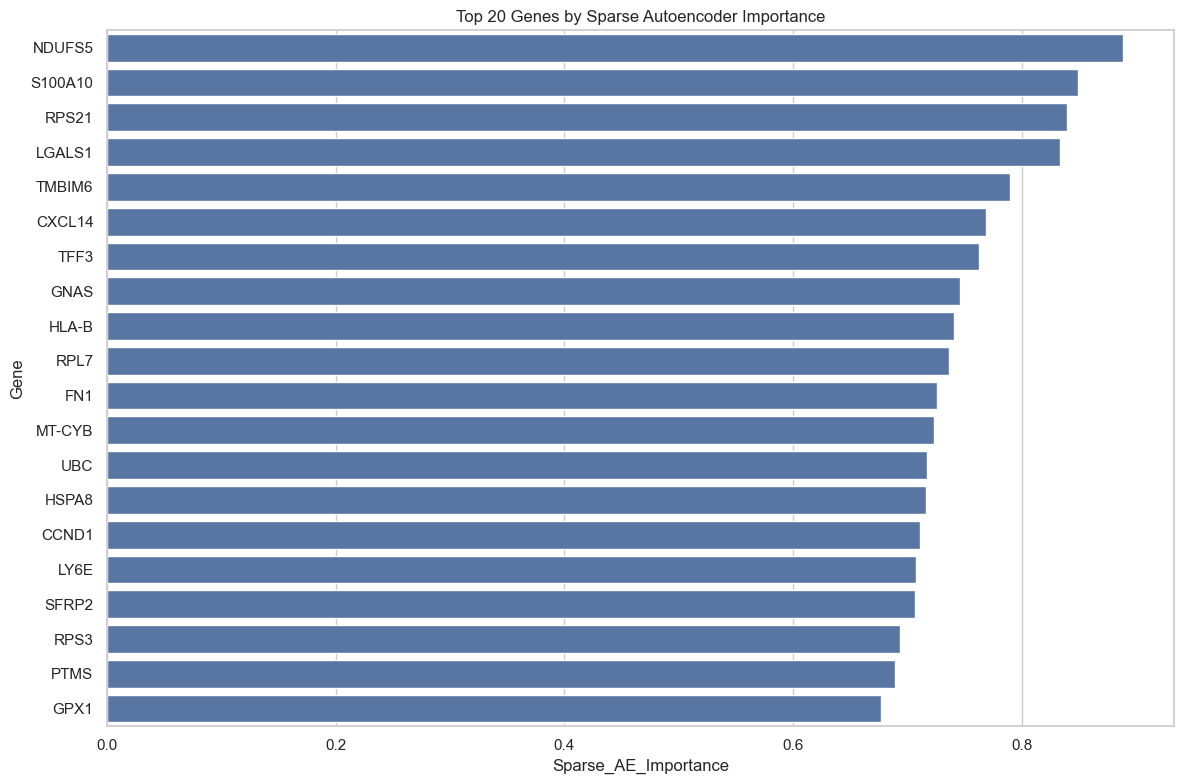

In [229]:

# Visualize top genes
plt.figure(figsize=(12, 8))
sns.barplot(x='Sparse_AE_Importance', y='Gene', data=sparse_importance_df.head(20))
plt.title('Top 20 Genes by Sparse Autoencoder Importance')
plt.tight_layout()
plt.show()


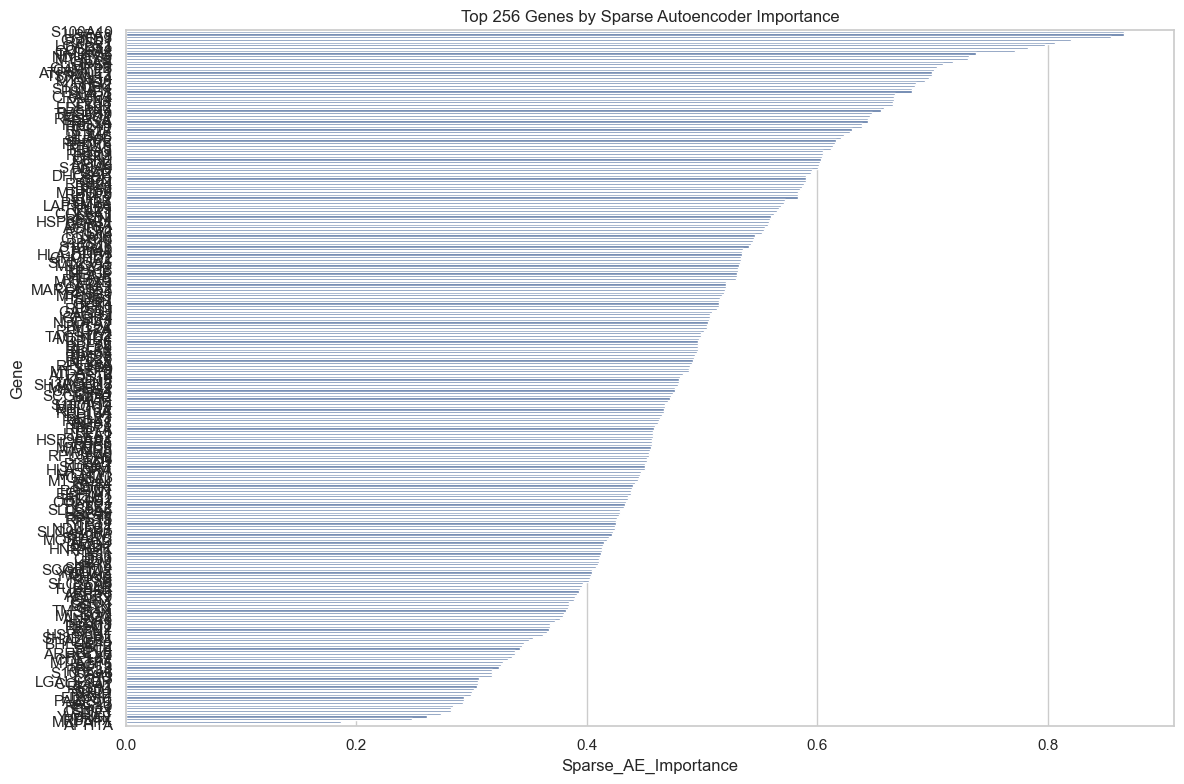

In [285]:
sparse_importance_df = pd.read_csv('data/sparse_importance.csv')
# Visualize top genes
plt.figure(figsize=(12, 8))
sns.barplot(x='Sparse_AE_Importance', y='Gene', data=sparse_importance_df.head(256))
plt.title('Top 256 Genes by Sparse Autoencoder Importance')
plt.tight_layout()
plt.show()


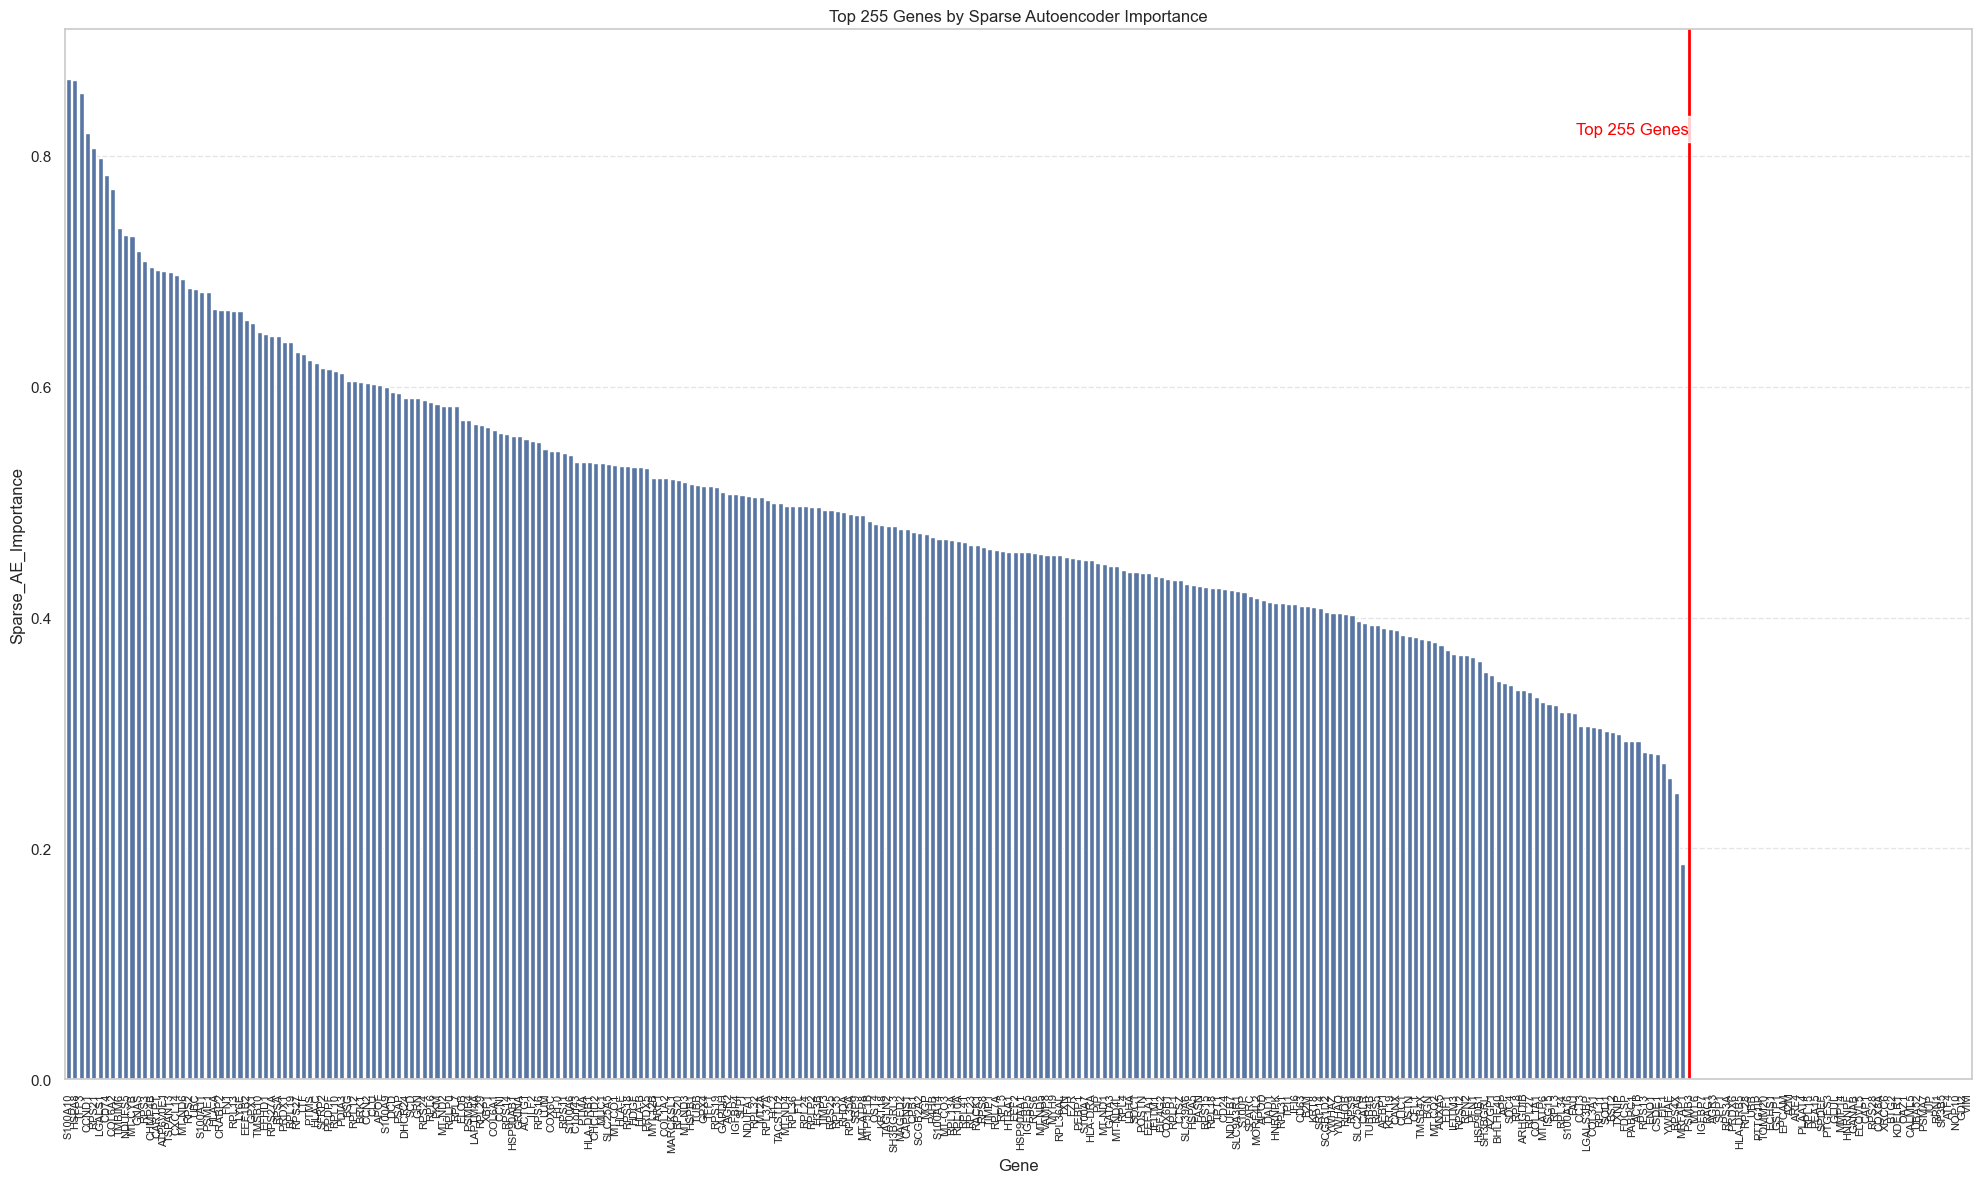

In [297]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
sparse_importance_df = pd.read_csv('data/sparse_importance.csv')

# Sort by importance (in case it's not already sorted)
sparse_importance_df = sparse_importance_df.sort_values('Sparse_AE_Importance', ascending=False).reset_index(drop=True)

# Get top 300 genes
top_genes = sparse_importance_df.head(300)

# Create the plot with original structure but improved readability
plt.figure(figsize=(20, 12))  # Wider figure to accommodate rotated labels

# Create the vertical barplot
ax = sns.barplot(x='Gene', y='Sparse_AE_Importance', data=top_genes)

# Rotate x-axis labels 90 degrees and adjust positioning
plt.xticks(rotation=90, fontsize=8, ha='center')

# Keep your original title and axes labels
plt.title('Top 255 Genes by Sparse Autoencoder Importance')
plt.ylabel('Sparse_AE_Importance')
plt.xlabel('Gene')

# Add gridlines to help track values
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add a vertical line after the 255th gene (at position 255, which is the 256th gene)
plt.axvline(x=255, color='red', linestyle='-', linewidth=2)

# Add annotation for the line
plt.text(255, top_genes['Sparse_AE_Importance'].max() * 0.95, 
         'Top 255 Genes', 
         fontsize=12, 
         color='red', 
         ha='right', 
         va='center',
         bbox=dict(facecolor='white', alpha=0.8))

# Add some bottom padding to make sure rotated labels fit
plt.subplots_adjust(bottom=0.3)

# Make sure everything fits
plt.tight_layout()

plt.savefig('gene_plot_with_vertical_line.png', dpi=300, bbox_inches='tight')

# Using VAE & SAE To Make Predictions on HRD values for Breast Cancer

In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import plotly.express as px

# ***Initial Data import: RNA-seq, HRD scores, BRCA annotations***

In [235]:
# Load the FPKM RNA-seq data
rnaseq_df = pd.read_csv('data/tcga.brca.rnaseq.unstranded.fpkm.counts.matrix.txt', sep='\t', index_col=0)
# Load the HRD score data
hrd_df = pd.read_excel('data/tcga.hrdscore.xlsx')

# Load the BRCA status data
brca_df = pd.read_csv('data/toga.breast.brca.status.txt', sep='\t', index_col=0)
brca_df.index = brca_df.index.str.replace('.', '-')

In [236]:
print(f"Initial samples in RNA-seq data (n = {len(rnaseq_df.index)}) \n\nInitial samples in TCGA BRCA (n = {len(brca_df.index)})\n\nInitial samples in TCGA HRD (n = {len(hrd_df.index)})\n\n")

Initial samples in RNA-seq data (n = 1231) 

Initial samples in TCGA BRCA (n = 992)

Initial samples in TCGA HRD (n = 9604)




# ***Drop ambiguouse/ mislabled samples***

In [237]:
# Drop rows where event.BRCA1 is '1' and event.BRCA2 is 'Bi-allelic-undetermined' and where event.PALB2 is '2'
brca_filt = brca_df[(brca_df['event.BRCA1'] != '1') & (brca_df['event.BRCA2'] != 'Bi-allelic-undetermined') & (brca_df['event.PALB2'] != '2')]
brca_filt.shape

(984, 33)

# ***Merge metadata***

In [238]:
#merge metadata

metadata = pd.merge(hrd_df, brca_filt, left_on='sample', right_index=True)
metadata.set_index('sample', inplace=True)

print (metadata.shape)


(859, 37)


# Keep Protein coding columns + extracting gene IDs
## filter only Primary Tumor Samples

In [239]:
rnaseq_df.shape

(1231, 60663)

In [240]:
#filt protein coding only
columns_to_keep = ['Case ID', 'Sample ID', 'Sample Type']
# columns_to_keep =[]
gene_columns = [col for col in rnaseq_df.columns if col not in columns_to_keep]
protein_coding_cols = [col for col in gene_columns if 'protein_coding' in col]
final_columns = columns_to_keep + protein_coding_cols
pcg_rnaseq_df_filtered = rnaseq_df[final_columns]

#filt only primary tumor
pcg_rnaseq_df_filtered = pcg_rnaseq_df_filtered[pcg_rnaseq_df_filtered['Sample Type'] == 'Primary Tumor']
print(pcg_rnaseq_df_filtered.shape)
#Slicing gene names
# split 0 for enseble ID, 1 for gene ID
#sliced_cols = [col.split('|')[1] for col in pcg_rnaseq_df_filtered.columns[3:]]
sliced_cols = [col.split('|')[1] for col in pcg_rnaseq_df_filtered.columns[3:]]

pcg_rnaseq_df_filtered.columns = columns_to_keep+sliced_cols
pcg_rnaseq_df_filtered.set_index('Case ID', inplace=True)


(1111, 19965)


In [241]:
pcg_rnaseq_df_filtered.shape

(1111, 19964)

# ***Get Intersecting samples***

In [242]:
#idenfity the common samples

# Extract sample IDs from each dataframe
rnaseq_samples = set(pcg_rnaseq_df_filtered.index)
metadata_samples = set(metadata.index)

# Find the intersection of all sample IDs
common_samples = rnaseq_samples.intersection(metadata_samples)

# Print the number of common samples
print("\nNumber of common samples:", len(common_samples))


Number of common samples: 857


In [243]:
# Drop samples that are not common in all three dataframes
gene_expression = pcg_rnaseq_df_filtered[pcg_rnaseq_df_filtered.index.isin(common_samples)]
labels = metadata[metadata.index.isin(common_samples)]

# Print the shapes of the new dataframes
print("pcg_rnaseq_df_filtered:", gene_expression.shape)
print("metadata_common:", labels.shape)

pcg_rnaseq_df_filtered: (857, 19964)
metadata_common: (857, 37)


# ***Apply Soft Labels***

In [244]:
# Soft label method
def softLabel(x, median, HRD_thresh, HRP_thresh):
    adjustment = 2 * ((((HRD_thresh - x) / (HRD_thresh - HRP_thresh))-0.5) ** 2)+0.5
    if x < HRP_thresh:
        return 0
    elif x >= HRD_thresh:
        return 1
    elif median <= x < HRD_thresh:
        return min(adjustment, 1)
    elif HRP_thresh <= x < median:
        return max(1 - adjustment,0)

In [245]:
softLabel_metadata = labels.copy()
softLabel_metadata['HRD_status_base'] = softLabel_metadata['HRD-sum'].apply(lambda x: 'HRD' if x >= 42 else 'HR')
total_median = softLabel_metadata['HRD-sum'].median()
softLabel_metadata['HRD_adjust'] = ['HRD' if x >= 50 else 'HRP' if x <= 10 else 'HRD ambiguous' if total_median <= x <50 else 'HRP ambiguous' if 10 <= x < total_median else 'None' for x in softLabel_metadata['HRD-sum']]
softLabel_metadata['soft prob'] = softLabel_metadata['HRD-sum'].apply(lambda x: softLabel(x, 30, 50, 10))
softLabel_metadata = softLabel_metadata.rename_axis('Case ID', axis='index')

In [246]:
px.scatter(softLabel_metadata, x = 'HRD-sum', y = 'soft prob')

# ***Get DESeq2 Genes***

In [247]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import matplotlib.pyplot as plt
import seaborn as sns
import decoupler as dc


In [248]:
def runDESeq2(counts, metadata, design_factors):
    # Make gene names unique before creating DESeqDataSet
    counts = counts.copy()
    counts.columns = pd.Index(counts.columns).str.split('_').str[0] + '_' + pd.Series(range(len(counts.columns))).astype(str)
    
    # Create the DESeqDataSet object
    dds = DeseqDataSet(
        counts=counts,
        metadata=metadata,
        design_factors=design_factors,
    )
    
    # Run the differential expression analysis
    dds.deseq2()
    
    # Get the results
    stats = DeseqStats(dds)
    stats.summary()
    results = stats.results_df
    
    return results


In [249]:
# cast expression to int
gene_expression_int = gene_expression.iloc[:,2:].round().astype(int)
#gene_expression_int

softLabel_metadata = softLabel_metadata.sort_index()
gene_expression_int = gene_expression_int.sort_index()

In [250]:
print(gene_expression_int.index.equals(softLabel_metadata.index))  # Should return True


True


In [251]:
# Check for duplicate indices in counts dataframe
print(gene_expression_int.index.duplicated().sum())

# Check for duplicate indices in metadata dataframe
print(softLabel_metadata.index.duplicated().sum())


0
0


In [252]:
# First, let's do a comprehensive data check
def check_deseq2_data(counts_df, metadata_df, design_factor):
    print("Data Validation Report:")
    print("-" * 50)
    
    # Check basic dimensions
    print(f"Counts matrix shape: {counts_df.shape}")
    print(f"Metadata shape: {metadata_df.shape}")
    
    # Check indices
    print("\nIndex Analysis:")
    print(f"Counts index is unique: {counts_df.index.is_unique}")
    print(f"Metadata index is unique: {metadata_df.index.is_unique}")
    
    # Check for index overlap
    common_indices = counts_df.index.intersection(metadata_df.index)
    print(f"\nNumber of matching indices: {len(common_indices)}")
    print(f"Expected number of samples: {len(metadata_df)}")
    
    # Check design factor
    print(f"\nDesign factor '{design_factor}' distribution:")
    print(metadata_df[design_factor].value_counts())
    
    # Check for any zero-variance genes
    zero_var_genes = (counts_df == 0).all()
    print(f"\nNumber of zero-variance genes: {zero_var_genes.sum()}")
    
    return common_indices

# Run the checks
common_idx = check_deseq2_data(gene_expression_int, softLabel_metadata, 'HRD_status_base')

# Prepare the data ensuring perfect alignment
def prepare_deseq2_data(counts_df, metadata_df, common_indices):
    # Subset both dataframes to common indices
    counts_aligned = counts_df.loc[common_indices]
    metadata_aligned = metadata_df.loc[common_indices]
    
    # Verify alignment
    assert counts_aligned.index.equals(metadata_aligned.index), "Indices not aligned"
    assert counts_aligned.index.is_unique, "Duplicate indices present"
    
    return counts_aligned, metadata_aligned

# Prepare aligned data
gene_expression_aligned, softLabel_metadata_aligned = prepare_deseq2_data(
    gene_expression_int, 
    softLabel_metadata,
    common_idx
)

Data Validation Report:
--------------------------------------------------
Counts matrix shape: (857, 19962)
Metadata shape: (857, 40)

Index Analysis:
Counts index is unique: True
Metadata index is unique: True

Number of matching indices: 857
Expected number of samples: 857

Design factor 'HRD_status_base' distribution:
HRD_status_base
HR     652
HRD    205
Name: count, dtype: int64

Number of zero-variance genes: 2166


In [253]:
basic = runDESeq2(gene_expression_aligned, softLabel_metadata_aligned, 'HRD_status_base')

/var/folders/tx/vgccmrkj1fz1zv99j496_3k80000gn/T/ipykernel_4476/4064001399.py:7: UserWarning:

Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').

Fitting size factors...
... done in 0.32 seconds.

Fitting dispersions...
... done in 3.11 seconds.

Fitting dispersion trend curve...
... done in 0.47 seconds.

Fitting MAP dispersions...
... done in 4.29 seconds.

Fitting LFCs...
... done in 1.34 seconds.

Calculating cook's distance...
... done in 1.25 seconds.

Replacing 747 outlier genes.

Fitting dispersions...
... done in 0.13 seconds.

Fitting MAP dispersions...
... done in 0.15 seconds.

Fitting LFCs...
... done in 0.10 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: HRD-status-base HRD vs HR
                   baseMean  log2FoldChange     lfcSE      stat        pvalue  \
TSPAN6_0          12.265658        0.088258  0.078558  1.123469  2.612382e-01   
TNMD_1             0.375812       -0.555440  0.340749 -1.630057  1.030895e-01   
DPM1_2            36.942920        0.378305  0.044770  8.449978  2.913575e-17   
SCYL3_3            4.385599       -0.295746  0.058748 -5.034134  4.800128e-07   
C1orf112_4         2.313620        0.543328  0.070702  7.684798  1.532388e-14   
...                     ...             ...       ...       ...           ...   
AL451106.1_19957   0.000000             NaN       NaN       NaN           NaN   
AC008763.4_19958   0.000000             NaN       NaN       NaN           NaN   
AC006486.3_19959   0.000000             NaN       NaN       NaN           NaN   
AL391628.1_19960   0.000000             NaN       NaN       NaN           NaN   
AP006621.6_19961   0.221629       -0.234714  

... done in 0.73 seconds.



In [254]:
#basic_filt = basic[(basic["padj"] <= 0.01) & ((basic["log2FoldChange"] >= 1) | (basic["log2FoldChange"] <= -1))]
basic_filt = basic[basic["padj"] <= 0.01]

In [255]:
basic_filt.shape

(8071, 6)

# Overlap DESeq2 genes with RNA seq

In [256]:
de_genes = [gene.split('_')[0] for gene in basic_filt.index]
len(de_genes)

8071

In [257]:
common_de_genes = gene_expression_int.loc[:, gene_expression_int.columns.isin(de_genes)]


In [258]:
print("Loading sparse importance genes...")
sparse_importance_df = pd.read_csv('data/sparse_importance.csv')
print(sparse_importance_df.shape)
print(sparse_importance_df.head())

# Extract the gene names from the sparse importance file
sparse_genes = sparse_importance_df['Gene'].tolist()
print(f"Number of sparse importance genes: {len(sparse_genes)}")
sparse_genes = sparse_genes[:254]

common_sparse_genes = gene_expression_int.loc[:, gene_expression_int.columns.isin(sparse_genes)]
print(f"Number of matched sparse genes: {common_sparse_genes.shape[1]}")
print(common_sparse_genes.shape)



Loading sparse importance genes...
(399, 2)
      Gene  Sparse_AE_Importance
0  S100A10              0.866056
1    HSPA8              0.865762
2     TFF3              0.854553
3    CCND1              0.819607
4    RPS21              0.806456
Number of sparse importance genes: 399
Number of matched sparse genes: 255
(857, 255)


# ENET Binary

In [259]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt

def preprocess_data(X, y):
    """
    Preprocess data for classification with label encoding and scaling.
    Parameters:
    X: Feature matrix (RNA-seq data)
    y: Target vector (HRD status)
    """
    # Encode categorical labels
    le = LabelEncoder()
    y = le.fit_transform(y)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

def train_evaluate_elastic_net(X_train, X_test, y_train, y_test):
    """
    Train and evaluate Elastic Net model for HRD classification.
    """
    # Initialize and train model
    model = LogisticRegression(penalty='elasticnet', solver='saga',
                             l1_ratio=0.5, max_iter=1000)
    model.fit(X_train, y_train)
    
    # Get predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'Elastic Net (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for HRD Classification')
    plt.legend(loc="lower right")
    plt.show()
    
    return {
        'AUC': roc_auc,
        'Confusion Matrix': confusion_matrix(y_test, y_pred),
        'Classification Report': classification_report(y_test, y_pred),
        'Model': model
    }

def get_top_features(model, feature_names, n_features):
    """
    Extract top features based on absolute coefficient values.
    
    Parameters:
    model: Trained model object
    feature_names: List/array of feature names
    n_features: Number of top features to return
    
    Returns:
    List of top feature names
    """
    coefficients = model.coef_[0]  # Get coefficients from the model
    absolute_coefficients = np.abs(coefficients)
    top_indices = np.argsort(absolute_coefficients)[-n_features:]
    top_features = feature_names[top_indices]
    return list(top_features)

def main(gene_df, hrd_status, n_features):
    """
    Main function to run HRD classification using Elastic Net.
    Parameters:
    gene_df: DataFrame with gene expression data
    hrd_status: Series with HRD status labels
    """
    # Preprocess data
    X_train, X_test, y_train, y_test = preprocess_data(
        gene_df, hrd_status
    )
    
    # Train and evaluate model
    results = train_evaluate_elastic_net(X_train, X_test, y_train, y_test)
    
    # Print results
    print("\nElastic Net Classification Results:")
    print(f"AUC: {results['AUC']:.3f}")
    print("\nClassification Report:")
    print(results['Classification Report'])
    print("\nConfusion Matrix:")
    print(results['Confusion Matrix'])
    
    # Get top features
    top_features = get_top_features(results['Model'], gene_df.columns, n_features)
    print("\nTop " + str(n_features) + " predictive genes:")
    print(top_features)
    
    return results, top_features



/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



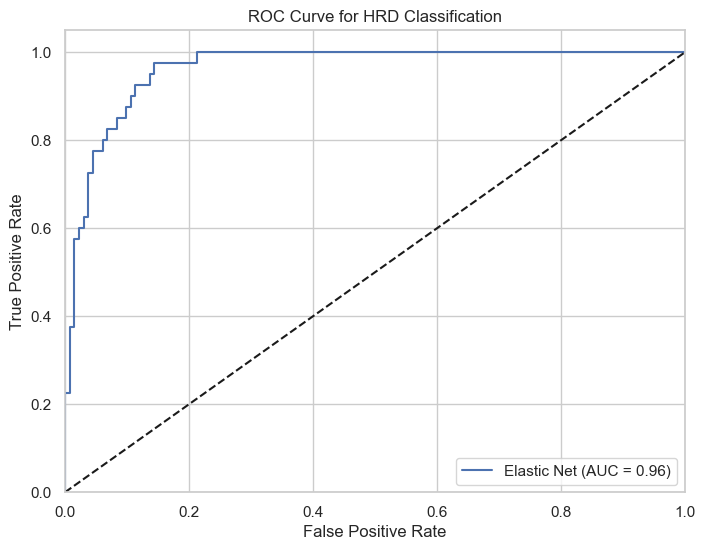


Elastic Net Classification Results:
AUC: 0.963

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       132
           1       0.77      0.82      0.80        40

    accuracy                           0.90       172
   macro avg       0.86      0.87      0.87       172
weighted avg       0.90      0.90      0.90       172


Confusion Matrix:
[[122  10]
 [  7  33]]

Top 500 predictive genes:
['RAPGEF6', 'ACSS3', 'TEX9', 'NR1D1', 'PYCR1', 'ESYT1', 'NDUFAF6', 'PI3', 'UGT2B15', 'R3HDM4', 'BIRC5', 'CHI3L2', 'CLSTN1', 'ADK', 'FES', 'YARS1', 'TENT5C', 'PTDSS2', 'ACTL6A', 'CDIN1', 'DHX36', 'NPC1', 'LDLRAD4', 'PLRG1', 'RBM15B', 'XPNPEP1', 'PRR15', 'SPAAR', 'ZNF561', 'NMB', 'ABTB2', 'LNP1', 'HABP4', 'BID', 'CLEC12A', 'LRRC4', 'IL17RB', 'EEF1AKMT1', 'IQCG', 'TRAK1', 'OTX1', 'TLX1', 'CLEC7A', 'IPO5', 'PTEN', 'KIF7', 'SDR16C5', 'OBP2B', 'BCAS1', 'KLHDC8A', 'ABCB7', 'CISH', 'EIF4EBP1', 'TAF4', 'CDC42', 'TFAP2C', 'VGLL1', 'GAR1

In [260]:
results_de, top_genes_de =  main(common_de_genes, softLabel_metadata['HRD_status_base'], n_features=500)


In [261]:
enet_de_model = results_de['Model']

## With VAE gene set

In [262]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt

def preprocess_data(X, y):
    """
    Preprocess data for classification with label encoding and scaling.
    Parameters:
    X: Feature matrix (RNA-seq data)
    y: Target vector (HRD status)
    """
    # Encode categorical labels
    le = LabelEncoder()
    y = le.fit_transform(y)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

def train_evaluate_elastic_net(X_train, X_test, y_train, y_test):
    """
    Train and evaluate Elastic Net model for HRD classification.
    """
    # Initialize and train model
    model = LogisticRegression(penalty='elasticnet', solver='saga',
                             l1_ratio=0.9, max_iter=1000)
    model.fit(X_train, y_train)
    
    # Get predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'Elastic Net (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for HRD Classification')
    plt.legend(loc="lower right")
    plt.show()
    
    return {
        'AUC': roc_auc,
        'Confusion Matrix': confusion_matrix(y_test, y_pred),
        'Classification Report': classification_report(y_test, y_pred),
        'Model': model
    }

def get_top_features(model, feature_names, n_features):
    """
    Extract top features based on absolute coefficient values.
    
    Parameters:
    model: Trained model object
    feature_names: List/array of feature names
    n_features: Number of top features to return
    
    Returns:
    List of top feature names
    """
    coefficients = model.coef_[0]  # Get coefficients from the model
    absolute_coefficients = np.abs(coefficients)
    top_indices = np.argsort(absolute_coefficients)[-n_features:]
    top_features = feature_names[top_indices]
    return list(top_features)

def main(gene_df, hrd_status, n_features):
    """
    Main function to run HRD classification using Elastic Net.
    Parameters:
    gene_df: DataFrame with gene expression data
    hrd_status: Series with HRD status labels
    """
    # Preprocess data
    X_train, X_test, y_train, y_test = preprocess_data(
        gene_df, hrd_status
    )
    
    # Train and evaluate model
    results = train_evaluate_elastic_net(X_train, X_test, y_train, y_test)
    
    # Print results
    print("\nElastic Net Classification Results:")
    print(f"AUC: {results['AUC']:.3f}")
    print("\nClassification Report:")
    print(results['Classification Report'])
    print("\nConfusion Matrix:")
    print(results['Confusion Matrix'])
    
    # Get top features
    top_features = get_top_features(results['Model'], gene_df.columns, n_features)
    print("\nTop " + str(n_features) + " predictive genes:")
    print(top_features)
    
    return results, top_features




Training Elastic Net with sparse importance genes:


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



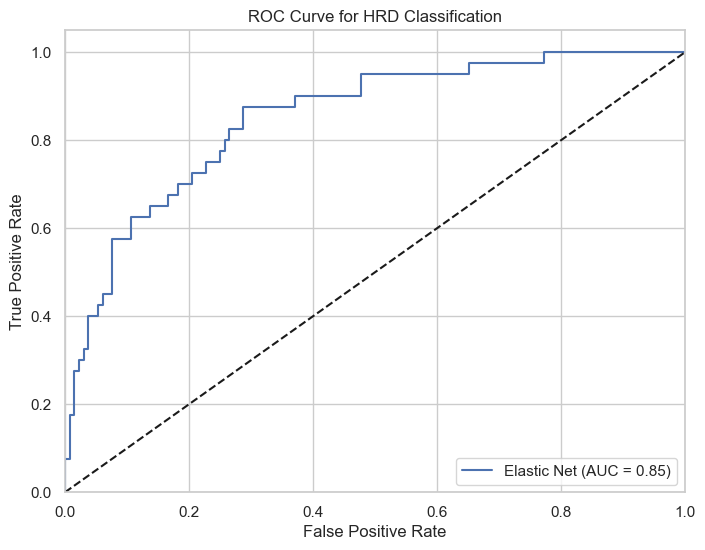


Elastic Net Classification Results:
AUC: 0.851

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       132
           1       0.68      0.57      0.62        40

    accuracy                           0.84       172
   macro avg       0.78      0.75      0.76       172
weighted avg       0.83      0.84      0.83       172


Confusion Matrix:
[[121  11]
 [ 17  23]]

Top 200 predictive genes:
['TIMP3', 'S100A14', 'COL6A1', 'HLA-DRB1', 'PPDPF', 'PSAP', 'RPL37A', 'YWHAQ', 'PEBP1', 'RPL12', 'RPL10A', 'TFF3', 'YWHAZ', 'RPL5', 'MT-ND3', 'EEF2', 'AEBP1', 'MUC1', 'BST2', 'SFRP2', 'AGR2', 'EIF4G2', 'APOD', 'MT2A', 'PSME1', 'S100A11', 'HLA-E', 'CHCHD2', 'LUM', 'S100A16', 'SH3BGRL', 'RPLP1', 'LGALS1', 'MT-ND1', 'EIF1', 'S100A9', 'TMSB4X', 'ATP6V0E1', 'SLC25A6', 'CD74', 'HSPA5', 'HLA-B', 'NDUFS5', 'VAMP8', 'RPS12', 'TUBB', 'SLC25A5', 'CD24', 'MARCKSL1', 'COL1A2', 'EZR', 'S100A10', 'H1-0', 'CAPNS1', 'EEF1B2', 'TPI1', 'HSP90B1'

In [263]:
# Now continue with the ENET binary model using the sparse genes instead of the DESeq2 genes
print("\nTraining Elastic Net with sparse importance genes:")
results_sparse, top_genes_sparse = main(common_sparse_genes, softLabel_metadata['HRD_status_base'], n_features=200)


In [264]:
enet_sparse_model = results_sparse['Model']

In [265]:
# Count non-zero coefficients in the binary models
nonzero_coeffs_deseq2 = np.sum(enet_de_model.coef_[0] != 0)
nonzero_coeffs_sparse = np.sum(results_sparse['Model'].coef_[0] != 0)
print(f"Pre-VAE feature engineering {nonzero_coeffs_deseq2}, Post-VAE feature engineering {nonzero_coeffs_sparse}")

Pre-VAE feature engineering 2919, Post-VAE feature engineering 188


# ENET Linear


Training Elastic Net with Grid Search to predict HRD probabilities:


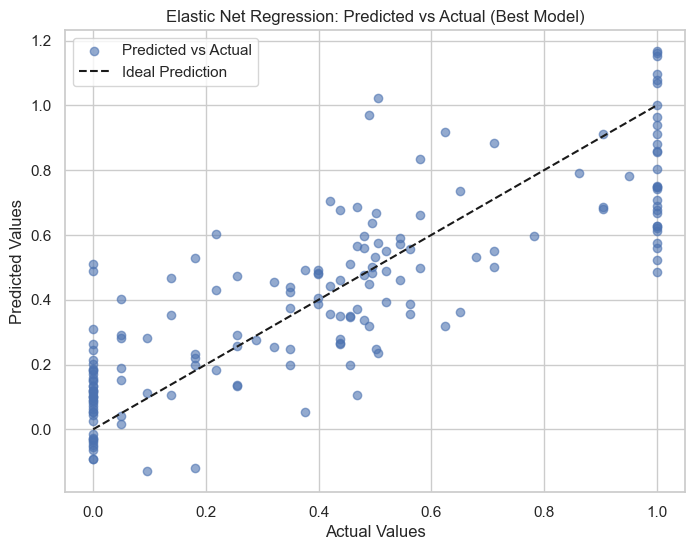

Best Parameters: {'alpha': 0.01, 'l1_ratio': 0.5}
Mean Squared Error: 0.039
R^2 Score: 0.691


({'Mean Squared Error': 0.03911275466499738, 'R^2 Score': 0.6910793003697142},
 {'alpha': 0.01, 'l1_ratio': 0.5})

In [266]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid
def preprocess_data(X, y, task='regression'):
    """
    Preprocesses data by splitting into train-test sets and scaling features.
    For regression, no label encoding is applied.
    """
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test
# Elastic Net Training & Evaluation with Grid Search
def train_evaluate_elastic_net_with_grid_search(X_train, X_test, y_train, y_test, alphas, l1_ratios):
    """
    Trains and evaluates Elastic Net models for a grid of hyperparameters.
    Returns the best model and its metrics.
    """
    best_model = None
    best_metrics = {'Mean Squared Error': float('inf'), 'R^2 Score': -float('inf')}
    best_params = {}

    # Grid search
    param_grid = ParameterGrid({'alpha': alphas, 'l1_ratio': l1_ratios})
    for params in param_grid:
        model = ElasticNet(alpha=params['alpha'], l1_ratio=params['l1_ratio'], max_iter=1000, random_state=42)
        
        # Train model
        model.fit(X_train, y_train)
        
        # Predict on test set
        y_pred = model.predict(X_test)
        
        # Evaluate model
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Update best model if current is better
        if mse < best_metrics['Mean Squared Error']:
            best_model = model
            best_metrics = {'Mean Squared Error': mse, 'R^2 Score': r2}
            best_params = params

    # Scatter plot of predictions vs actual values for the best model
    y_pred_best = best_model.predict(X_test)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred_best, alpha=0.6, label='Predicted vs Actual')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label='Ideal Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Elastic Net Regression: Predicted vs Actual (Best Model)')
    plt.legend(loc="upper left")
    plt.show()
    
    print(f"Best Parameters: {best_params}")
    print(f"Mean Squared Error: {best_metrics['Mean Squared Error']:.3f}")
    print(f"R^2 Score: {best_metrics['R^2 Score']:.3f}")
    
    return best_model, best_metrics, best_params

# Main Execution with Hyperparameter Grid Search
def main():
    """
    Main function for preprocessing data, training Elastic Net with grid search, and displaying results.
    """
    print("\nTraining Elastic Net with Grid Search to predict HRD probabilities:")
    
    # Example data preprocessing
    X_train, X_test, y_train, y_test = preprocess_data(common_de_genes, softLabel_metadata['soft prob'], task='regression')
    
    # Define hyperparameter ranges
    alphas = [0.01, 0.1, 0.25, 0.5, 1.0]
    # l1_ratios = [0.1, 0.5, 0.7, 0.9]
    l1_ratios = [0.5]
    
    best_model, best_metrics, best_params = train_evaluate_elastic_net_with_grid_search(
        X_train, X_test, y_train, y_test, alphas, l1_ratios
    )
    
    return best_model, best_metrics, best_params

# Execute Main
LIN_elastic_net_model, elastic_net_metrics, elastic_net_params = main()
elastic_net_metrics, elastic_net_params

## With VAE gene set


Training Elastic Net with Grid Search to predict HRD probabilities using sparse genes:


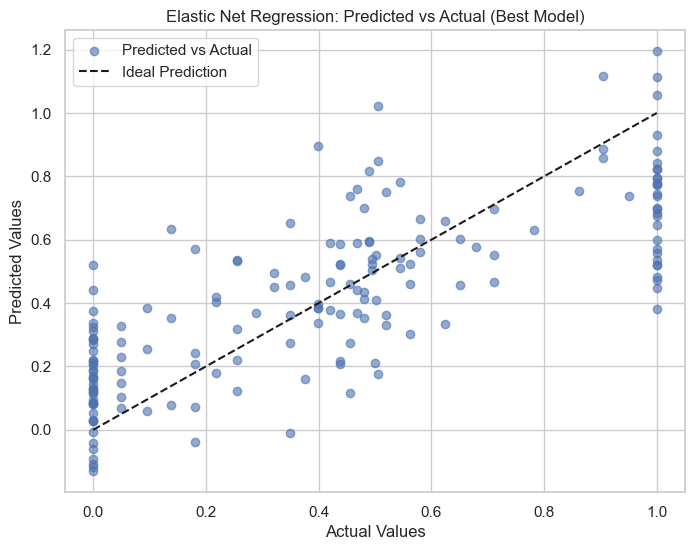

Best Parameters: {'alpha': 0.01, 'l1_ratio': 0.5}
Mean Squared Error: 0.052
R^2 Score: 0.591


In [267]:
# Continue with the ENET linear model using sparse genes
print("\nTraining Elastic Net with Grid Search to predict HRD probabilities using sparse genes:")
X_train, X_test, y_train, y_test = preprocess_data(common_sparse_genes, softLabel_metadata['soft prob'], task='regression')

# Define hyperparameter ranges (same as before)
alphas = [0.01, 0.1, 0.25, 0.5, 1.0]
l1_ratios = [0.5]

LIN_elastic_net_sparse, elastic_net_sparse_metrics, elastic_net_sparse_params = train_evaluate_elastic_net_with_grid_search(
    X_train, X_test, y_train, y_test, alphas, l1_ratios
)

In [268]:
def convert_regression_to_classification(y_test, y_pred_prob, threshold):
    """
    Convert regression predictions to binary classification predictions
    using a threshold and calculate classification metrics.
    
    Parameters:
    y_test: True regression values
    y_pred_prob: Predicted regression values
    threshold: Threshold for binary classification (default: 0.5)
    
    Returns:
    Dictionary with classification metrics
    """
    # Convert true regression values to binary
    y_test_binary = (y_test >= threshold).astype(int)
    
    # Convert predicted regression values to binary
    y_pred_binary = (y_pred_prob >= threshold).astype(int)
    
    # Calculate classification metrics
    conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)
    class_report = classification_report(y_test_binary, y_pred_binary, output_dict=True)
    
    # Calculate ROC and AUC
    fpr, tpr, _ = roc_curve(y_test_binary, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    # Create confusion matrix visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Non-HRD', 'HRD'], 
               yticklabels=['Non-HRD', 'HRD'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix (Threshold = {threshold})')
    plt.tight_layout()
    plt.show()
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'Elastic Net (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for HRD Classification')
    plt.legend(loc="lower right")
    plt.show()
    
    # Print metrics
    print(f"\nClassification Metrics (Threshold = {threshold}):")
    print(f"Accuracy: {class_report['accuracy']:.3f}")
    print(f"Precision (HRD): {class_report['1']['precision']:.3f}")
    print(f"Recall (HRD): {class_report['1']['recall']:.3f}")
    print(f"F1-score (HRD): {class_report['1']['f1-score']:.3f}")
    print(f"AUC: {roc_auc:.3f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    
    return {
        'confusion_matrix': conf_matrix,
        'classification_report': class_report,
        'auc': roc_auc,
        'y_pred_binary': y_pred_binary
    }



Converting regression predictions to classification:

Trying different threshold (0.1):


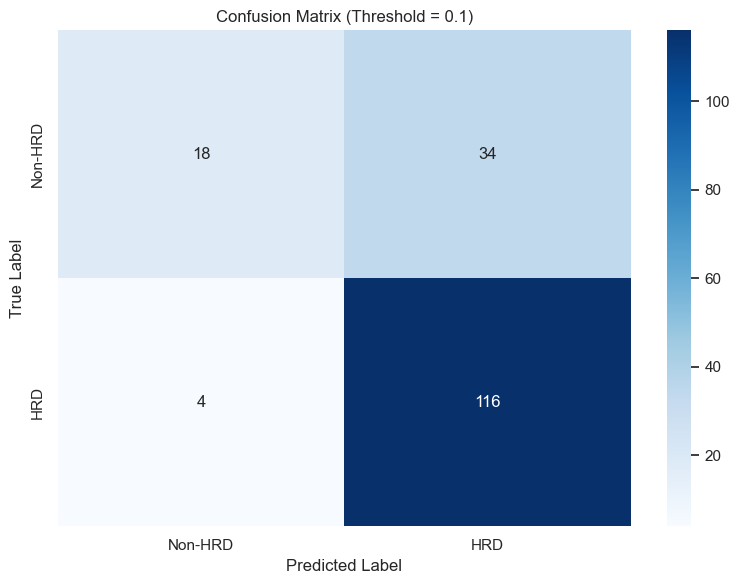

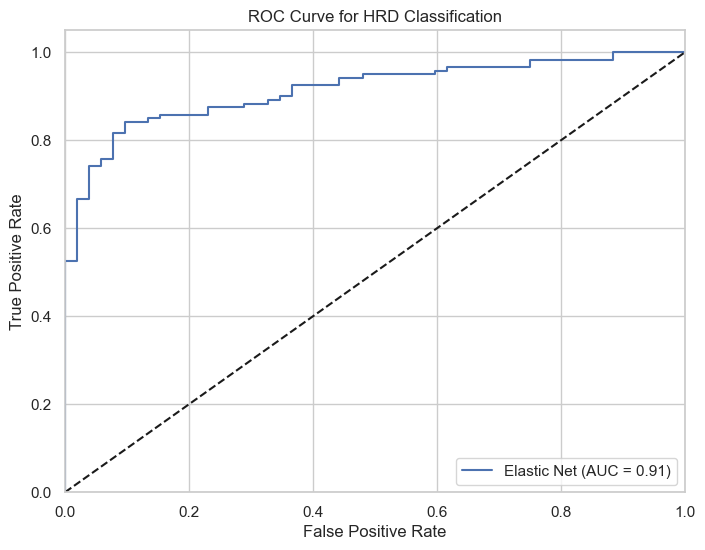


Classification Metrics (Threshold = 0.1):
Accuracy: 0.779
Precision (HRD): 0.773
Recall (HRD): 0.967
F1-score (HRD): 0.859
AUC: 0.914

Confusion Matrix:
[[ 18  34]
 [  4 116]]

Trying different threshold (0.2):


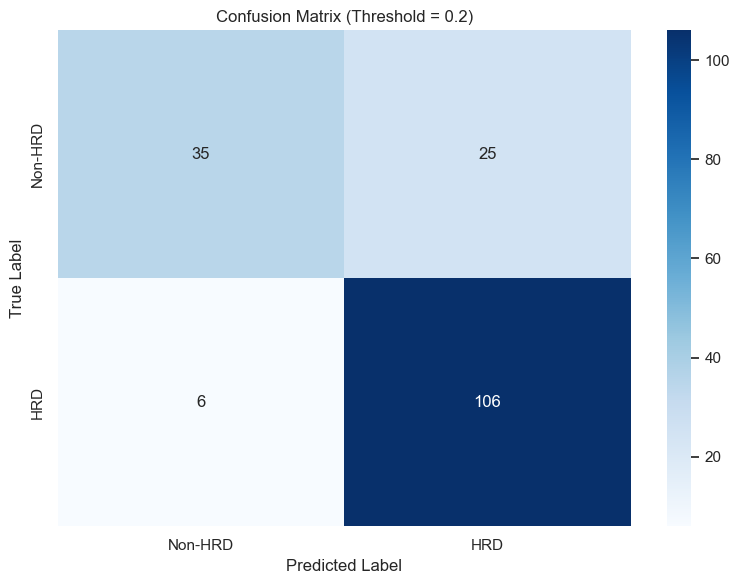

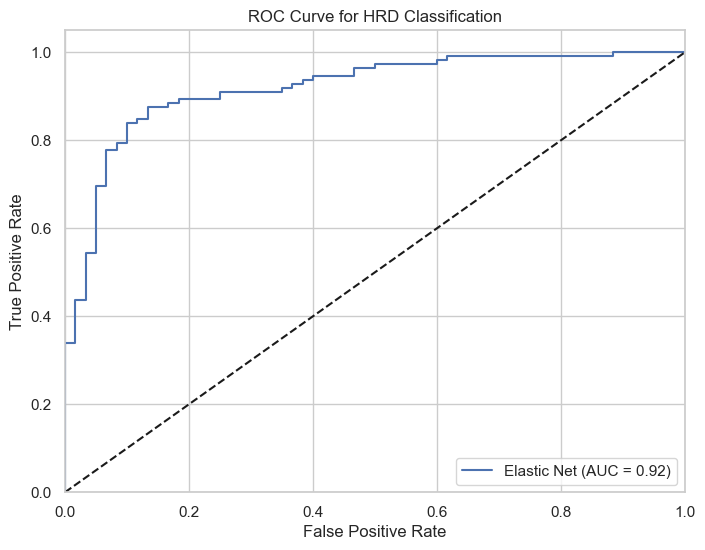


Classification Metrics (Threshold = 0.2):
Accuracy: 0.820
Precision (HRD): 0.809
Recall (HRD): 0.946
F1-score (HRD): 0.872
AUC: 0.919

Confusion Matrix:
[[ 35  25]
 [  6 106]]

Trying different threshold (0.3):


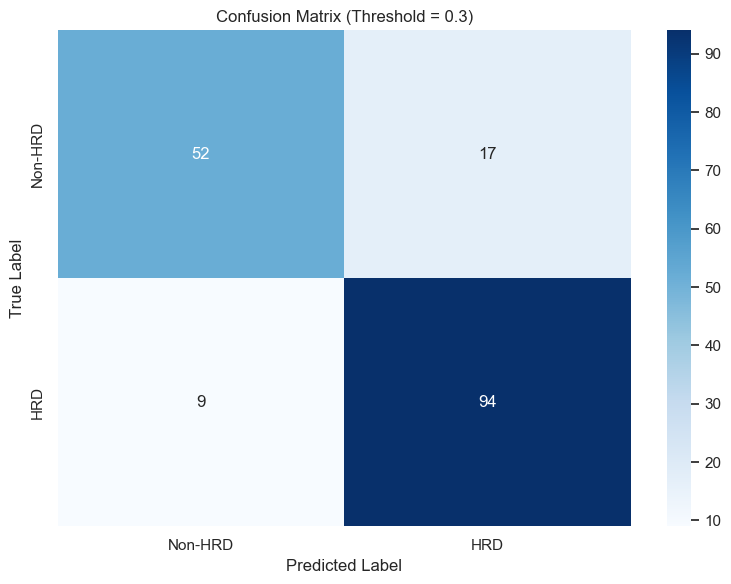

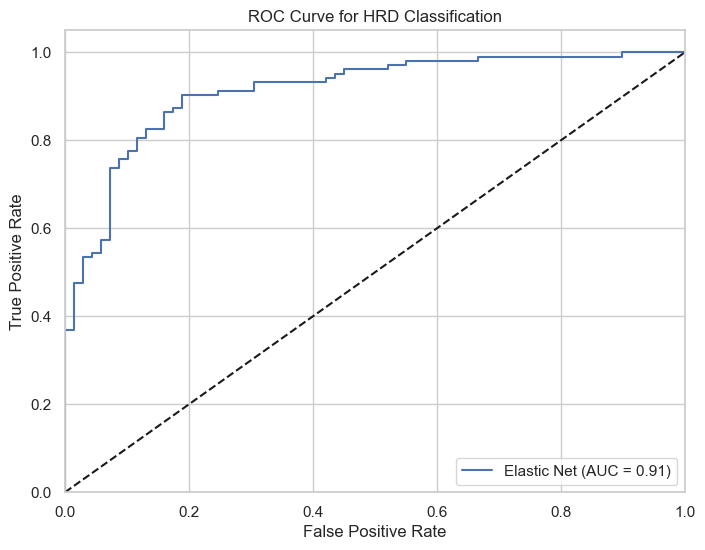


Classification Metrics (Threshold = 0.3):
Accuracy: 0.849
Precision (HRD): 0.847
Recall (HRD): 0.913
F1-score (HRD): 0.879
AUC: 0.913

Confusion Matrix:
[[52 17]
 [ 9 94]]

Trying different threshold (0.4):


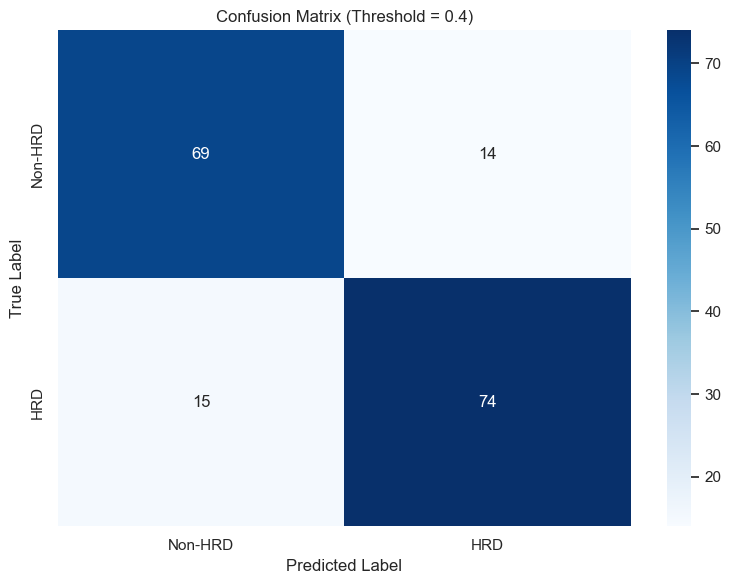

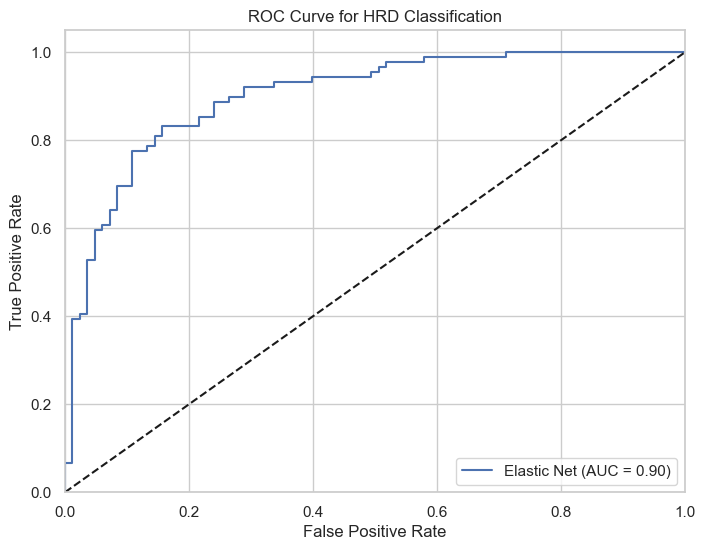


Classification Metrics (Threshold = 0.4):
Accuracy: 0.831
Precision (HRD): 0.841
Recall (HRD): 0.831
F1-score (HRD): 0.836
AUC: 0.901

Confusion Matrix:
[[69 14]
 [15 74]]

Trying different threshold (0.5):


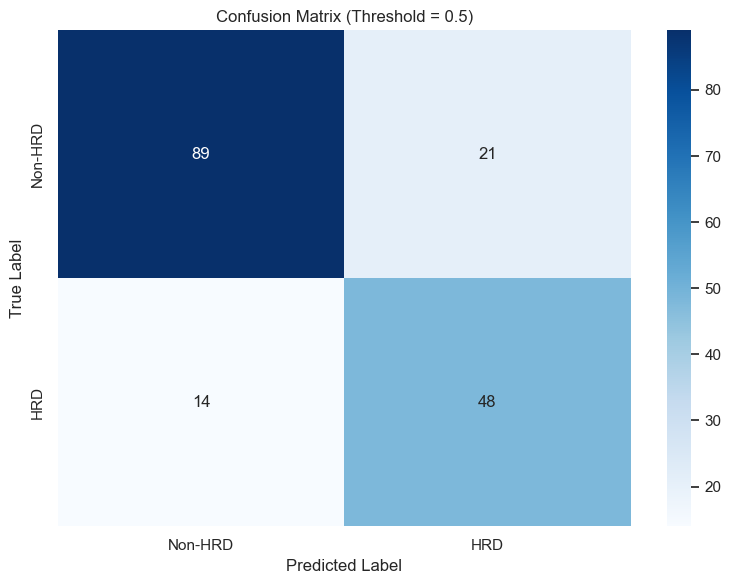

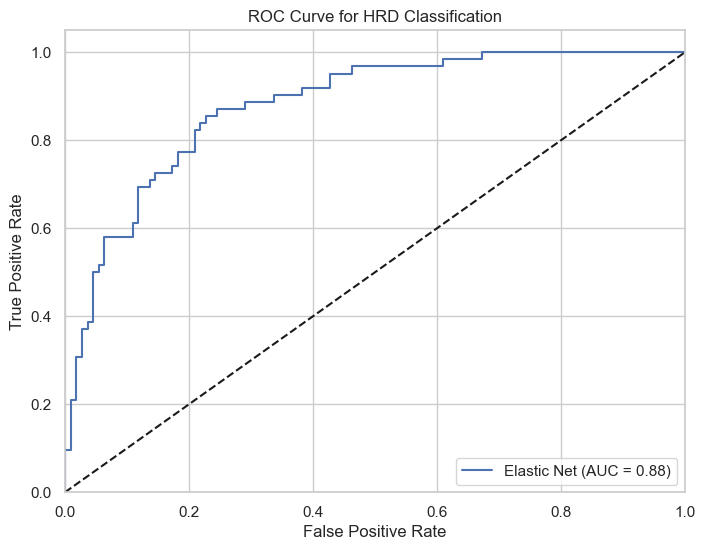


Classification Metrics (Threshold = 0.5):
Accuracy: 0.797
Precision (HRD): 0.696
Recall (HRD): 0.774
F1-score (HRD): 0.733
AUC: 0.879

Confusion Matrix:
[[89 21]
 [14 48]]

Trying different threshold (0.6):


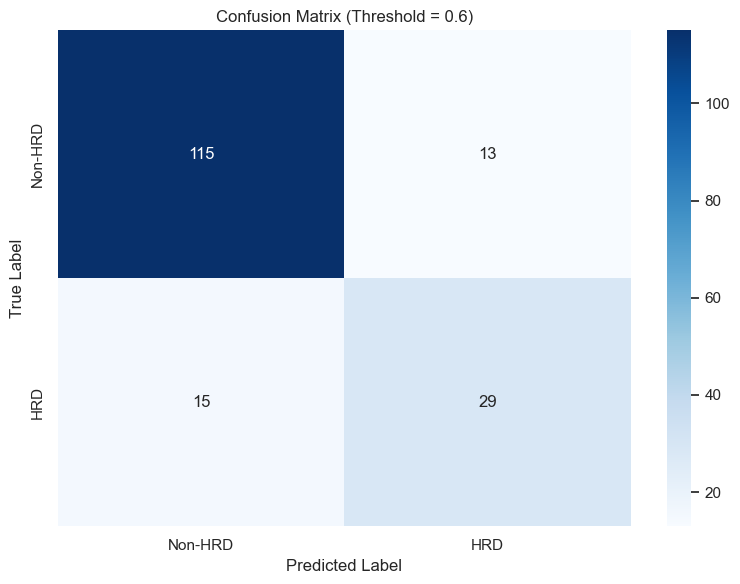

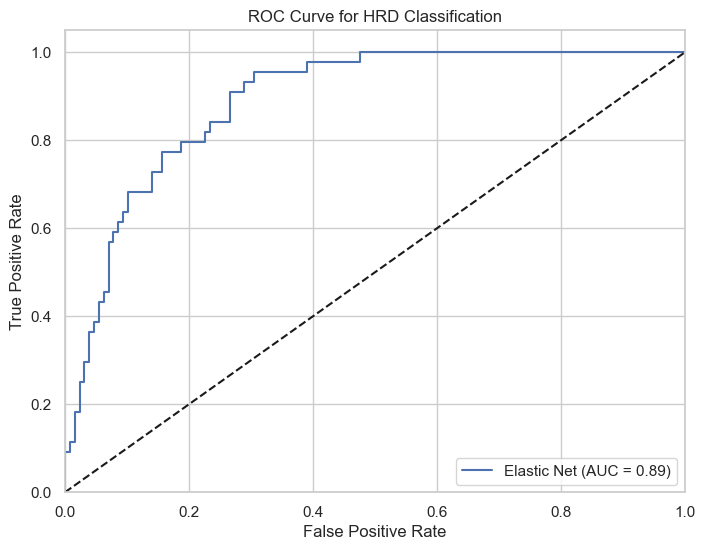


Classification Metrics (Threshold = 0.6):
Accuracy: 0.837
Precision (HRD): 0.690
Recall (HRD): 0.659
F1-score (HRD): 0.674
AUC: 0.890

Confusion Matrix:
[[115  13]
 [ 15  29]]

Trying different threshold (0.7):


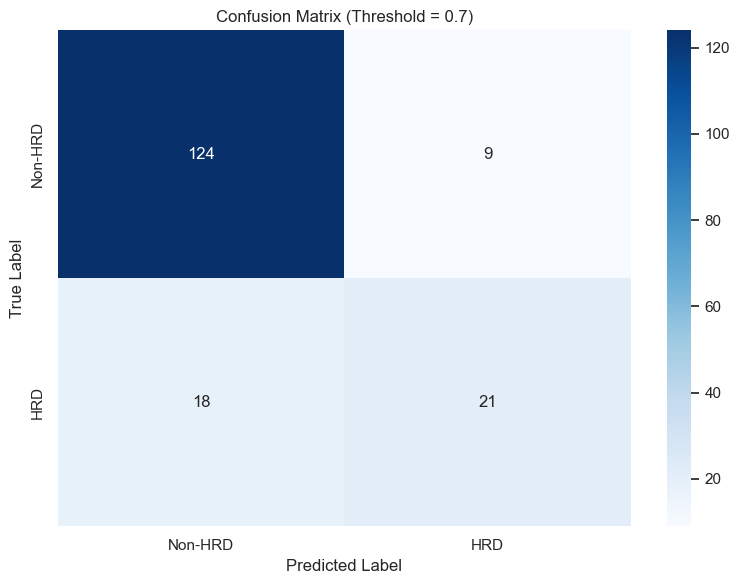

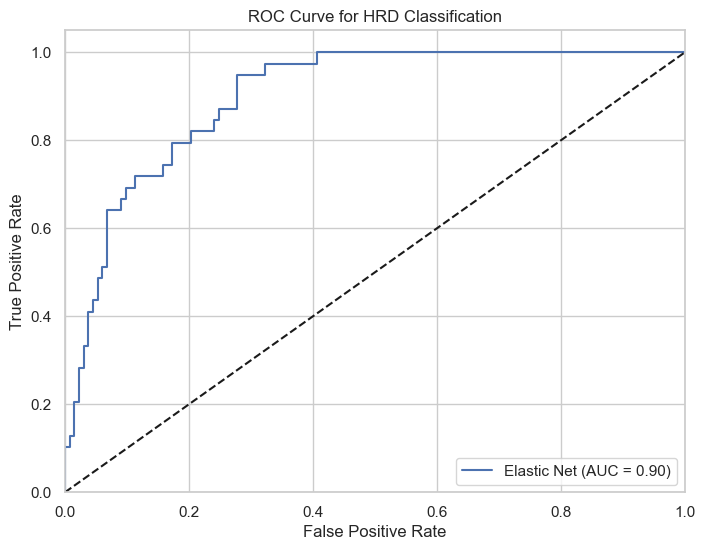


Classification Metrics (Threshold = 0.7):
Accuracy: 0.843
Precision (HRD): 0.700
Recall (HRD): 0.538
F1-score (HRD): 0.609
AUC: 0.900

Confusion Matrix:
[[124   9]
 [ 18  21]]

Trying different threshold (0.8):


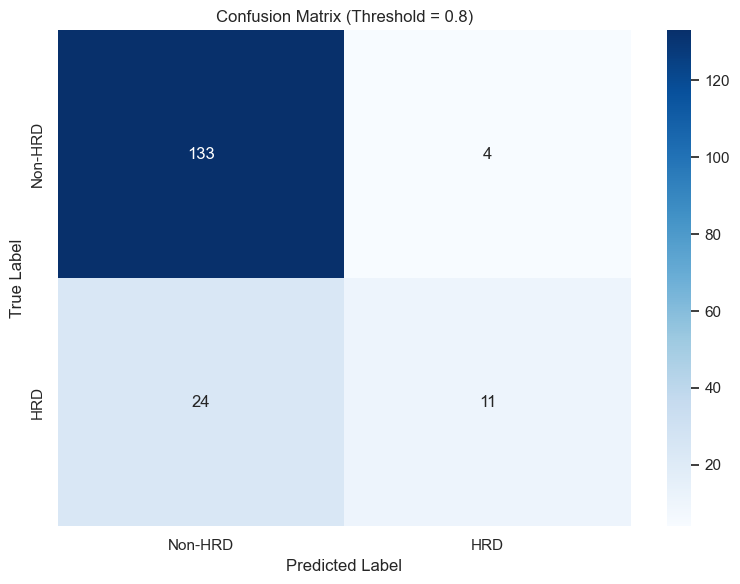

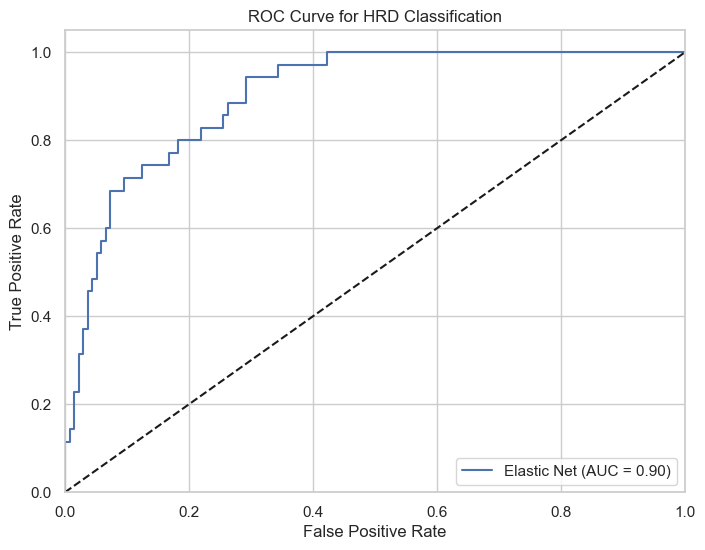


Classification Metrics (Threshold = 0.8):
Accuracy: 0.837
Precision (HRD): 0.733
Recall (HRD): 0.314
F1-score (HRD): 0.440
AUC: 0.902

Confusion Matrix:
[[133   4]
 [ 24  11]]

Trying different threshold (0.1):


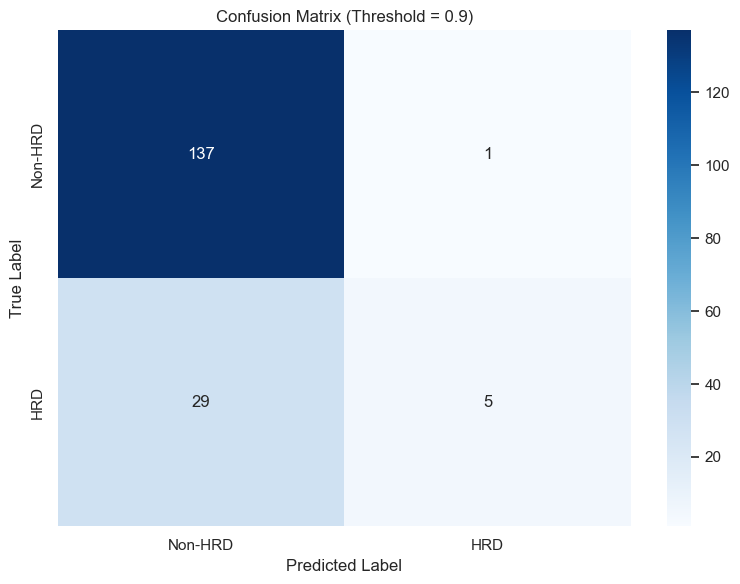

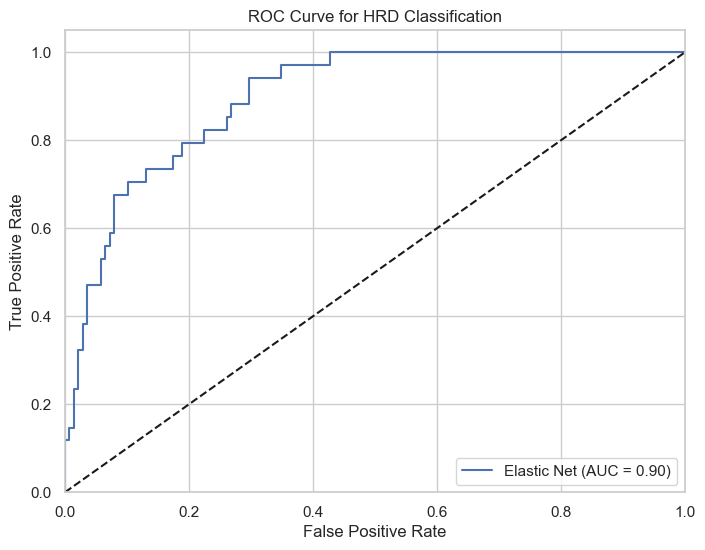


Classification Metrics (Threshold = 0.9):
Accuracy: 0.826
Precision (HRD): 0.833
Recall (HRD): 0.147
F1-score (HRD): 0.250
AUC: 0.897

Confusion Matrix:
[[137   1]
 [ 29   5]]


In [269]:

# Add this code after your existing elastic net model training:
print("\nConverting regression predictions to classification:")
# Get the predictions from your regression model
y_pred_prob = LIN_elastic_net_sparse.predict(X_test)

# Import seaborn for the heatmap (add this at the top of your script)
import seaborn as sns


# Convert and evaluate
print("\nTrying different threshold (0.1):")
classification_results = convert_regression_to_classification(y_test, y_pred_prob, threshold=0.1)

# You could also experiment with different thresholds
print("\nTrying different threshold (0.2):")
classification_results_alt = convert_regression_to_classification(y_test, y_pred_prob, threshold=0.2)


# You could also experiment with different thresholds
print("\nTrying different threshold (0.3):")
classification_results_alt = convert_regression_to_classification(y_test, y_pred_prob, threshold=0.3)

# You could also experiment with different thresholds
print("\nTrying different threshold (0.4):")
classification_results_alt = convert_regression_to_classification(y_test, y_pred_prob, threshold=0.4)


# Convert and evaluate
print("\nTrying different threshold (0.5):")
classification_results = convert_regression_to_classification(y_test, y_pred_prob, threshold=0.5)


# You could also experiment with different thresholds
print("\nTrying different threshold (0.6):")
classification_results_alt = convert_regression_to_classification(y_test, y_pred_prob, threshold=0.6)


# You could also experiment with different thresholds
print("\nTrying different threshold (0.7):")
classification_results_alt = convert_regression_to_classification(y_test, y_pred_prob, threshold=0.7)


# You could also experiment with different thresholds
print("\nTrying different threshold (0.8):")
classification_results_alt = convert_regression_to_classification(y_test, y_pred_prob, threshold=0.8)


# You could also experiment with different thresholds
print("\nTrying different threshold (0.1):")
classification_results_alt = convert_regression_to_classification(y_test, y_pred_prob, threshold=0.9)

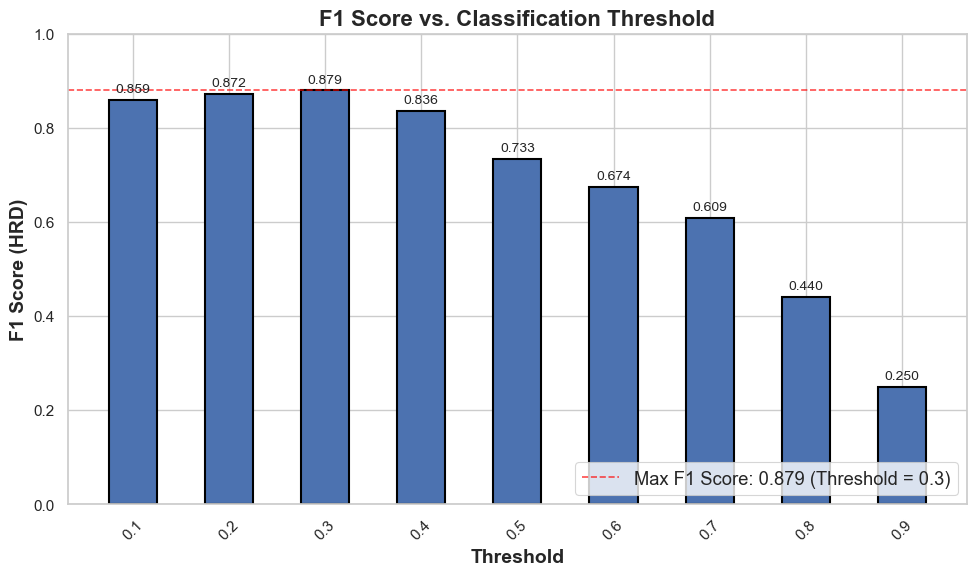

In [270]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Extract the data from the provided text
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
f1_scores = [0.859, 0.872, 0.879, 0.836, 0.733, 0.674, 0.609, 0.440, 0.250]

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Apply seaborn styling without using plt.style
sns.set(style="whitegrid")
sns.set_context("paper", font_scale=1.5)

# Create the bar plot
bars = ax.bar(thresholds, f1_scores, width=0.05, edgecolor='black', linewidth=1.5)

# Add a horizontal line at the maximum F1 score
max_f1 = max(f1_scores)
max_threshold = thresholds[f1_scores.index(max_f1)]
ax.axhline(y=max_f1, color='red', linestyle='--', alpha=0.7, 
           label=f'Max F1 Score: {max_f1} (Threshold = {max_threshold})')

# Customize the plot
ax.set_xlabel('Threshold', fontsize=14, fontweight='bold')
ax.set_ylabel('F1 Score (HRD)', fontsize=14, fontweight='bold')
ax.set_title('F1 Score vs. Classification Threshold', fontsize=16, fontweight='bold')
ax.set_ylim([0, 1.0])
ax.set_xticks(thresholds)
ax.set_xticklabels([str(t) for t in thresholds], rotation=45)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# Add a legend
ax.legend(loc='lower right')

# Tighten the layout and adjust padding
plt.tight_layout()

# Save the figure (uncomment to save)
# plt.savefig('threshold_vs_f1_score.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

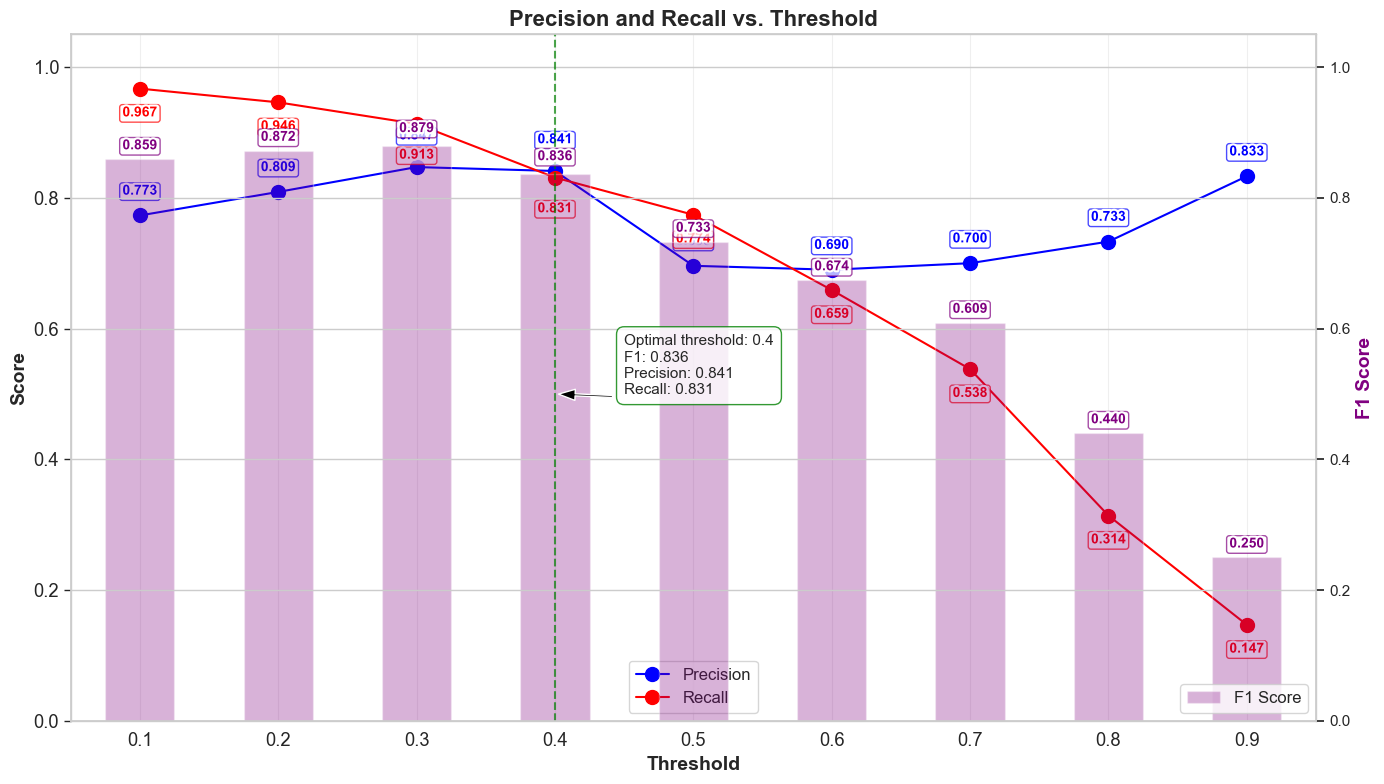

In [271]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patheffects import withStroke

# Extract the data from the provided text
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
precision = [0.773, 0.809, 0.847, 0.841, 0.696, 0.690, 0.700, 0.733, 0.833]
recall = [0.967, 0.946, 0.913, 0.831, 0.774, 0.659, 0.538, 0.314, 0.147]
f1_scores = [0.859, 0.872, 0.879, 0.836, 0.733, 0.674, 0.609, 0.440, 0.250]

# Create the figure and axes - increasing figure size for more space
fig, ax1 = plt.subplots(figsize=(14, 8))

# Set seaborn style
sns.set(style="whitegrid")

# Plot the dots for precision and recall
ax1.plot(thresholds, precision, 'o-', color='blue', markersize=10, label='Precision', zorder=1)
ax1.plot(thresholds, recall, 'o-', color='red', markersize=10, label='Recall', zorder=1)

# Add data labels for precision with improved spacing and visibility
for i, p in enumerate(precision):
    # Adjust vertical offset for crowded areas
    y_offset = 15
    # Additional spacing for the crowded values at thresholds 0.3 and 0.4
    if thresholds[i] == 0.3 or thresholds[i] == 0.4:
        y_offset = 20
        
    label = ax1.annotate(f'{p:.3f}', 
                 (thresholds[i], p),
                 textcoords="offset points", 
                 xytext=(0, y_offset), 
                 ha='center',
                 fontsize=10,
                 fontweight='bold',
                 color='blue',
                 zorder=5,  # Higher zorder to bring text to front
                 bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="blue", alpha=0.7))
    
    # Add path effects to make text more visible
    label.set_path_effects([withStroke(linewidth=3, foreground='white')])

# Add data labels for recall with improved spacing and visibility
for i, r in enumerate(recall):
    # Adjust vertical offset for crowded areas
    y_offset = -20
    # Additional spacing for the crowded values at thresholds 0.3 and 0.4
    if thresholds[i] == 0.3 or thresholds[i] == 0.4:
        y_offset = -25
        
    label = ax1.annotate(f'{r:.3f}', 
                 (thresholds[i], r),
                 textcoords="offset points", 
                 xytext=(0, y_offset), 
                 ha='center',
                 fontsize=10,
                 fontweight='bold',
                 color='red',
                 zorder=5,  # Higher zorder to bring text to front
                 bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="red", alpha=0.7))
    
    # Add path effects to make text more visible
    label.set_path_effects([withStroke(linewidth=3, foreground='white')])

# Customize the plot
ax1.set_xlabel('Threshold', fontsize=14, fontweight='bold')
ax1.set_ylabel('Score', fontsize=14, fontweight='bold')
ax1.set_title('Precision and Recall vs. Threshold', fontsize=16, fontweight='bold')
ax1.set_xlim([0.05, 0.95])
ax1.set_ylim([0, 1.05])
ax1.set_xticks(thresholds)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower center', fontsize=12)

# Create bar plot for F1 scores on a second axis
ax2 = ax1.twinx()
bars = ax2.bar(thresholds, f1_scores, alpha=0.3, width=0.05, color='purple', label='F1 Score', zorder=0)

# Add value labels on top of each bar with improved visibility
for i, bar in enumerate(bars):
    height = bar.get_height()
    # Increased spacing for crowded areas
    y_offset = 5
    if thresholds[i] == 0.3 or thresholds[i] == 0.4:
        y_offset = 8
        
    label = ax2.annotate(f'{height:.3f}',
                 xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, y_offset),
                 textcoords="offset points",
                 ha='center', va='bottom',
                 fontsize=10,
                 fontweight='bold',
                 color='purple',
                 zorder=5,  # Higher zorder to bring text to front
                 bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="purple", alpha=0.7))
    
    # Add path effects to make text more visible
    label.set_path_effects([withStroke(linewidth=3, foreground='white')])

ax2.set_ylabel('F1 Score', fontsize=14, fontweight='bold', color='purple')
ax2.legend(loc='lower right', fontsize=12)
ax2.set_ylim([0, 1.05])

# Modified to use 0.4 as the highlighted threshold
selected_threshold = 0.4
selected_index = thresholds.index(selected_threshold)
selected_f1 = f1_scores[selected_index]
selected_precision = precision[selected_index]
selected_recall = recall[selected_index]

# Add a vertical line at the selected threshold of 0.4
plt.axvline(x=selected_threshold, color='green', linestyle='--', alpha=0.7,
           label=f'Max F1 Score: {selected_f1} (Threshold = {selected_threshold})',
           zorder=2)

# Add text annotation for the selected optimal threshold
# Moved annotation further to the right to avoid crowding
plt.annotate(f'Optimal threshold: {selected_threshold}\nF1: {selected_f1:.3f}\nPrecision: {selected_precision:.3f}\nRecall: {selected_recall:.3f}',
             xy=(selected_threshold, 0.5),
             xytext=(selected_threshold+0.05, 0.5),  # Increased horizontal spacing
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
             fontsize=11,
             bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="green", alpha=.8),
             zorder=6)  # Highest zorder to ensure visibility

# Tighten the layout and adjust padding
plt.tight_layout()

# Save the figure (uncomment to save)
# plt.savefig('threshold_precision_recall_f1_optimal_0.4.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

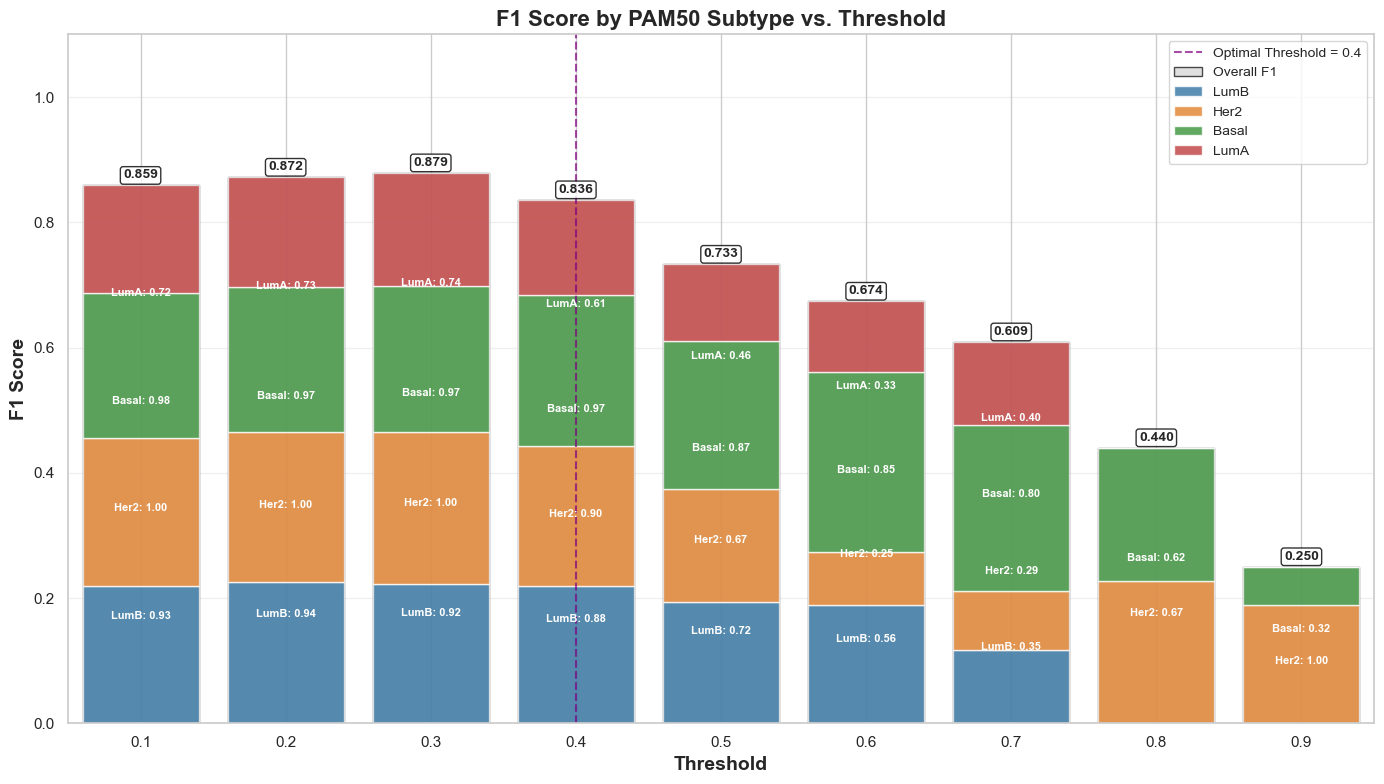

In [272]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Extract the data from the provided text - thresholds and overall F1 scores
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
overall_f1 = [0.859, 0.872, 0.879, 0.836, 0.733, 0.674, 0.609, 0.440, 0.250]

# F1 scores by PAM50 subtype at each threshold (extracted from the output)
# Format: [LumB, Her2, Basal, LumA]
f1_by_subtype = {
    0.1: [0.925, 1.000, 0.984, 0.724],
    0.2: [0.938, 1.000, 0.967, 0.731],
    0.3: [0.915, 1.000, 0.967, 0.743],
    0.4: [0.880, 0.900, 0.967, 0.609],
    0.5: [0.718, 0.667, 0.873, 0.455],
    0.6: [0.560, 0.250, 0.851, 0.333],
    0.7: [0.353, 0.286, 0.800, 0.400],
    0.8: [0.000, 0.667, 0.625, 0.000],
    0.9: [0.000, 1.000, 0.320, 0.000]
}

# Extract the F1 scores for each subtype at each threshold
lumb_f1 = [f1_by_subtype[t][0] for t in thresholds]
her2_f1 = [f1_by_subtype[t][1] for t in thresholds]
basal_f1 = [f1_by_subtype[t][2] for t in thresholds]
luma_f1 = [f1_by_subtype[t][3] for t in thresholds]

# Create the figure and axes
fig, ax = plt.subplots(figsize=(14, 8))

# Set seaborn style
sns.set(style="whitegrid")

# Calculate proportions of each subtype's F1 to the overall F1
# To prevent division by zero, handle cases where overall_f1 is 0
proportions = []
for i, total in enumerate(overall_f1):
    if total == 0:
        proportions.append([0, 0, 0, 0])
    else:
        # Normalize to make sure proportions sum to 1
        raw_props = [lumb_f1[i]/total, her2_f1[i]/total, basal_f1[i]/total, luma_f1[i]/total]
        sum_props = sum(raw_props)
        if sum_props > 0:
            proportions.append([p/sum_props for p in raw_props])
        else:
            proportions.append([0, 0, 0, 0])

# Create the main bars for overall F1 scores
width = 0.08  # Width of bars
bar_positions = np.array(thresholds)
main_bars = ax.bar(bar_positions, overall_f1, width, color='lightgray', 
                  edgecolor='black', linewidth=1, alpha=0.7, label='Overall F1')

# Create stacked bars within the main bars
for i, (pos, total) in enumerate(zip(bar_positions, overall_f1)):
    if total > 0:
        # Calculate heights of each segment
        height_lumb = total * proportions[i][0]
        height_her2 = total * proportions[i][1]
        height_basal = total * proportions[i][2]
        height_luma = total * proportions[i][3]
        
        # Calculate bottom positions
        bottom_her2 = height_lumb
        bottom_basal = bottom_her2 + height_her2
        bottom_luma = bottom_basal + height_basal
        
        # Create stacked bars
        ax.bar(pos, height_lumb, width, color='#3274A1', alpha=0.8, label='LumB' if i == 0 else "")
        ax.bar(pos, height_her2, width, bottom=bottom_her2, color='#E1812C', alpha=0.8, label='Her2' if i == 0 else "")
        ax.bar(pos, height_basal, width, bottom=bottom_basal, color='#3A923A', alpha=0.8, label='Basal' if i == 0 else "")
        ax.bar(pos, height_luma, width, bottom=bottom_luma, color='#C03D3E', alpha=0.8, label='LumA' if i == 0 else "")

# Add data labels for overall F1
for i, bar in enumerate(main_bars):
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', 
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 5), 
                textcoords="offset points",
                ha='center',
                fontsize=10,
                fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", alpha=0.8),
                zorder=6)

# Add data labels for each subtype's F1 score
for i, threshold in enumerate(thresholds):
    # LumB
    if lumb_f1[i] > 0:
        ax.annotate(f'LumB: {lumb_f1[i]:.2f}', 
                    xy=(threshold, overall_f1[i] * 0.2),
                    xytext=(0, 0), 
                    textcoords="offset points",
                    ha='center', va='center',
                    fontsize=8,
                    color='white',
                    fontweight='bold',
                    zorder=7)
    
    # Her2
    if her2_f1[i] > 0:
        ax.annotate(f'Her2: {her2_f1[i]:.2f}', 
                    xy=(threshold, overall_f1[i] * 0.4),
                    xytext=(0, 0), 
                    textcoords="offset points",
                    ha='center', va='center',
                    fontsize=8,
                    color='white',
                    fontweight='bold',
                    zorder=7)
    
    # Basal
    if basal_f1[i] > 0:
        ax.annotate(f'Basal: {basal_f1[i]:.2f}', 
                    xy=(threshold, overall_f1[i] * 0.6),
                    xytext=(0, 0), 
                    textcoords="offset points",
                    ha='center', va='center',
                    fontsize=8,
                    color='white',
                    fontweight='bold',
                    zorder=7)
    
    # LumA
    if luma_f1[i] > 0:
        ax.annotate(f'LumA: {luma_f1[i]:.2f}', 
                    xy=(threshold, overall_f1[i] * 0.8),
                    xytext=(0, 0), 
                    textcoords="offset points",
                    ha='center', va='center',
                    fontsize=8,
                    color='white',
                    fontweight='bold',
                    zorder=7)

# Customize the plot
ax.set_xlabel('Threshold', fontsize=14, fontweight='bold')
ax.set_ylabel('F1 Score', fontsize=14, fontweight='bold')
ax.set_title('F1 Score by PAM50 Subtype vs. Threshold', fontsize=16, fontweight='bold')
ax.set_xlim([0.05, 0.95])
ax.set_ylim([0, 1.1])  # Limit to 0-1 for F1 scores
ax.set_xticks(thresholds)
ax.grid(True, axis='y', alpha=0.3)

# Add a vertical line at the selected optimal threshold (0.4)
selected_threshold = 0.4
ax.axvline(x=selected_threshold, color='purple', linestyle='--', alpha=0.7,
           label=f'Optimal Threshold = {selected_threshold}', zorder=2)

# Add legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=10)

# Add annotations for each subtype's F1 score at the optimal threshold
optimal_idx = thresholds.index(selected_threshold)
annotations = [
    f"LumB F1: {lumb_f1[optimal_idx]:.3f}",
    f"Her2 F1: {her2_f1[optimal_idx]:.3f}", 
    f"Basal F1: {basal_f1[optimal_idx]:.3f}",
    f"LumA F1: {luma_f1[optimal_idx]:.3f}",
    f"Overall F1: {overall_f1[optimal_idx]:.3f}"
]

# Add a text box with subtype F1 scores at optimal threshold
props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='purple')
# ax.text(0.05, 0.95, '\n'.join(annotations), transform=ax.transAxes, fontsize=10,
#         verticalalignment='top', bbox=props)

# Tighten the layout and adjust padding
plt.tight_layout()

# Save the figure (uncomment to save)
# plt.savefig('f1_score_by_pam50_subtype.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

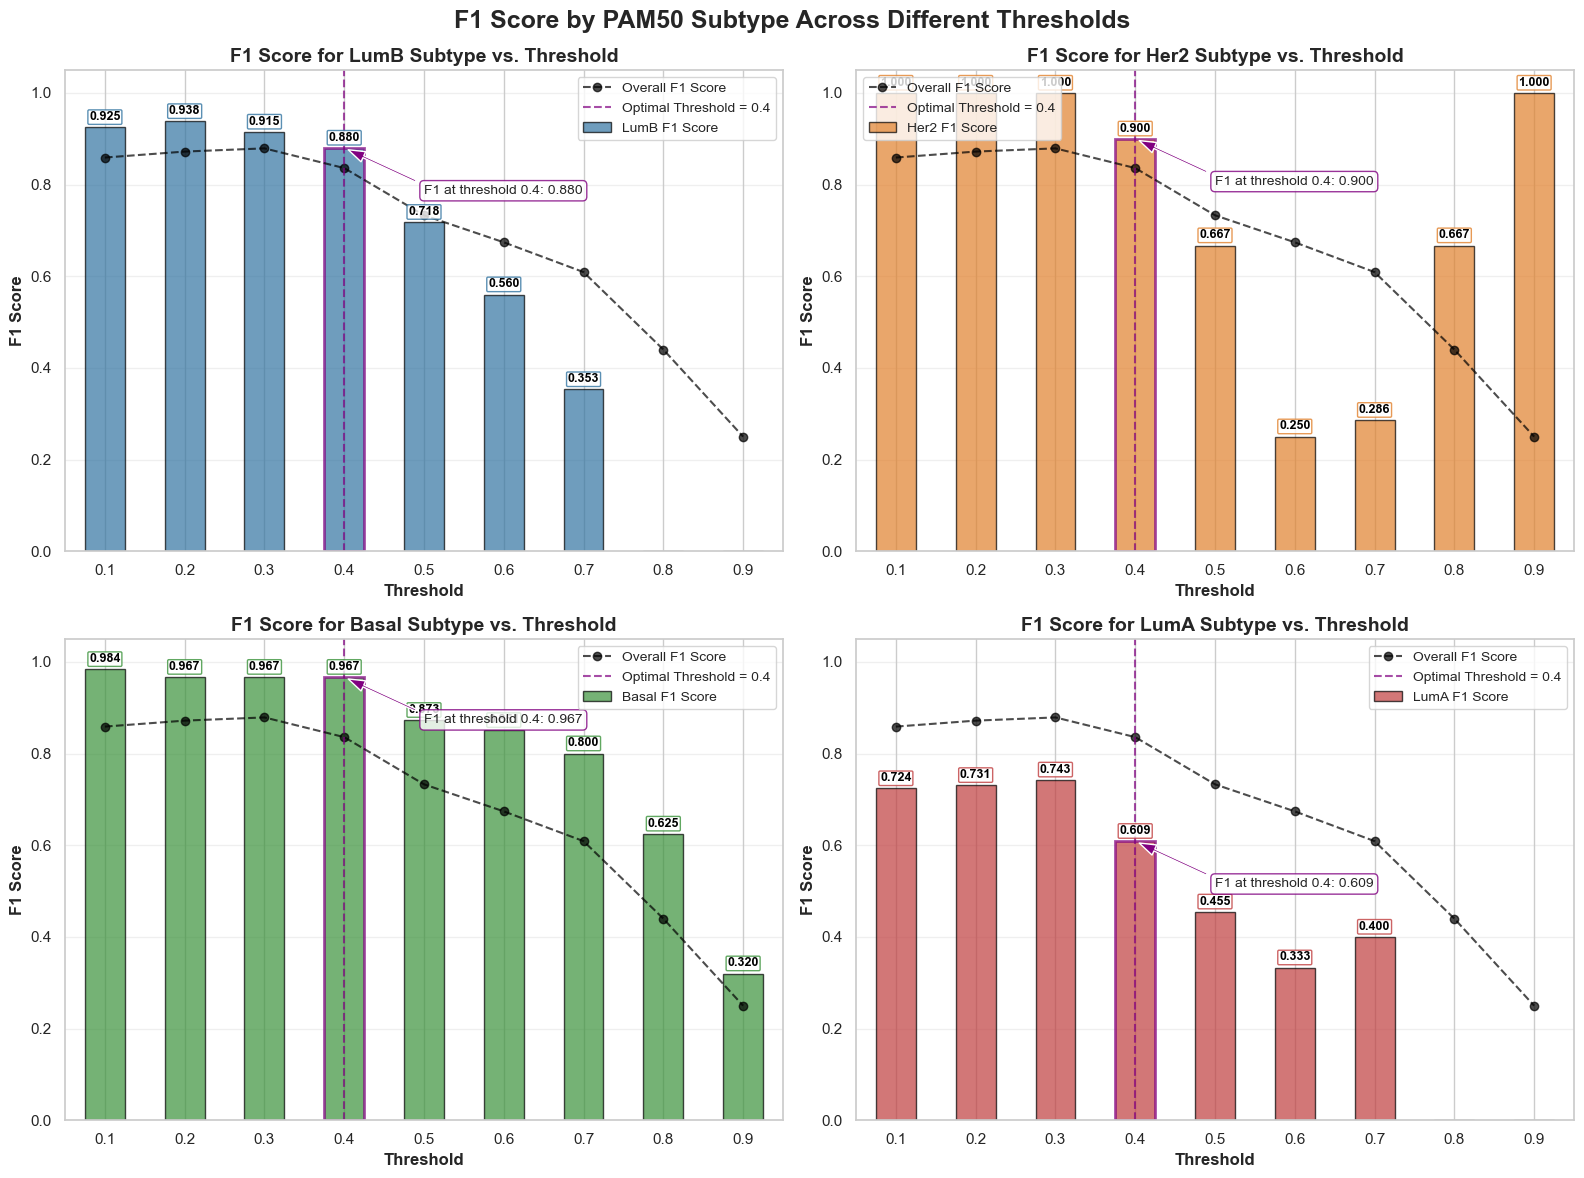

In [273]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Extract the data from the provided text - thresholds and overall F1 scores
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
overall_f1 = [0.859, 0.872, 0.879, 0.836, 0.733, 0.674, 0.609, 0.440, 0.250]

# F1 scores by PAM50 subtype at each threshold (extracted from the output)
# Format: [LumB, Her2, Basal, LumA]
f1_by_subtype = {
    0.1: [0.925, 1.000, 0.984, 0.724],
    0.2: [0.938, 1.000, 0.967, 0.731],
    0.3: [0.915, 1.000, 0.967, 0.743],
    0.4: [0.880, 0.900, 0.967, 0.609],
    0.5: [0.718, 0.667, 0.873, 0.455],
    0.6: [0.560, 0.250, 0.851, 0.333],
    0.7: [0.353, 0.286, 0.800, 0.400],
    0.8: [0.000, 0.667, 0.625, 0.000],
    0.9: [0.000, 1.000, 0.320, 0.000]
}

# Extract the F1 scores for each subtype at each threshold
lumb_f1 = [f1_by_subtype[t][0] for t in thresholds]
her2_f1 = [f1_by_subtype[t][1] for t in thresholds]
basal_f1 = [f1_by_subtype[t][2] for t in thresholds]
luma_f1 = [f1_by_subtype[t][3] for t in thresholds]

# Define colors for each subtype
subtype_colors = {
    'LumB': '#3274A1',
    'Her2': '#E1812C',
    'Basal': '#3A923A',
    'LumA': '#C03D3E'
}

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.flatten()  # Flatten for easier indexing

# Set seaborn style
sns.set(style="whitegrid")

# Selected optimal threshold
selected_threshold = 0.4

# Create a bar plot for each subtype
subtypes = ['LumB', 'Her2', 'Basal', 'LumA']
f1_scores = [lumb_f1, her2_f1, basal_f1, luma_f1]

for i, (subtype, scores, ax) in enumerate(zip(subtypes, f1_scores, axs)):
    # Create the bar plot for this subtype
    bars = ax.bar(thresholds, scores, width=0.05, 
                 color=subtype_colors[subtype], alpha=0.7, 
                 edgecolor='black', linewidth=1, label=f'{subtype} F1 Score')
    
    # Add the overall F1 score line for reference
    ax.plot(thresholds, overall_f1, 'o--', color='black', markersize=6, 
            linewidth=1.5, alpha=0.7, label='Overall F1 Score')
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Only add label if there's a non-zero F1 score
            ax.annotate(f'{height:.3f}', 
                       xy=(bar.get_x() + bar.get_width()/2, height),
                       xytext=(0, 3), 
                       textcoords="offset points",
                       ha='center', va='bottom',
                       fontsize=9,
                       fontweight='bold',
                       color='black',
                       bbox=dict(boxstyle="round,pad=0.1", fc="white", ec=subtype_colors[subtype], alpha=0.8))
    
    # Add a vertical line at the selected optimal threshold
    ax.axvline(x=selected_threshold, color='purple', linestyle='--', alpha=0.7,
              label=f'Optimal Threshold = {selected_threshold}')
    
    # Highlight the bar at the optimal threshold
    optimal_idx = thresholds.index(selected_threshold)
    optimal_bar = bars[optimal_idx]
    optimal_bar.set_edgecolor('purple')
    optimal_bar.set_linewidth(2)
    
    # Customize the plot
    ax.set_xlabel('Threshold', fontsize=12, fontweight='bold')
    ax.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
    ax.set_title(f'F1 Score for {subtype} Subtype vs. Threshold', fontsize=14, fontweight='bold')
    ax.set_xlim([0.05, 0.95])
    ax.set_ylim([0, 1.05])
    ax.set_xticks(thresholds)
    ax.grid(True, axis='y', alpha=0.3)
    
    # Add optimal value annotation
    optimal_f1 = scores[optimal_idx]
    ax.annotate(f'F1 at threshold {selected_threshold}: {optimal_f1:.3f}',
               xy=(selected_threshold, optimal_f1),
               xytext=(selected_threshold + 0.1, optimal_f1 - 0.1 if optimal_f1 > 0.5 else optimal_f1 + 0.1),
               arrowprops=dict(facecolor='purple', shrink=0.05, width=1.5, headwidth=8),
               fontsize=10,
               bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="purple", alpha=0.8))
    
    # Add legend
    ax.legend(loc='upper right' if scores[0] > scores[-1] else 'upper left', fontsize=10)

# Add an overall title
fig.suptitle('F1 Score by PAM50 Subtype Across Different Thresholds', 
             fontsize=18, fontweight='bold', y=0.98)

# Adjust spacing between subplots
plt.tight_layout()
plt.subplots_adjust(top=0.93)

# Save the figure (uncomment to save)
plt.savefig('f1_score_by_pam50_subtype_separate.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [282]:
def analyze_by_pam50_subtype(y_test, y_pred_prob, threshold, metadata_full):
    """
    Analyze model performance by PAM50 subtype.
    
    Parameters:
    y_test: True regression values in the test set
    y_pred_prob: Predicted regression values
    threshold: Threshold for binary classification
    metadata_full: Full metadata DataFrame containing PAM50 subtypes
    
    Returns:
    DataFrame with metrics by subtype
    """
    import pandas as pd
    import numpy as np
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    # Convert true regression values to binary
    y_test_binary = (y_test >= threshold).astype(int)
    
    # Convert predicted regression values to binary
    y_pred_binary = (y_pred_prob >= threshold).astype(int)
    
    # Create a DataFrame to hold the results for each test sample
    results_df = pd.DataFrame({
        'true_value': y_test,
        'predicted_value': y_pred_prob,
        'true_binary': y_test_binary,
        'predicted_binary': y_pred_binary,
        'correct_prediction': y_test_binary == y_pred_binary
    })
    
    # To align the test set with the original data, we need to recreate the split
    # First, get the original data back
    if 'common_sparse_genes' in globals():
        original_X = common_sparse_genes
    elif 'common_de_genes' in globals():
        original_X = common_de_genes
    else:
        print("Cannot find original feature matrix")
        return None
    
    original_y = metadata_full['soft prob']
    
    # Recreate the train/test split with the same random state
    from sklearn.model_selection import train_test_split
    _, _, _, test_indices = train_test_split(
        np.arange(len(original_y)),  # Using indices instead of actual data
        np.arange(len(original_y)),  # Using indices instead of actual data
        test_size=0.2, 
        random_state=42
    )
    
    # These are the indices of the original data that went into the test set
    # Now we can get the corresponding PAM50 subtypes
    test_pam50 = metadata_full.iloc[test_indices]['event.PAM50'].reset_index(drop=True)
    
    # Add the PAM50 subtypes to our results DataFrame
    results_df['PAM50'] = test_pam50.values
    
    # Calculate metrics for each subtype
    subtypes = results_df['PAM50'].unique()
    metrics = []
    
    print(f"\nMetrics by PAM50 Subtype (Threshold = {threshold}):")
    
    for subtype in subtypes:
        subtype_df = results_df[results_df['PAM50'] == subtype]
        
        if len(subtype_df) < 5:
            print(f"Skipping {subtype} (insufficient samples: {len(subtype_df)})")
            continue
        
        # If all samples in this subtype have the same true value, some metrics might not be well-defined
        if subtype_df['true_binary'].nunique() == 1:
            print(f"Note: All {subtype} samples have the same true value ({subtype_df['true_binary'].iloc[0]})")
        
        # Calculate metrics
        try:
            accuracy = accuracy_score(subtype_df['true_binary'], subtype_df['predicted_binary'])
            
            # Handle cases where precision, recall, and f1 might not be well-defined
            if subtype_df['true_binary'].sum() == 0:
                precision = np.nan
                recall = np.nan
                f1 = np.nan
                print(f"Note: No positive samples for {subtype}, precision/recall/f1 undefined")
            else:
                precision = precision_score(subtype_df['true_binary'], subtype_df['predicted_binary'], zero_division=0)
                recall = recall_score(subtype_df['true_binary'], subtype_df['predicted_binary'], zero_division=0)
                f1 = f1_score(subtype_df['true_binary'], subtype_df['predicted_binary'], zero_division=0)
            
            # Calculate class distribution for this subtype
            hrd_count = subtype_df['true_binary'].sum()
            hr_count = len(subtype_df) - hrd_count
            hrd_percent = (hrd_count / len(subtype_df)) * 100
            
            metrics.append({
                'Subtype': subtype,
                'Samples': len(subtype_df),
                'HRD_Count': hrd_count,
                'HR_Count': hr_count, 
                'HRD_Percent': hrd_percent,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1': f1
            })
            
            print(f"\nSubtype: {subtype} (n={len(subtype_df)}, HRD: {hrd_count}, {hrd_percent:.1f}%)")
            print(f"Accuracy: {accuracy:.3f}")
            print(f"Precision: {precision:.3f}")
            print(f"Recall: {recall:.3f}")
            print(f"F1 Score: {f1:.3f}")
            
        except Exception as e:
            print(f"Error calculating metrics for {subtype}: {e}")
    
    # Create DataFrame with results
    metrics_df = pd.DataFrame(metrics)
    
    # Plot metrics comparison
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    plt.figure(figsize=(12, 8))
    
    # Convert DataFrame to long format for easier plotting
    plot_df = pd.melt(
        metrics_df, 
        id_vars=['Subtype', 'Samples', 'HRD_Count', 'HRD_Percent'], 
        value_vars=['Accuracy', 'Precision', 'Recall', 'F1'],
        var_name='Metric', 
        value_name='Value'
    )
    
    # Plot bar chart
    sns.barplot(x='Subtype', y='Value', hue='Metric', data=plot_df)
    plt.title(f'Classification Metrics by PAM50 Subtype (Threshold = {threshold})')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
    
    # Plot sample distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Subtype', y='Samples', data=metrics_df, color='lightblue')
    
    # Add HRD percentage as text on each bar
    for i, row in metrics_df.iterrows():
        plt.text(
            i, row['Samples']/2, 
            f"{row['HRD_Percent']:.1f}% HRD", 
            ha='center', 
            va='center',
            fontweight='bold'
        )
    
    plt.title('Sample Distribution by PAM50 Subtype')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return metrics_df


Analyzing performance by PAM50 subtype (threshold = 0.1):

Metrics by PAM50 Subtype (Threshold = 0.1):

Subtype: LumB (n=36, HRD: 32, 88.9%)
Accuracy: 0.861
Precision: 0.886
Recall: 0.969
F1 Score: 0.925
Note: All Her2 samples have the same true value (1)

Subtype: Her2 (n=12, HRD: 12, 100.0%)
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1 Score: 1.000

Subtype: Basal (n=31, HRD: 30, 96.8%)
Accuracy: 0.968
Precision: 0.968
Recall: 1.000
F1 Score: 0.984

Subtype: LumA (n=92, HRD: 45, 48.9%)
Accuracy: 0.652
Precision: 0.592
Recall: 0.933
F1 Score: 0.724
Skipping nan (insufficient samples: 0)


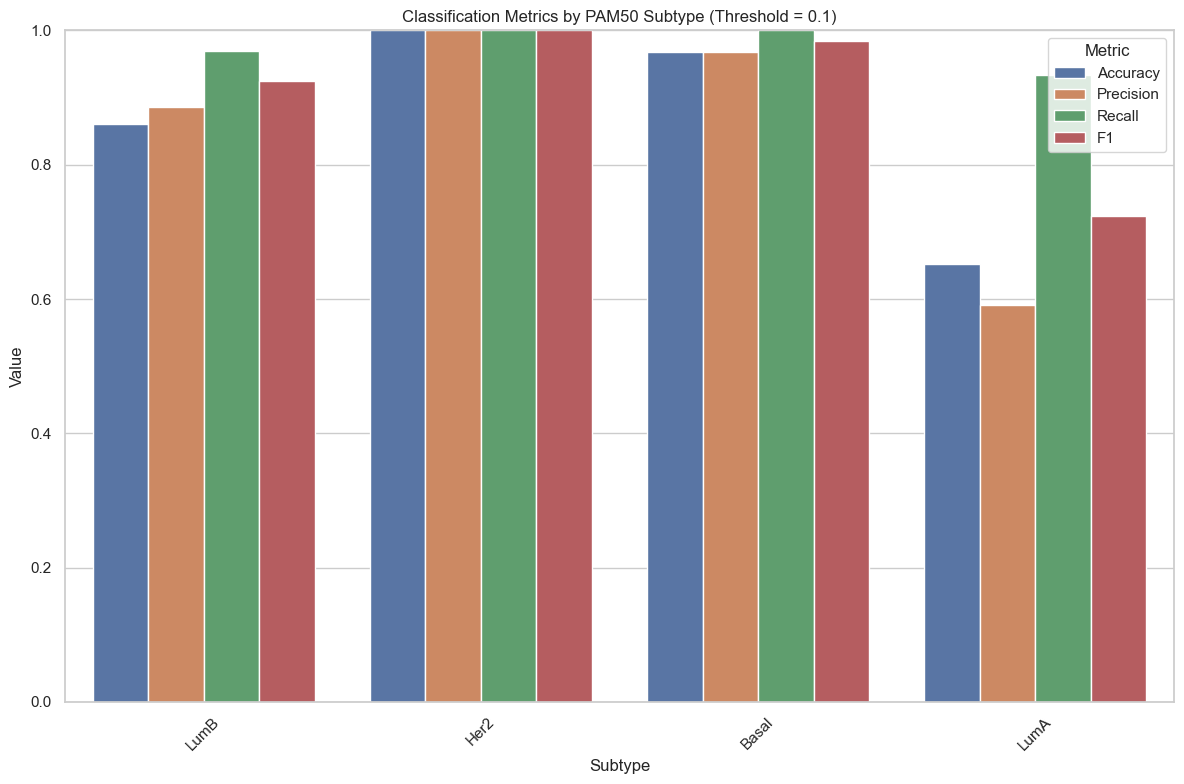

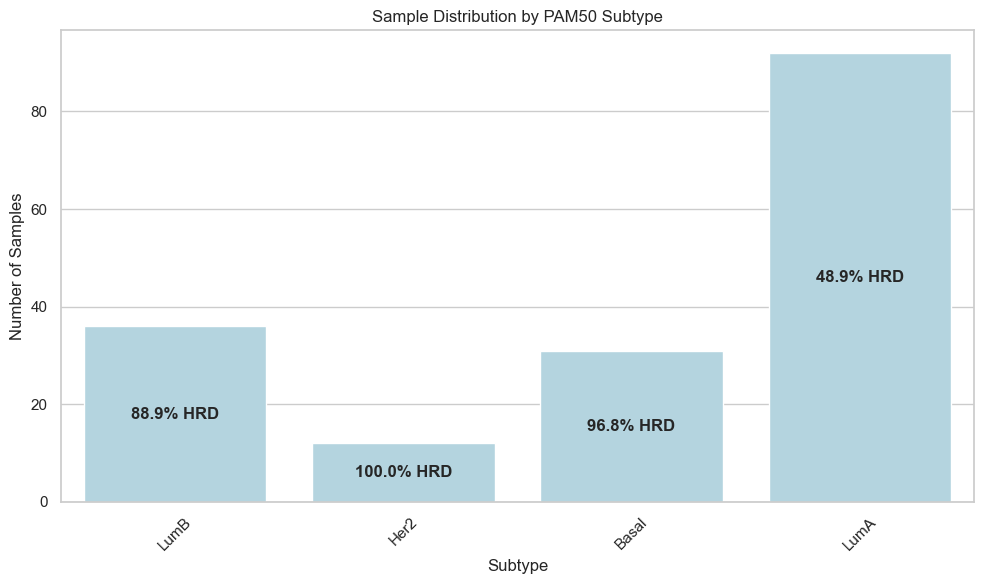


Analyzing performance by PAM50 subtype (threshold = 0.2):

Metrics by PAM50 Subtype (Threshold = 0.2):

Subtype: LumB (n=36, HRD: 30, 83.3%)
Accuracy: 0.889
Precision: 0.882
Recall: 1.000
F1 Score: 0.938
Note: All Her2 samples have the same true value (1)

Subtype: Her2 (n=12, HRD: 12, 100.0%)
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1 Score: 1.000

Subtype: Basal (n=31, HRD: 29, 93.5%)
Accuracy: 0.935
Precision: 0.935
Recall: 1.000
F1 Score: 0.967

Subtype: LumA (n=92, HRD: 40, 43.5%)
Accuracy: 0.728
Precision: 0.642
Recall: 0.850
F1 Score: 0.731
Skipping nan (insufficient samples: 0)


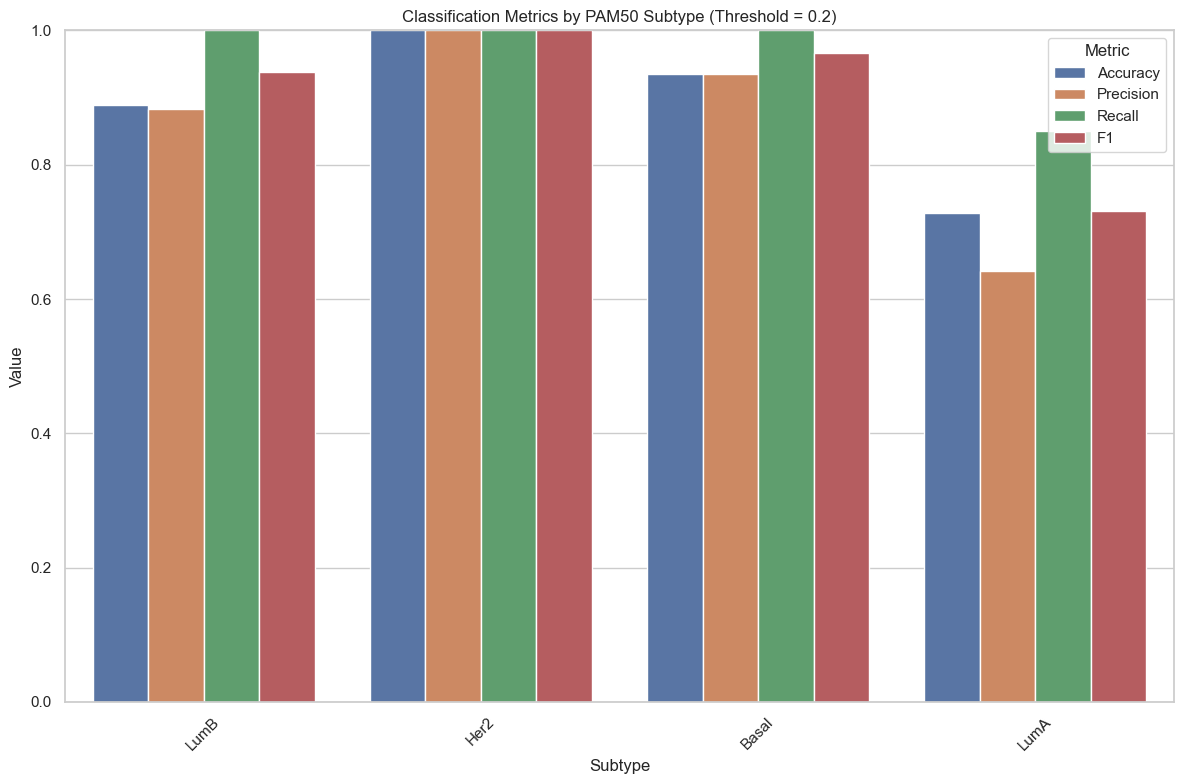

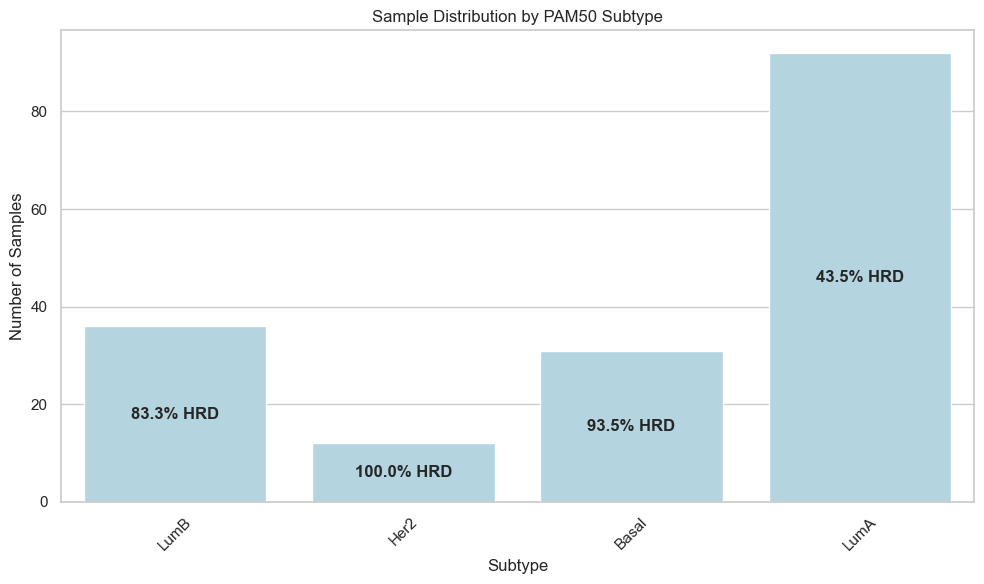


Analyzing performance by PAM50 subtype (threshold = 0.3):

Metrics by PAM50 Subtype (Threshold = 0.3):

Subtype: LumB (n=36, HRD: 27, 75.0%)
Accuracy: 0.861
Precision: 0.844
Recall: 1.000
F1 Score: 0.915
Note: All Her2 samples have the same true value (1)

Subtype: Her2 (n=12, HRD: 12, 100.0%)
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1 Score: 1.000

Subtype: Basal (n=31, HRD: 29, 93.5%)
Accuracy: 0.935
Precision: 0.935
Recall: 1.000
F1 Score: 0.967

Subtype: LumA (n=92, HRD: 34, 37.0%)
Accuracy: 0.804
Precision: 0.722
Recall: 0.765
F1 Score: 0.743
Skipping nan (insufficient samples: 0)


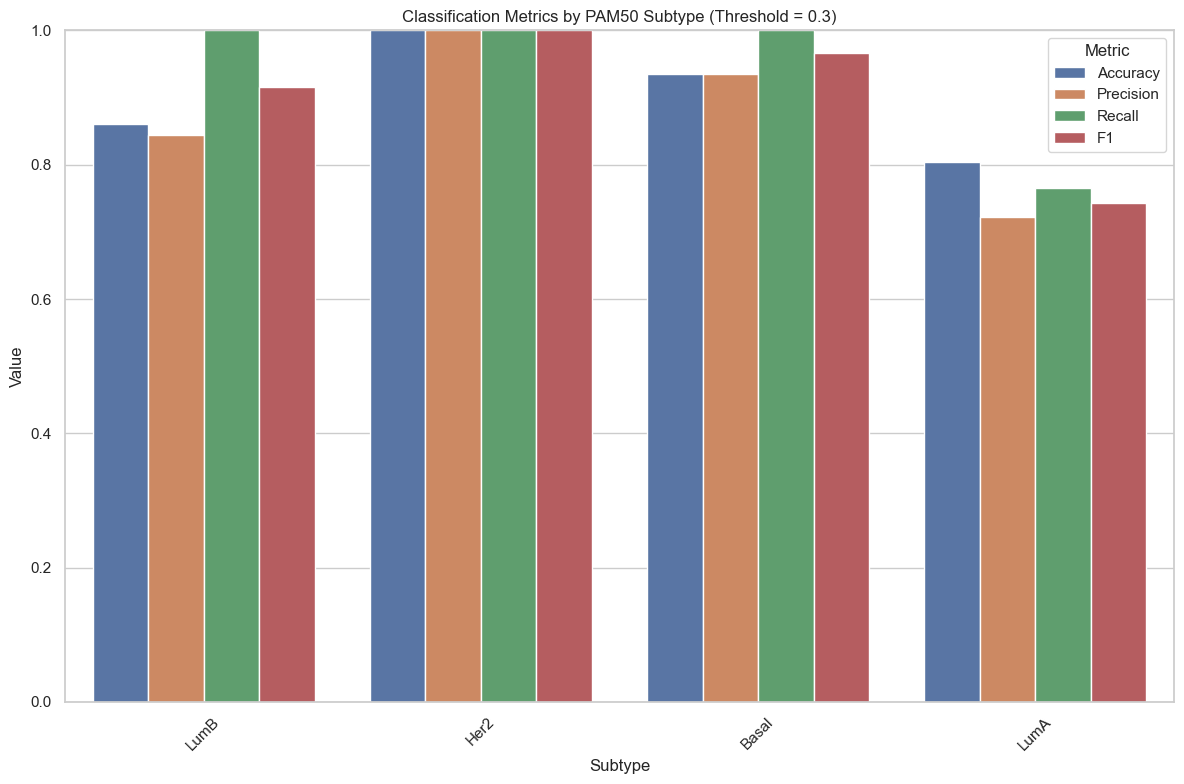

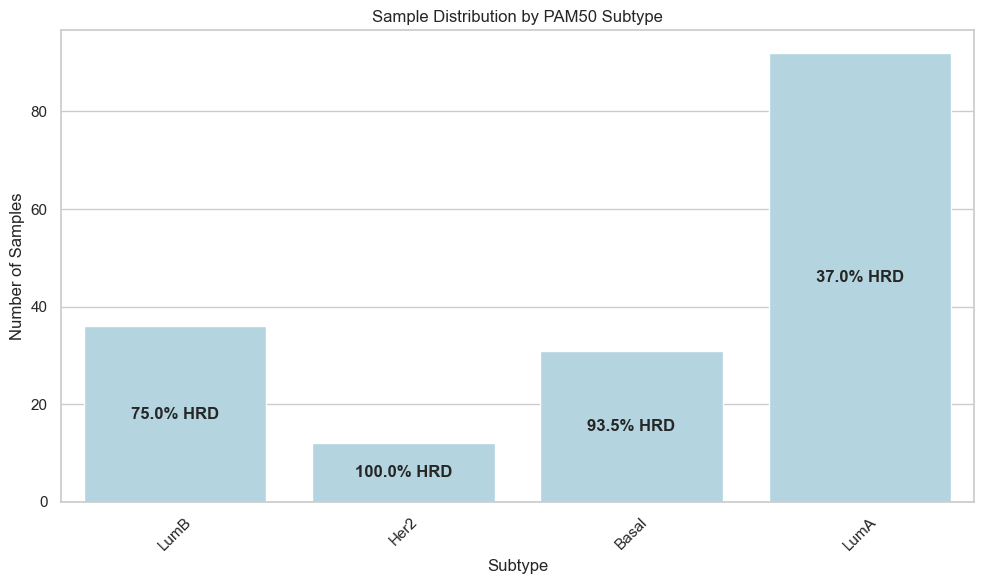


Analyzing performance by PAM50 subtype (threshold = 0.4):

Metrics by PAM50 Subtype (Threshold = 0.4):

Subtype: LumB (n=36, HRD: 24, 66.7%)
Accuracy: 0.833
Precision: 0.846
Recall: 0.917
F1 Score: 0.880

Subtype: Her2 (n=12, HRD: 11, 91.7%)
Accuracy: 0.833
Precision: 1.000
Recall: 0.818
F1 Score: 0.900

Subtype: Basal (n=31, HRD: 29, 93.5%)
Accuracy: 0.935
Precision: 0.935
Recall: 1.000
F1 Score: 0.967

Subtype: LumA (n=92, HRD: 24, 26.1%)
Accuracy: 0.804
Precision: 0.636
Recall: 0.583
F1 Score: 0.609
Skipping nan (insufficient samples: 0)


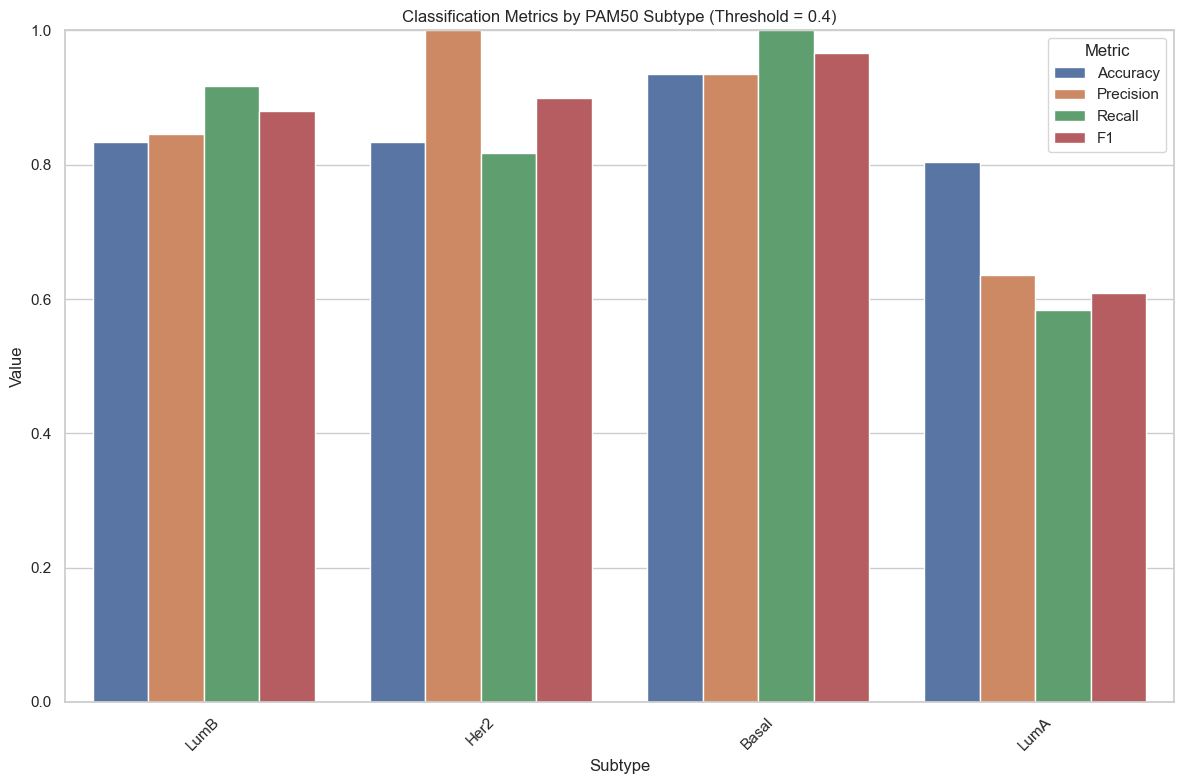

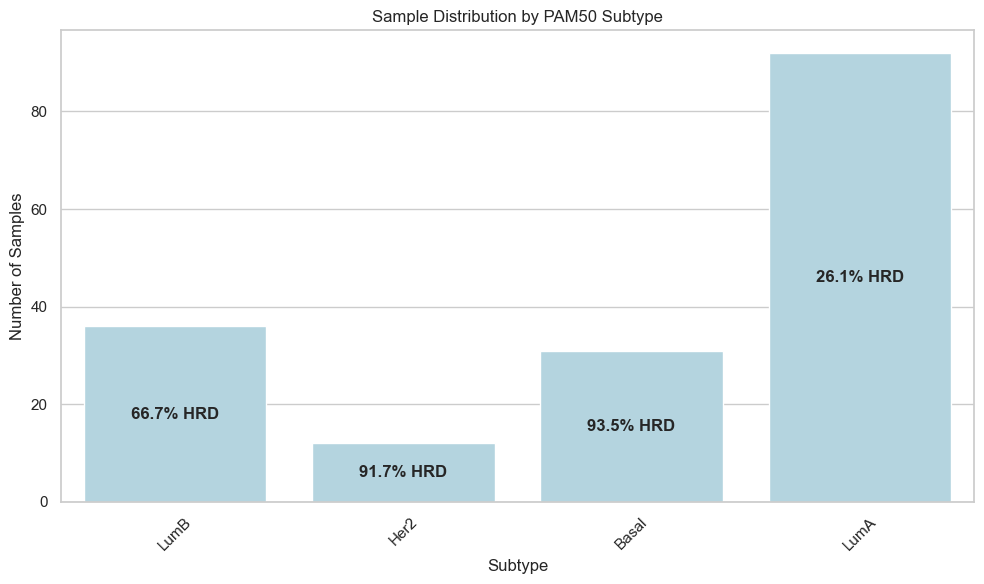


Analyzing performance by PAM50 subtype (threshold = 0.5):

Metrics by PAM50 Subtype (Threshold = 0.5):

Subtype: LumB (n=36, HRD: 19, 52.8%)
Accuracy: 0.694
Precision: 0.700
Recall: 0.737
F1 Score: 0.718

Subtype: Her2 (n=12, HRD: 8, 66.7%)
Accuracy: 0.583
Precision: 0.714
Recall: 0.625
F1 Score: 0.667

Subtype: Basal (n=31, HRD: 25, 80.6%)
Accuracy: 0.774
Precision: 0.800
Recall: 0.960
F1 Score: 0.873

Subtype: LumA (n=92, HRD: 10, 10.9%)
Accuracy: 0.870
Precision: 0.417
Recall: 0.500
F1 Score: 0.455
Skipping nan (insufficient samples: 0)


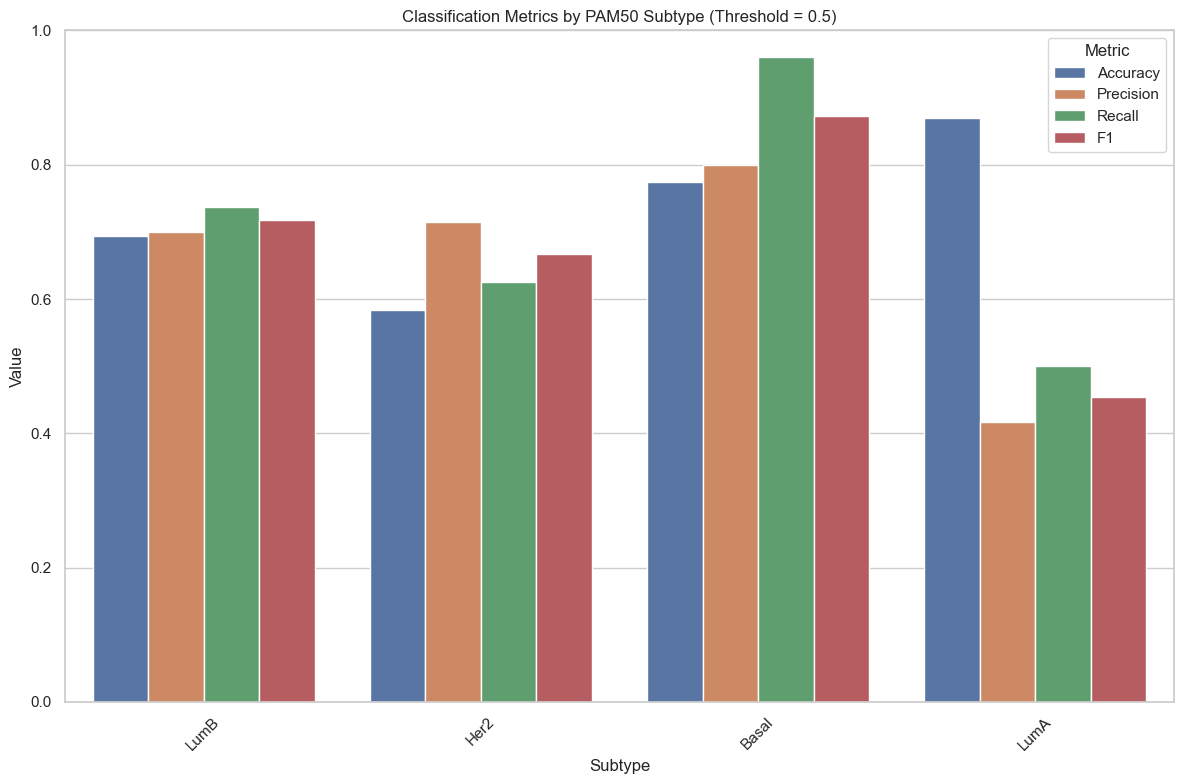

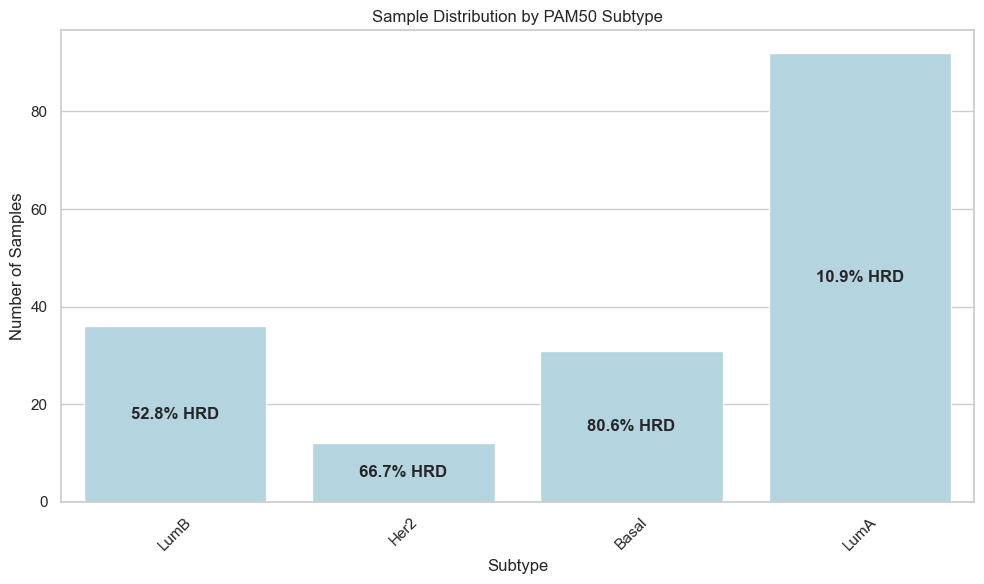


Analyzing performance by PAM50 subtype (threshold = 0.6):

Metrics by PAM50 Subtype (Threshold = 0.6):

Subtype: LumB (n=36, HRD: 15, 41.7%)
Accuracy: 0.694
Precision: 0.700
Recall: 0.467
F1 Score: 0.560

Subtype: Her2 (n=12, HRD: 3, 25.0%)
Accuracy: 0.500
Precision: 0.200
Recall: 0.333
F1 Score: 0.250

Subtype: Basal (n=31, HRD: 23, 74.2%)
Accuracy: 0.774
Precision: 0.833
Recall: 0.870
F1 Score: 0.851

Subtype: LumA (n=92, HRD: 3, 3.3%)
Accuracy: 0.957
Precision: 0.333
Recall: 0.333
F1 Score: 0.333
Skipping nan (insufficient samples: 0)


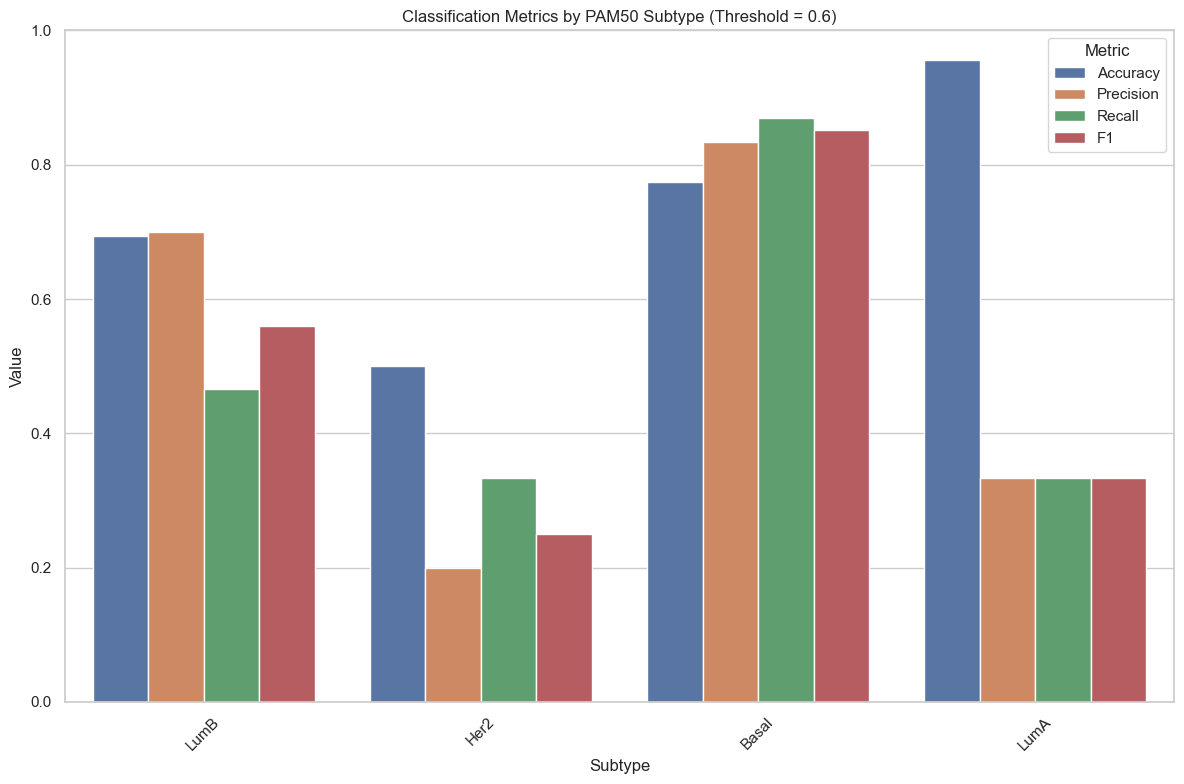

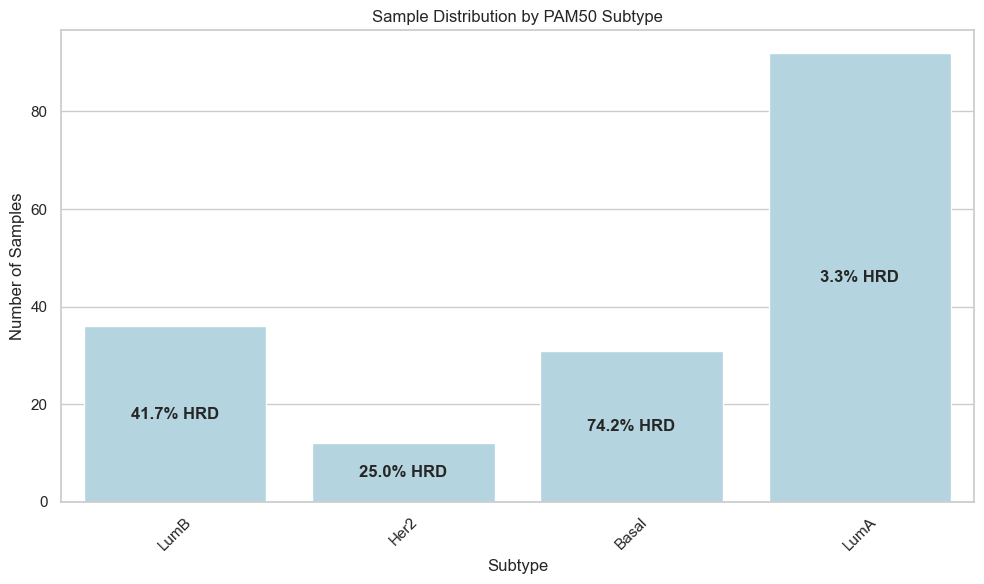


Analyzing performance by PAM50 subtype (threshold = 0.7):

Metrics by PAM50 Subtype (Threshold = 0.7):

Subtype: LumB (n=36, HRD: 13, 36.1%)
Accuracy: 0.694
Precision: 0.750
Recall: 0.231
F1 Score: 0.353

Subtype: Her2 (n=12, HRD: 2, 16.7%)
Accuracy: 0.583
Precision: 0.200
Recall: 0.500
F1 Score: 0.286

Subtype: Basal (n=31, HRD: 22, 71.0%)
Accuracy: 0.742
Precision: 0.889
Recall: 0.727
F1 Score: 0.800

Subtype: LumA (n=92, HRD: 2, 2.2%)
Accuracy: 0.967
Precision: 0.333
Recall: 0.500
F1 Score: 0.400
Skipping nan (insufficient samples: 0)


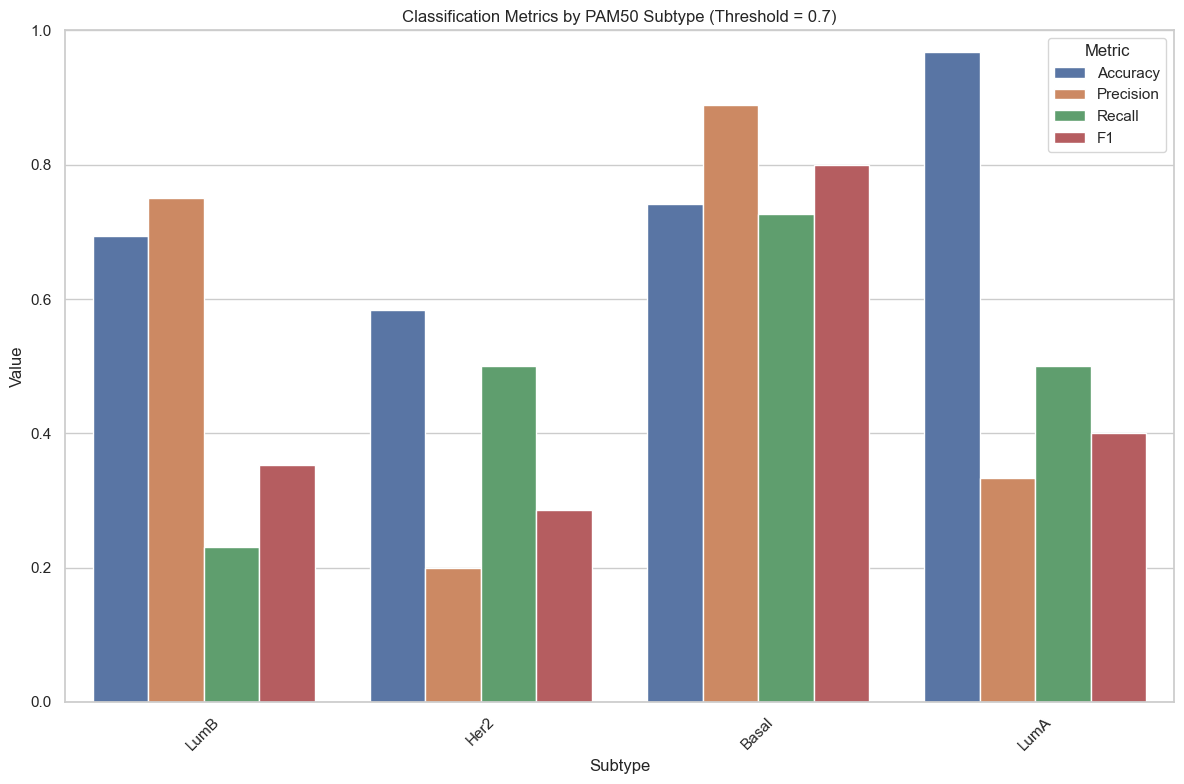

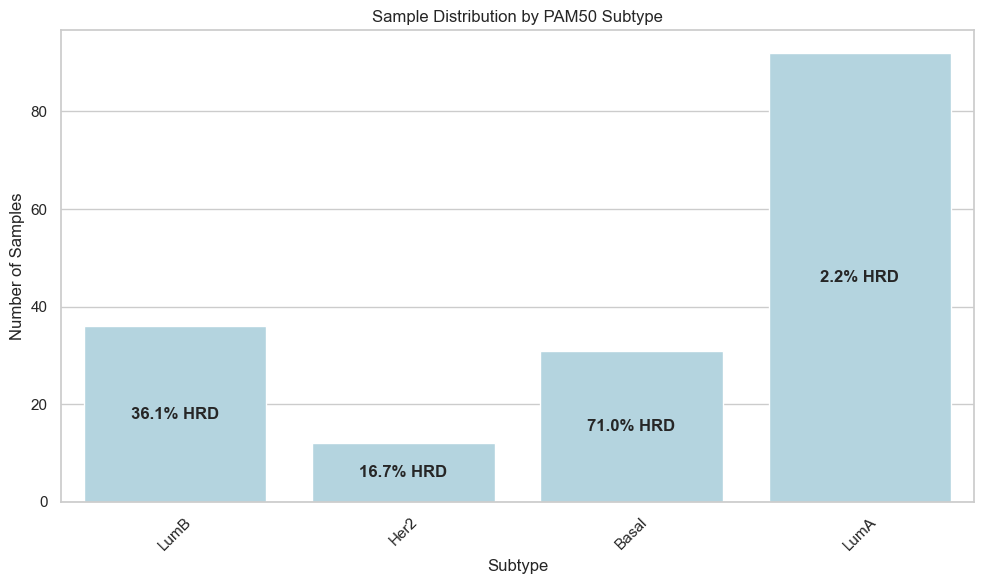


Analyzing performance by PAM50 subtype (threshold = 0.8):

Metrics by PAM50 Subtype (Threshold = 0.8):

Subtype: LumB (n=36, HRD: 11, 30.6%)
Accuracy: 0.667
Precision: 0.000
Recall: 0.000
F1 Score: 0.000

Subtype: Her2 (n=12, HRD: 1, 8.3%)
Accuracy: 0.917
Precision: 0.500
Recall: 1.000
F1 Score: 0.667

Subtype: Basal (n=31, HRD: 21, 67.7%)
Accuracy: 0.613
Precision: 0.909
Recall: 0.476
F1 Score: 0.625

Subtype: LumA (n=92, HRD: 2, 2.2%)
Accuracy: 0.967
Precision: 0.000
Recall: 0.000
F1 Score: 0.000
Skipping nan (insufficient samples: 0)


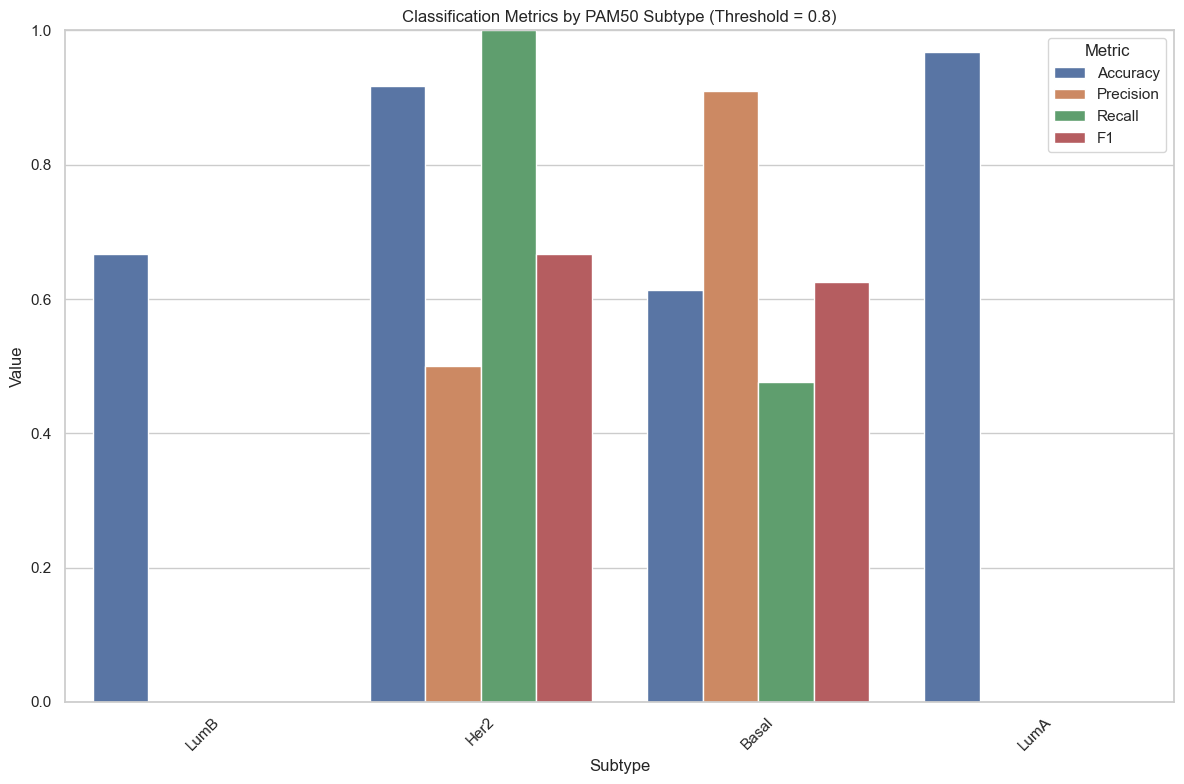

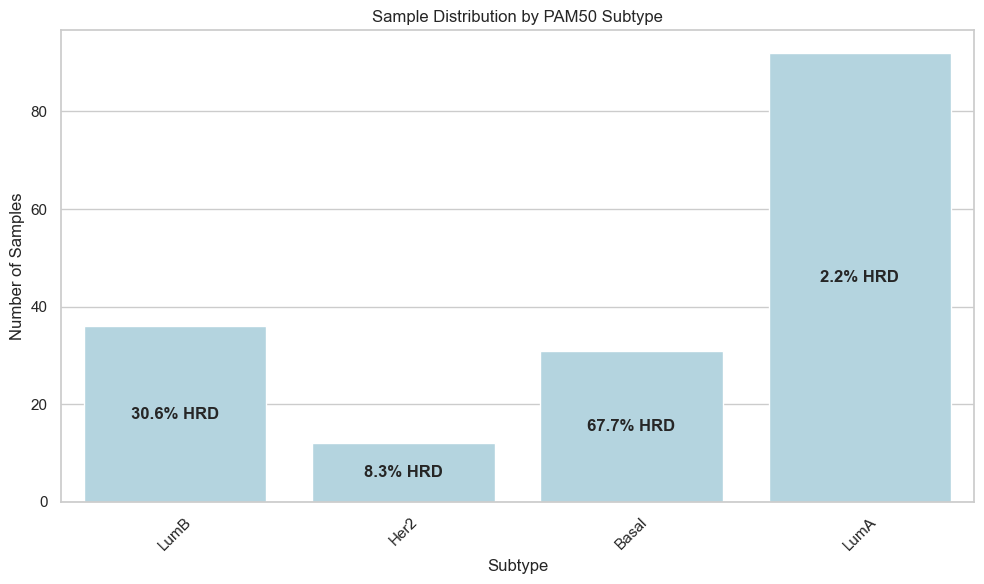


Analyzing performance by PAM50 subtype (threshold = 0.9):

Metrics by PAM50 Subtype (Threshold = 0.9):

Subtype: LumB (n=36, HRD: 10, 27.8%)
Accuracy: 0.722
Precision: 0.000
Recall: 0.000
F1 Score: 0.000

Subtype: Her2 (n=12, HRD: 1, 8.3%)
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1 Score: 1.000

Subtype: Basal (n=31, HRD: 21, 67.7%)
Accuracy: 0.452
Precision: 1.000
Recall: 0.190
F1 Score: 0.320

Subtype: LumA (n=92, HRD: 2, 2.2%)
Accuracy: 0.967
Precision: 0.000
Recall: 0.000
F1 Score: 0.000
Skipping nan (insufficient samples: 0)


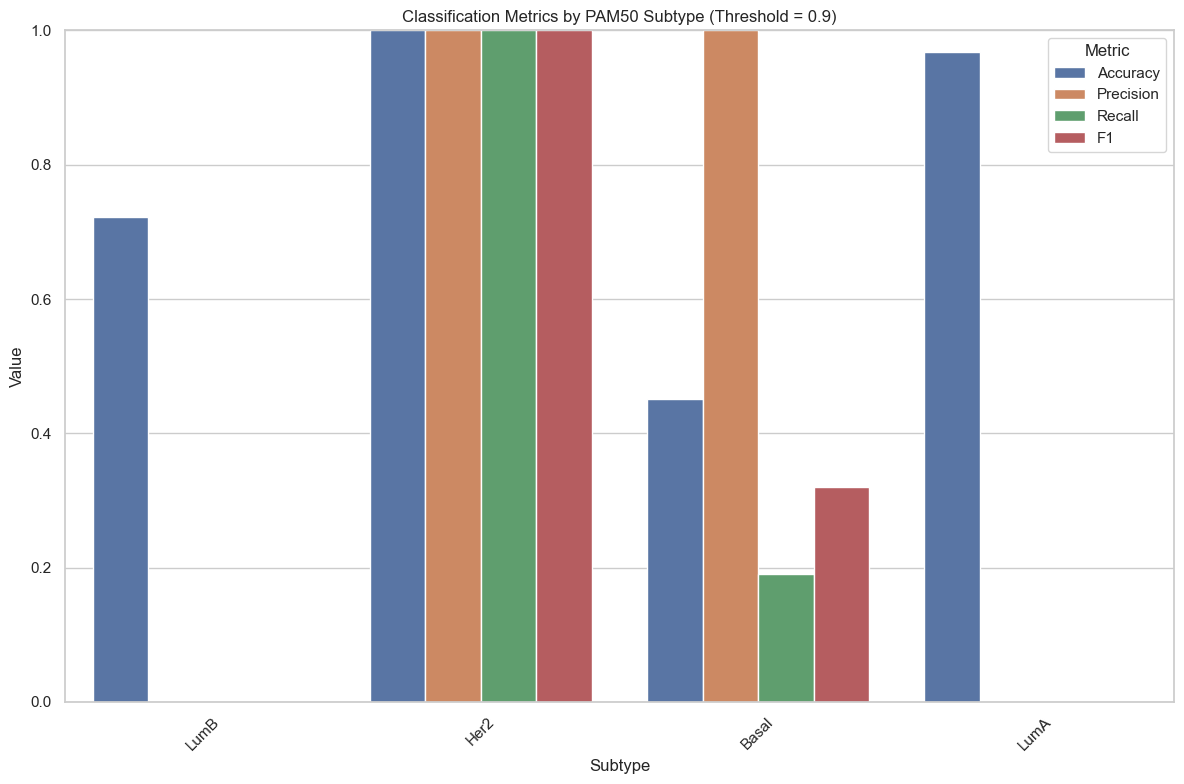

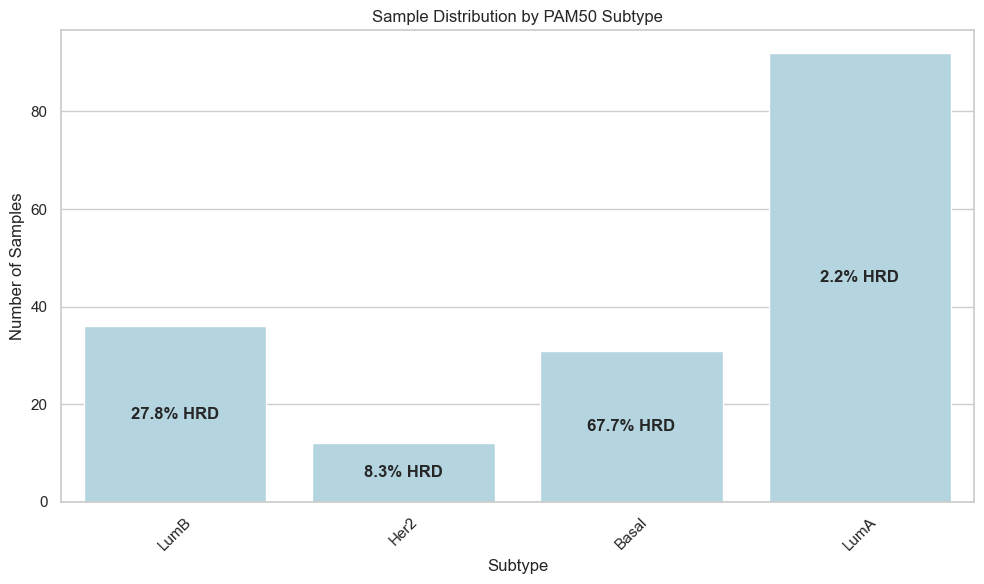

In [283]:
# After your model prediction
# Get the predictions from your regression model
y_pred_prob = LIN_elastic_net_sparse.predict(X_test)


print("\nAnalyzing performance by PAM50 subtype (threshold = 0.1):")
metrics_01 = analyze_by_pam50_subtype(y_test, y_pred_prob, threshold=0.1, metadata_full=softLabel_metadata)

print("\nAnalyzing performance by PAM50 subtype (threshold = 0.2):")
metrics_02 = analyze_by_pam50_subtype(y_test, y_pred_prob, threshold=0.2, metadata_full=softLabel_metadata)

print("\nAnalyzing performance by PAM50 subtype (threshold = 0.3):")
metrics_03 = analyze_by_pam50_subtype(y_test, y_pred_prob, threshold=0.3, metadata_full=softLabel_metadata)

print("\nAnalyzing performance by PAM50 subtype (threshold = 0.4):")
metrics_04 = analyze_by_pam50_subtype(y_test, y_pred_prob, threshold=0.4, metadata_full=softLabel_metadata)

print("\nAnalyzing performance by PAM50 subtype (threshold = 0.5):")
metrics_05 = analyze_by_pam50_subtype(y_test, y_pred_prob, threshold=0.5, metadata_full=softLabel_metadata)

print("\nAnalyzing performance by PAM50 subtype (threshold = 0.6):")
metrics_06 = analyze_by_pam50_subtype(y_test, y_pred_prob, threshold=0.6, metadata_full=softLabel_metadata)

print("\nAnalyzing performance by PAM50 subtype (threshold = 0.7):")
metrics_07 = analyze_by_pam50_subtype(y_test, y_pred_prob, threshold=0.7, metadata_full=softLabel_metadata)

print("\nAnalyzing performance by PAM50 subtype (threshold = 0.8):")
metrics_08 = analyze_by_pam50_subtype(y_test, y_pred_prob, threshold=0.8, metadata_full=softLabel_metadata)

print("\nAnalyzing performance by PAM50 subtype (threshold = 0.9):")
metrics_09 = analyze_by_pam50_subtype(y_test, y_pred_prob, threshold=0.9, metadata_full=softLabel_metadata)


In [277]:
# Count non-zero coefficients in the linear models
nonzero_coeffs_lin_deseq2 = np.sum(LIN_elastic_net_model.coef_ != 0)
nonzero_coeffs_lin_sparse = np.sum(LIN_elastic_net_sparse.coef_ != 0)
print(f"Pre-VAE feature engineering {nonzero_coeffs_lin_deseq2}, Post-VAE feature engineering {nonzero_coeffs_lin_sparse}")

Pre-VAE feature engineering 387, Post-VAE feature engineering 111


In [57]:
import numpy as np
import pandas as pd

nonzero_coeffs_lin_deseq2 = np.sum(LIN_elastic_net_model.coef_ != 0)
nonzero_coeffs_lin_sparse = np.sum(LIN_elastic_net_sparse.coef_ != 0)
print(f"Number of non-zero coefficients: {nonzero_coeffs_lin_deseq2} (DeSeq2), {nonzero_coeffs_lin_sparse} (Sparse)")

if hasattr(LIN_elastic_net_sparse, 'feature_names_in_'):
    feature_names = LIN_elastic_net_sparse.feature_names_in_
else:
    feature_names = common_sparse_genes.columns if hasattr(common_sparse_genes, 'columns') else common_sparse_genes

if len(feature_names) != len(LIN_elastic_net_sparse.coef_):
    print(f"Warning: Number of feature names ({len(feature_names)}) doesn't match number of coefficients ({len(LIN_elastic_net_sparse.coef_)})")
    feature_names = [f"Feature_{i}" for i in range(len(LIN_elastic_net_sparse.coef_))]

nonzero_indices = np.where(LIN_elastic_net_sparse.coef_ != 0)[0]
nonzero_coeffs = LIN_elastic_net_sparse.coef_[nonzero_indices]

results = pd.DataFrame({
    'Index': nonzero_indices,
    'Gene': [feature_names[i] if i < len(feature_names) else f"Unknown_{i}" for i in nonzero_indices],
    'Coefficient': nonzero_coeffs
})

results['Abs_Coefficient'] = np.abs(results['Coefficient'])
results_sorted = results.sort_values('Abs_Coefficient', ascending=False)

results_sorted = results_sorted.drop(columns=['Abs_Coefficient'])

print("\nTop genes with non-zero coefficients (sorted by absolute value):")
print(results_sorted)

results_sorted.to_csv('data/nonzero_genes.csv', index=False)


positive_coefs = np.sum(results_sorted['Coefficient'] > 0)
negative_coefs = np.sum(results_sorted['Coefficient'] < 0)
print(f"\nSummary: {positive_coefs} positive coefficients, {negative_coefs} negative coefficients")

print("\nList of genes with non-zero coefficients:")
for gene in results_sorted['Gene'].values:
    print(gene)

Number of non-zero coefficients: 387 (DeSeq2), 111 (Sparse)

Top genes with non-zero coefficients (sorted by absolute value):
     Index      Gene  Coefficient
42     107      TPT1    -0.052191
89     204    RPL35A     0.051923
100    227    MT-CO2     0.038343
16      46     GATA3    -0.035671
60     142     RPL32     0.034580
..     ...       ...          ...
15      45      EDF1    -0.000872
94     214   S100A16    -0.000593
104    246   MT-ATP8     0.000542
39     103   SH3BGRL    -0.000251
17      49  LGALS3BP     0.000129

[111 rows x 3 columns]

Summary: 54 positive coefficients, 57 negative coefficients

List of genes with non-zero coefficients:
TPT1
RPL35A
MT-CO2
GATA3
RPL32
TUBB
PRDX5
RHOB
P4HB
MUC1
APP
RPL11
RPS25
SDC4
XBP1
CFL1
GPX4
H1-2
RPL34
RHOA
YWHAQ
HSP90AB1
RPS27A
HDGF
PABPC1
COL6A1
RPS2
GPX1
RPL7
CXCL14
ARF1
MYH9
MORF4L2
SLC9A3R1
PEBP1
YWHAE
AZGP1
FN1
RPS4X
DHCR24
DAD1
PDIA3
LTF
MT-CYB
UBC
RPS21
EZR
PSAP
IGFBP4
AGR2
CPB1
MT-ND6
LDHA
CCT3
HLA-DRA
SRP9
SRP14
YWHAZ
IFIT

# Shruken Signature Validation on External Datasets

# ISPY BINARY without Shruken Validatiaon

In [58]:
import pandas as pd
import numpy as np

In [59]:
ispy2_expr = pd.read_csv('data/validation/GSE173839_ISPY2_AgilentGeneExp_durvaPlusCtr_FFPE_meanCol_geneLevel_n105.txt', sep = '\t')
ispy2_expr.set_index('GeneName', inplace=True)
ispy2_expr_transposed = ispy2_expr.T
ispy2_expr_transposed.sort_index(inplace=True)
ispy2_expr_transposed.dropna(inplace=True)

In [60]:
ispy2_expr

671271  856496  111922  965961  549018  337915  751468  446038  \
GeneName                                                                    
1060P11.3   6.708   6.640   6.728   6.675   6.552   6.822   6.204   6.106   
A1BG       10.530  10.380  11.580   9.102   9.592  10.220  10.210  10.230   
A1BG-AS1    7.409   7.666   8.134   7.306   7.860   8.394   7.621   7.782   
A1CF        6.130   5.370   5.782   6.144   6.235   6.551   5.792   5.760   
A2M        10.450   9.582   9.978   9.082   9.447   8.827   9.207   9.656   
...           ...     ...     ...     ...     ...     ...     ...     ...   
ZYG11A      6.088   5.312   5.600   5.536   5.964   5.515   6.270   5.312   
ZYG11B      6.577   7.022   6.732   7.080   6.516   6.773   7.035   7.510   
ZYX        11.100  10.680  11.000  11.000  10.750  10.260  10.200  11.110   
ZZEF1       6.087   6.565   5.960   6.860   6.987   6.412   7.328   6.996   
ZZZ3        8.436   8.340   8.396   8.144   8.021   7.914   8.268   8.134   

           639629  802319  ...  652071  265106  795270  872208  496973  \
GeneName                   ...                                           
1060P11.3   5.893   6.342  ...   7.167   5.817   5.696   5.486   6.273   
A1BG        9.745  12.050  ...  10.350  10.330   9.255  11.480  10.050   
A1BG-AS1    8.245   9.243  ...   7.906   8.073   7.501   8.989   8.227   
A1CF        5.243   5.847  ...   6.568   5.792   6.306   5.458   6.671   
A2M         9.274   8.008  ...   9.412  10.520  10.540   9.466  10.600   
...           ...     ...  ...     ...     ...     ...     ...     ...   
ZYG11A      4.966   5.805  ...   6.032   5.957   4.976   6.758   6.612   
ZYG11B      7.256   6.575  ...   6.894   7.003   6.765   6.857   6.750   
ZYX        10.800  10.950  ...  10.260  10.460  10.650  11.020  10.520   
ZZEF1       6.268   6.468  ...   6.752   6.603   7.022   6.144   7.232   
ZZZ3        8.997   8.046  ...   8.858   8.529   9.328   8.680   8.504   

           194365  989123  524763  384454  979809  
GeneName                                           
1060P11.3   6.128   6.512   6.924   6.555   7.829  
A1BG       11.040  10.060   9.699   9.875  10.190  
A1BG-AS1    9.011   8.447   8.366   8.004   7.807  
A1CF        6.406   6.450   6.320   6.226   7.014  
A2M        10.000  11.230  10.110   8.230  10.630  
...           ...     ...     ...     ...     ...  
ZYG11A      5.928   5.998   5.940   6.015   6.987  
ZYG11B      6.872   7.030   6.588   6.365   7.046  
ZYX        10.460  10.060  11.000  10.130  10.770  
ZZEF1       6.868   6.777   6.805   6.520   6.964  
ZZZ3        8.932   9.020   7.835   8.575   8.330  

[21508 rows x 105 columns]

In [61]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

# Step 1: Identify common features
common_features = list(set(common_de_genes) & set(ispy2_expr_transposed.columns))

# Step 2: Create a new DataFrame instead of a view
validation_subset = ispy2_expr_transposed.loc[:, common_features].copy()

# Step 3: Handle missing features using loc
missing_features = [feature for feature in common_de_genes.columns if feature not in common_features]

# Add missing features using loc
for feature in missing_features:
    validation_subset.loc[:, feature] = 0  # Use 0, or the training mean/median if available

# Step 4: Reorder columns to match training order
validation_subset = validation_subset[common_de_genes.columns]

# Step 5: Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(validation_subset)

predictions = enet_de_model.predict(scaled_data)


In [62]:
print(predictions)

[0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 0
 0 1 1 1 1 0]


In [63]:
predictions_LIN = LIN_elastic_net_model.predict(scaled_data)

In [64]:
print(predictions_LIN)

[ 0.31258829  0.27445033  0.78249693  0.61497287  0.51456652  0.19388373
  0.15540792  0.19587654  0.19621989  0.58246003  0.32061983  0.42415746
  0.96817058  0.43676828  0.48438194  0.27717241  0.13325366  0.30661431
  0.63832061  0.77531104  0.37701021  0.80698918  0.32653498  0.47870906
  0.37478528  0.63860897  0.48378415  0.190263    0.5343912   0.4793005
  0.42408377  0.32258032  0.36914025  0.31574903  0.77566197  0.29207892
  0.37857532  0.74107511  0.39946141  0.30798404  0.55090415  0.34355954
  0.31518776  0.33428826  0.32785714  0.59833689  0.42112481  0.51739355
 -0.08053919  0.79580029  0.4603934   0.33435531  0.41134426 -0.04195399
  0.60502905  0.74277872  0.61262334  0.71655368  0.16955945  0.06994069
  0.55941791  0.829676    0.26582007  0.58231737  0.46537206  0.30047801
  0.57481809  0.74571954  0.22371815  0.00653674  0.32060513  0.08486633
  0.71939727  0.42067312  0.36209782  0.61359124  0.64012449  0.50995001
  0.43308293  0.18646337]


In [65]:
#predictions

In [66]:
ispy2_response = pd.read_csv('data/validation/GSE173839_ISPY2_DurvalumabOlaparibArm_biomarkers.csv')
ispy2_response.loc[ispy2_response["pCR.status"] == -1, "pCR.status"] = (
    0  # present in control arm
)

ispy2_response.sort_values(by='ResearchID', inplace=True)
ispy2_response["ResearchID"] = ispy2_response["ResearchID"].astype(str).str.strip()
ispy2_expr = ispy2_expr[ispy2_response["ResearchID"]]
ispy2_response.set_index('ResearchID', inplace=True)

In [67]:
# Find the common indices
common_indices = ispy2_expr_transposed.index.intersection(ispy2_response.index)

# Filter both DataFrames for the common indices, maintaining the order
filtered_ispy_probe = ispy2_expr_transposed.loc[common_indices]
filtered_ispy_response = ispy2_response.loc[common_indices]
filtered_ispy_response['predictions_binary'] = predictions
filtered_ispy_response['predictions_linear'] = predictions_LIN

In [68]:
px.box(filtered_ispy_response, y ='predictions_linear', x = 'pCR.status', points = "all", title = f"Distribution of regression scores between patients' complete pathological response")

In [69]:
# two sided welch's t test taking pCR into accont
from scipy.stats import ttest_ind, mannwhitneyu
stats = {}

group_0 = filtered_ispy_response.loc[filtered_ispy_response['pCR.status'] == 0, 'predictions_linear']
group_1 = filtered_ispy_response.loc[filtered_ispy_response['pCR.status'] == 1, 'predictions_linear']


t_stat, p_value_t = ttest_ind(group_0, group_1, equal_var=False)
print(f"Welch's t-test: t = {t_stat:.4f}, p = {p_value_t:.4f}")

u_stat, p_value_u = mannwhitneyu(group_0, group_1, alternative='two-sided')
print(f"Mann-Whitney U test: U = {u_stat:.4f}, p = {p_value_u:.4f}")

Welch's t-test: t = -2.2448, p = 0.0288
Mann-Whitney U test: U = 533.0000, p = 0.0498


In [70]:
from scipy.stats import pearsonr
import numpy as np
import plotly.express as px

# Data for plotting
x = filtered_ispy_response['PARPi7_sig.']
y = filtered_ispy_response['predictions_linear']

# Calculate Pearson R and p-value
r_value, p_value = pearsonr(x, y)

# Create the scatter plot with an adjusted color palette
fig = px.scatter(
    filtered_ispy_response,
    x='PARPi7_sig.',
    y='predictions_linear',
    title=f"Regression scores between patients against PARPi7 sig scores",
    labels={'PARPi7_sig.': 'PARPi7 Signal', 'predictions': 'Predictions'},
    color='pCR.status',
    trendline="ols",  # Add regression line
    color_continuous_scale='magenta'  # Use a more subtle color palette
)

# Add R value and p-value as annotation
fig.add_annotation(
    x=np.mean(x), 
    y=np.max(y),
    text=f"Pearson R: {r_value:.2f}<br>p-value: {p_value:.2e}",
    showarrow=False,
    font=dict(size=14, color="black"),
    align="center",
    bordercolor="black",
    borderwidth=1,
    borderpad=4,
    bgcolor="white",
    opacity=1.0
)

# Show the plot
fig.show()


In [60]:
px.box(filtered_ispy_response, x ='predictions_binary', y = 'PARPi7_sig.', points = "all", title = f"Comparison of HR(0) and HRD(1) distributions agianst PARPi7 values", color = 'predictions_binary')

In [61]:
px.box(filtered_ispy_response, x ='predictions_binary', y = 'PARPi7_sig.', color = 'pCR.status', title = f"Comparison of HR(0) and HRD(1) distributions agianst PARPi7 values and pCR", points = "all")

In [62]:
# two sided welch's t test WITHOUT taking pCR into accont
from scipy.stats import ttest_ind, mannwhitneyu
stats = {}

group_0 = filtered_ispy_response.loc[filtered_ispy_response['predictions_binary'] == 0, 'PARPi7_sig.']
group_1 = filtered_ispy_response.loc[filtered_ispy_response['predictions_binary'] == 1, 'PARPi7_sig.']


t_stat, p_value_t = ttest_ind(group_0, group_1, equal_var=False)
print(f"Welch's t-test: t = {t_stat:.4f}, p = {p_value_t:.4f}")

u_stat, p_value_u = mannwhitneyu(group_0, group_1, alternative='two-sided')
print(f"Mann-Whitney U test: U = {u_stat:.4f}, p = {p_value_u:.4f}")

Welch's t-test: t = -3.7532, p = 0.0004
Mann-Whitney U test: U = 398.0000, p = 0.0009


In [63]:
from scipy.stats import ttest_ind, mannwhitneyu

# Filter the data into two groups based on predictions and pCR.status
group_0 = filtered_ispy_response.loc[
    (filtered_ispy_response['predictions_binary'] == 0) & (filtered_ispy_response['pCR.status'] == 0),
    'PARPi7_sig.'
]

group_1 = filtered_ispy_response.loc[
    (filtered_ispy_response['predictions_binary'] == 1) & (filtered_ispy_response['pCR.status'] == 1),
    'PARPi7_sig.'
]

# Perform Welch's t-test
t_stat, p_value_t = ttest_ind(group_0, group_1, equal_var=False)
print(f"Welch's t-test: t = {t_stat:.4f}, p = {p_value_t:.4f}")

# Perform Mann-Whitney U test
u_stat, p_value_u = mannwhitneyu(group_0, group_1, alternative='two-sided')
print(f"Mann-Whitney U test: U = {u_stat:.4f}, p = {p_value_u:.4f}")

Welch's t-test: t = -4.8161, p = 0.0000
Mann-Whitney U test: U = 85.0000, p = 0.0002


# ISPY BINARY with Shrunken Input List

In [64]:
import pandas as pd
import numpy as np

In [65]:
ispy2_expr = pd.read_csv('data/validation/GSE173839_ISPY2_AgilentGeneExp_durvaPlusCtr_FFPE_meanCol_geneLevel_n105.txt', sep = '\t')
ispy2_expr.set_index('GeneName', inplace=True)
ispy2_expr_transposed = ispy2_expr.T
ispy2_expr_transposed.sort_index(inplace=True)
ispy2_expr_transposed.dropna(inplace=True)

In [66]:
ispy2_expr

671271  856496  111922  965961  549018  337915  751468  446038  \
GeneName                                                                    
1060P11.3   6.708   6.640   6.728   6.675   6.552   6.822   6.204   6.106   
A1BG       10.530  10.380  11.580   9.102   9.592  10.220  10.210  10.230   
A1BG-AS1    7.409   7.666   8.134   7.306   7.860   8.394   7.621   7.782   
A1CF        6.130   5.370   5.782   6.144   6.235   6.551   5.792   5.760   
A2M        10.450   9.582   9.978   9.082   9.447   8.827   9.207   9.656   
...           ...     ...     ...     ...     ...     ...     ...     ...   
ZYG11A      6.088   5.312   5.600   5.536   5.964   5.515   6.270   5.312   
ZYG11B      6.577   7.022   6.732   7.080   6.516   6.773   7.035   7.510   
ZYX        11.100  10.680  11.000  11.000  10.750  10.260  10.200  11.110   
ZZEF1       6.087   6.565   5.960   6.860   6.987   6.412   7.328   6.996   
ZZZ3        8.436   8.340   8.396   8.144   8.021   7.914   8.268   8.134   

           639629  802319  ...  652071  265106  795270  872208  496973  \
GeneName                   ...                                           
1060P11.3   5.893   6.342  ...   7.167   5.817   5.696   5.486   6.273   
A1BG        9.745  12.050  ...  10.350  10.330   9.255  11.480  10.050   
A1BG-AS1    8.245   9.243  ...   7.906   8.073   7.501   8.989   8.227   
A1CF        5.243   5.847  ...   6.568   5.792   6.306   5.458   6.671   
A2M         9.274   8.008  ...   9.412  10.520  10.540   9.466  10.600   
...           ...     ...  ...     ...     ...     ...     ...     ...   
ZYG11A      4.966   5.805  ...   6.032   5.957   4.976   6.758   6.612   
ZYG11B      7.256   6.575  ...   6.894   7.003   6.765   6.857   6.750   
ZYX        10.800  10.950  ...  10.260  10.460  10.650  11.020  10.520   
ZZEF1       6.268   6.468  ...   6.752   6.603   7.022   6.144   7.232   
ZZZ3        8.997   8.046  ...   8.858   8.529   9.328   8.680   8.504   

           194365  989123  524763  384454  979809  
GeneName                                           
1060P11.3   6.128   6.512   6.924   6.555   7.829  
A1BG       11.040  10.060   9.699   9.875  10.190  
A1BG-AS1    9.011   8.447   8.366   8.004   7.807  
A1CF        6.406   6.450   6.320   6.226   7.014  
A2M        10.000  11.230  10.110   8.230  10.630  
...           ...     ...     ...     ...     ...  
ZYG11A      5.928   5.998   5.940   6.015   6.987  
ZYG11B      6.872   7.030   6.588   6.365   7.046  
ZYX        10.460  10.060  11.000  10.130  10.770  
ZZEF1       6.868   6.777   6.805   6.520   6.964  
ZZZ3        8.932   9.020   7.835   8.575   8.330  

[21508 rows x 105 columns]

In [67]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

# Step 1: Identify common features
common_features = list(set(common_sparse_genes) & set(ispy2_expr_transposed.columns))

# Step 2: Create a new DataFrame instead of a view
validation_subset = ispy2_expr_transposed.loc[:, common_features].copy()

# Step 3: Handle missing features using loc
missing_features = [feature for feature in common_sparse_genes.columns if feature not in common_features]

# Add missing features using loc
for feature in missing_features:
    validation_subset.loc[:, feature] = 0  # Use 0, or the training mean/median if available

# Step 4: Reorder columns to match training order
validation_subset = validation_subset[common_sparse_genes.columns]

# Step 5: Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(validation_subset)

# predictions = enet_de_model.predict(scaled_data)
predictions = enet_sparse_model.predict(scaled_data)


In [68]:
print(predictions)

[0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0
 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 1 1 0 0 1 0 1 0
 0 0 0 0 1 0]


In [69]:
predictions_LIN = LIN_elastic_net_sparse.predict(scaled_data)

In [70]:
print(predictions_LIN)

[ 0.28357018  0.40287887  0.81336086  0.58875042  0.3070727   0.34021829
  0.08536338 -0.06272643  0.25016792  0.44334652  0.32132948  0.41114042
  0.81790916  0.72636543  0.31646595  0.12053518  0.15655231  0.11059524
  0.3791776   0.76114933  0.39335672  0.62400259  0.47380623  0.49926221
  0.45014764  0.56305626  0.4066428   0.29029374  0.34075544  0.34124246
  0.75051247  0.24014207  0.49816622  0.29049715  0.77946711  0.31105381
  0.33144455  0.61444619  0.2558484   0.31165147  0.38325528  0.32973094
  0.57541381  0.48165796  0.49797733  0.40243934  0.38574809  0.71172239
 -0.12553924  0.72091399  0.73298626  0.31696389  0.4473697   0.0839363
  0.6842537   0.67271815  0.52015365  0.66850266  0.0581978   0.14548323
  0.47064809  0.71364264  0.36354933  0.66086366  0.53625754  0.25721872
  0.72374512  0.70585958  0.20333594 -0.04609779  0.39137835  0.12831524
  0.76137487  0.57007339  0.64184496  0.53882416  0.46033609  0.71261216
  0.60909704  0.21793995]


In [71]:
#predictions

In [72]:
ispy2_response = pd.read_csv('data/validation/GSE173839_ISPY2_DurvalumabOlaparibArm_biomarkers.csv')
ispy2_response.loc[ispy2_response["pCR.status"] == -1, "pCR.status"] = (
    0  # present in control arm
)

ispy2_response.sort_values(by='ResearchID', inplace=True)
ispy2_response["ResearchID"] = ispy2_response["ResearchID"].astype(str).str.strip()
ispy2_expr = ispy2_expr[ispy2_response["ResearchID"]]
ispy2_response.set_index('ResearchID', inplace=True)

In [73]:
# Find the common indices
common_indices = ispy2_expr_transposed.index.intersection(ispy2_response.index)

# Filter both DataFrames for the common indices, maintaining the order
filtered_ispy_probe = ispy2_expr_transposed.loc[common_indices]
filtered_ispy_response = ispy2_response.loc[common_indices]
filtered_ispy_response['predictions_binary'] = predictions
filtered_ispy_response['predictions_linear'] = predictions_LIN

In [74]:
px.box(filtered_ispy_response, y ='predictions_linear', x = 'pCR.status', points = "all", title = f"Distribution of regression scores between patients' complete pathological response")

In [75]:
# two sided welch's t test taking pCR into accont
from scipy.stats import ttest_ind, mannwhitneyu
stats = {}

group_0 = filtered_ispy_response.loc[filtered_ispy_response['pCR.status'] == 0, 'predictions_linear']
group_1 = filtered_ispy_response.loc[filtered_ispy_response['pCR.status'] == 1, 'predictions_linear']


t_stat, p_value_t = ttest_ind(group_0, group_1, equal_var=False)
print(f"Welch's t-test: t = {t_stat:.4f}, p = {p_value_t:.4f}")

u_stat, p_value_u = mannwhitneyu(group_0, group_1, alternative='two-sided')
print(f"Mann-Whitney U test: U = {u_stat:.4f}, p = {p_value_u:.4f}")

Welch's t-test: t = -3.0785, p = 0.0030
Mann-Whitney U test: U = 465.0000, p = 0.0081


In [76]:
from scipy.stats import pearsonr
import numpy as np
import plotly.express as px

# Data for plotting
x = filtered_ispy_response['PARPi7_sig.']
y = filtered_ispy_response['predictions_linear']

# Calculate Pearson R and p-value
r_value, p_value = pearsonr(x, y)

# Create the scatter plot with an adjusted color palette
fig = px.scatter(
    filtered_ispy_response,
    x='PARPi7_sig.',
    y='predictions_linear',
    title=f"Regression scores between patients against PARPi7 sig scores",
    labels={'PARPi7_sig.': 'PARPi7 Signal', 'predictions': 'Predictions'},
    color='pCR.status',
    trendline="ols",  # Add regression line
    color_continuous_scale='magenta'  # Use a more subtle color palette
)

# Add R value and p-value as annotation
fig.add_annotation(
    x=np.mean(x), 
    y=np.max(y),
    text=f"Pearson R: {r_value:.2f}<br>p-value: {p_value:.2e}",
    showarrow=False,
    font=dict(size=14, color="black"),
    align="center",
    bordercolor="black",
    borderwidth=1,
    borderpad=4,
    bgcolor="white",
    opacity=1.0
)

# Show the plot
fig.show()


In [77]:
px.box(filtered_ispy_response, x ='predictions_binary', y = 'PARPi7_sig.', points = "all", title = f"Comparison of HR(0) and HRD(1) distributions agianst PARPi7 values", color = 'predictions_binary')

In [78]:
px.box(filtered_ispy_response, x ='predictions_binary', y = 'PARPi7_sig.', color = 'pCR.status', title = f"Comparison of HR(0) and HRD(1) distributions agianst PARPi7 values and pCR", points = "all")

In [79]:
# two sided welch's t test WITHOUT taking pCR into accont
from scipy.stats import ttest_ind, mannwhitneyu
stats = {}

group_0 = filtered_ispy_response.loc[filtered_ispy_response['predictions_binary'] == 0, 'PARPi7_sig.']
group_1 = filtered_ispy_response.loc[filtered_ispy_response['predictions_binary'] == 1, 'PARPi7_sig.']


t_stat, p_value_t = ttest_ind(group_0, group_1, equal_var=False)
print(f"Welch's t-test: t = {t_stat:.4f}, p = {p_value_t:.4f}")

u_stat, p_value_u = mannwhitneyu(group_0, group_1, alternative='two-sided')
print(f"Mann-Whitney U test: U = {u_stat:.4f}, p = {p_value_u:.4f}")

Welch's t-test: t = -3.8348, p = 0.0005
Mann-Whitney U test: U = 311.0000, p = 0.0008


In [80]:
from scipy.stats import ttest_ind, mannwhitneyu

# Filter the data into two groups based on predictions and pCR.status
group_0 = filtered_ispy_response.loc[
    (filtered_ispy_response['predictions_binary'] == 0) & (filtered_ispy_response['pCR.status'] == 0),
    'PARPi7_sig.'
]

group_1 = filtered_ispy_response.loc[
    (filtered_ispy_response['predictions_binary'] == 1) & (filtered_ispy_response['pCR.status'] == 1),
    'PARPi7_sig.'
]

# Perform Welch's t-test
t_stat, p_value_t = ttest_ind(group_0, group_1, equal_var=False)
print(f"Welch's t-test: t = {t_stat:.4f}, p = {p_value_t:.4f}")

# Perform Mann-Whitney U test
u_stat, p_value_u = mannwhitneyu(group_0, group_1, alternative='two-sided')
print(f"Mann-Whitney U test: U = {u_stat:.4f}, p = {p_value_u:.4f}")

Welch's t-test: t = -4.7089, p = 0.0002
Mann-Whitney U test: U = 55.0000, p = 0.0004
